In [ ]:
# ================================================
# 0) Imports y Configuración Inicial (Colab-ready)
# ================================================
# Si alguna librería falta, se instala automáticamente.
import sys, subprocess
def _ensure(pkg):
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

# Librerías base + Excel + ML
for pkg in ["yfinance", "pandas", "numpy", "scipy", "xlsxwriter", "openpyxl", "scikit-learn"]:
    _ensure(pkg)

import os
import math
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
from itertools import combinations

# ML (Lasso)
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Colab: descarga de archivos (ignora si no estás en Colab)
try:
    from google.colab import files
    _ON_COLAB = True
except Exception:
    _ON_COLAB = False

# ---------- Opciones de entorno/printing ----------
pd.options.display.max_rows = 50
pd.options.display.max_columns = 200
pd.options.display.width = 160
pd.options.display.float_format = lambda x: f"{x:.6f}"
pd.options.mode.use_inf_as_na = True
warnings.filterwarnings("ignore")

# ==================================================
# PARÁMETROS DEL ESTUDIO (COMÚN A TODOS LOS MODELOS)
# ==================================================
TICKERS = ["XLE", "XLB", "XLI", "XLY", "XLP",
           "XLV", "XLF", "XLK", "XLC", "XLU", "XLRE"]

DATA_FETCH_START = "2000-01-01"
DATA_FETCH_END   = "2025-09-30"   # Sugerido: "2024-12-31"
ANALYSIS_START_YEAR = 2005        # inicio de evaluación para 1/N, Markowitz, BL

WINDOW_SIZE_M = 60        # meses para estimación de medias y covarianzas (Markowitz/BL)
MONTHS_PER_YEAR = 12

# --- Parámetros de riesgo/benchmark ---
RISK_AVERSION_DELTA = 2.5   # Black-Litterman (delta)
TAU_RULE = "1/N"            # tau dinámico = 1 / num_assets
MOMENTUM_M = 6              # meses para momentum en vistas BL
STD_MOMENTUM_FALLBACK = 0.066

# Tasa libre de riesgo (para Sharpe/Sortino si luego lo usás)
RF_ANNUAL = 0.02
RF_MONTHLY = (1 + RF_ANNUAL)**(1 / MONTHS_PER_YEAR) - 1

# MAR para Omega (cambiá a 0.00 si querés umbral 0%)
MAR_ANNUAL = 0.02
MAR_MONTHLY = (1 + MAR_ANNUAL)**(1 / MONTHS_PER_YEAR) - 1

# ================================
# PARÁMETROS ESPECÍFICOS DE ML
# ================================
# Ventana de entrenamiento del modelo ML (rolling)
# Por defecto usamos la misma que Markowitz/BL (60 meses)
WINDOW_TRAIN_ML = WINDOW_SIZE_M

# Lags de retornos mensuales usados como predictores (features)
LAGS_ML = 12   # horizonte anual, estándar en finanzas cuantitativas

# Grid de penalización L1 (alpha) para LassoCV
ALPHA_GRID = np.logspace(-4, 0, 20)  # 0.0001 a 1.0

# Mínimo de observaciones útiles para entrenar Lasso en una ventana
MIN_OBS_LASSO = 30

# Año mínimo donde esperamos que el modelo ML comience a generar carteras
# (en tu caso, por ventana + lags + datos desde 2000, será aproximadamente 2006)
ML_START_YEAR = 2006

# ---------- Salidas ----------
OUTPUT_DIR = "./outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
EXCEL_ENGINE = "xlsxwriter"  # recomendado para gráficos/formatos

# ---------- Utilidades ----------
def info_config():
    print("=== Configuración del Estudio ===")
    print(f"Tickers ({len(TICKERS)}): {TICKERS}")
    print(f"Ventana Markowitz/BL (meses): {WINDOW_SIZE_M}")
    print(f"Ventana ML (meses): {WINDOW_TRAIN_ML}, LAGS_ML={LAGS_ML}")
    print(f"Periodo descarga: {DATA_FETCH_START} → {DATA_FETCH_END}")
    print(f"Inicio de evaluación (mínimo): {ANALYSIS_START_YEAR}-01")
    print(f"Inicio esperado ML (aprox.): {ML_START_YEAR}-01")
    print(f"BL: delta={RISK_AVERSION_DELTA}, tau={TAU_RULE}, momentum={MOMENTUM_M}m, thr_fallback={STD_MOMENTUM_FALLBACK}")
    print(f"RF anual={RF_ANNUAL:.2%} (mensual={RF_MONTHLY:.4%})")
    print(f"MAR anual(Ω)={MAR_ANNUAL:.2%} (mensual={MAR_MONTHLY:.4%})")
    print(f"Grid alphas Lasso: [{ALPHA_GRID[0]:.4f} … {ALPHA_GRID[-1]:.4f}]")
    print(f"Excel engine: {EXCEL_ENGINE}  |  OUTPUT_DIR: {OUTPUT_DIR}")
    print("Colab:", "Sí" if _ON_COLAB else "No")
    print("=================================")

print("Iniciando script completo de backtesting y análisis de portafolios…")
info_config()


Iniciando script completo de backtesting y análisis de portafolios…
=== Configuración del Estudio ===
Tickers (11): ['XLE', 'XLB', 'XLI', 'XLY', 'XLP', 'XLV', 'XLF', 'XLK', 'XLC', 'XLU', 'XLRE']
Ventana Markowitz/BL (meses): 60
Ventana ML (meses): 60, LAGS_ML=12
Periodo descarga: 2000-01-01 → 2025-09-30
Inicio de evaluación (mínimo): 2005-01
Inicio esperado ML (aprox.): 2006-01
BL: delta=2.5, tau=1/N, momentum=6m, thr_fallback=0.066
RF anual=2.00% (mensual=0.1652%)
MAR anual(Ω)=2.00% (mensual=0.1652%)
Grid alphas Lasso: [0.0001 … 1.0000]
Excel engine: xlsxwriter  |  OUTPUT_DIR: ./outputs
Colab: Sí


/tmp/ipython-input-61788331.py:41: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True


In [ ]:
# ===========================================================
# 1) Descarga y consolidación de precios diarios (Close)
#     - Columnas con formato: TICKER_Sector (ej: XLE_Energía)
# ===========================================================
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime

# --- Mapeo Ticker -> "Ticker_Sector" ---
TICKER_TO_LABEL = {
    "XLE":  "XLE_Energía",
    "XLB":  "XLB_Materiales",
    "XLI":  "XLI_Industriales",
    "XLY":  "XLY_Consumo Discrecional",
    "XLP":  "XLP_Consumo Básico",
    "XLV":  "XLV_Salud",
    "XLF":  "XLF_Financiero",
    "XLK":  "XLK_Tecnología de la Información",
    "XLC":  "XLC_Servicios de Comunicación",
    "XLU":  "XLU_Servicios Públicos",
    "XLRE": "XLRE_Bienes Raíces",
}

print(f"\nIniciando descarga diaria para {len(TICKERS)} ETFs "
      f"desde {DATA_FETCH_START} hasta {DATA_FETCH_END} (Close)...")

daily_series = {}
errors = []

for tk in TICKERS:
    try:
        df = yf.download(
            tk,
            start=DATA_FETCH_START,
            end=DATA_FETCH_END,
            progress=False,
            auto_adjust=False,   # queremos 'Close' tal cual publica Yahoo
            actions=False,
            threads=True
        )
        if df.empty:
            print(f"❌ {tk}: DataFrame vacío.")
            errors.append(tk)
            continue

        col = "Close" if "Close" in df.columns else ("Adj Close" if "Adj Close" in df.columns else None)
        if col is None:
            print(f"❌ {tk}: no se encontró columna Close/Adj Close.")
            errors.append(tk)
            continue

        s = df[col].copy().sort_index().dropna()
        s.name = tk  # primero dejamos el ticker puro
        daily_series[tk] = s

    except Exception as e:
        print(f"❌ Error descargando {tk}: {e}")
        errors.append(tk)

# --- Combinar en un solo DataFrame ---
if daily_series:
    daily_close_df = pd.concat(daily_series.values(), axis=1)
    cols_order = [tk for tk in TICKERS if tk in daily_close_df.columns]
    daily_close_df = daily_close_df[cols_order]
    daily_close_df.index.name = "Date"

    # ✅ Renombrar columnas a Ticker_Sector
    daily_close_df.rename(columns=TICKER_TO_LABEL, inplace=True)

    print("\n--- Vista previa precios diarios (Close) con etiquetas ---")
    print(daily_close_df.head())
    print(f"Dimensiones: {daily_close_df.shape} (filas=días, columnas=ETFs/sectores)")
else:
    raise ValueError("🚨 No se obtuvieron series válidas para ningún ticker.")

# --- Guardar archivos ---
csv_path = f"{OUTPUT_DIR}/precios_diarios_close_TICKER_SECTOR.csv"
xlsx_path = f"{OUTPUT_DIR}/precios_diarios_close_TICKER_SECTOR.xlsx"

daily_close_df.to_csv(csv_path, float_format="%.6f")
with pd.ExcelWriter(xlsx_path, engine=EXCEL_ENGINE) as writer:
    daily_close_df.to_excel(writer, sheet_name="Daily_Close")

print(f"\n✅ Guardado CSV:  {csv_path}")
print(f"✅ Guardado XLSX: {xlsx_path}")

# --- Descarga en Colab (si aplica) ---
if _ON_COLAB:
    try:
        files.download(csv_path)
        files.download(xlsx_path)
    except Exception as e:
        print("ℹ️ No se pudo iniciar la descarga automática. Podés bajar los archivos manualmente.")
        print("   Detalle:", e)

# --- Reporte de tickers con error ---
if errors:
    print("\n⚠️ Tickers con problemas de descarga:", errors)


Iniciando descarga diaria para 11 ETFs desde 2000-01-01 hasta 2025-09-30 (Close)...

--- Vista previa precios diarios (Close) con etiquetas ---
Ticker      XLE_Energía  XLB_Materiales  XLI_Industriales  XLY_Consumo Discrecional  XLP_Consumo Básico  XLV_Salud  XLF_Financiero  \
Date                                                                                                                                 
2000-01-03    26.562500       25.968750         28.843750                 30.125000           22.750000  30.296875       18.582453   
2000-01-04    26.062500       25.718750         28.046875                 29.218750           22.109375  29.609375       17.770105   
2000-01-05    26.750000       26.781250         27.921875                 28.859375           22.500000  29.343750       17.630484   
2000-01-06    27.781250       27.468750         28.296875                 29.187500           22.921875  29.437500       18.404753   
2000-01-07    28.078125       27.453125         29.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Métricas Clave (Retorno & Volatilidad) ===


Retorno_Anualizado  Volatilidad_Anualizada
Ticker                                                                        
XLE (Energía)                                 0.048800                0.290100
XLB (Materiales)                              0.049200                0.237600
XLI (Industriales)                            0.067100                0.213200
XLY (Consumo Discrecional)                    0.084300                0.227900
XLP (Consumo Básico)                          0.049200                0.150300
XLV (Salud)                                   0.060200                0.178500
XLF (Financiero)                              0.042500                0.286300
XLK (Tecnología de la Información)            0.065100                0.259000
XLC (Servicios de Comunicación)               0.126400                0.228500
XLU (Servicios Públicos)                      0.045900                0.194000
XLRE (Bienes Raíces)                          0.033600                0.207900

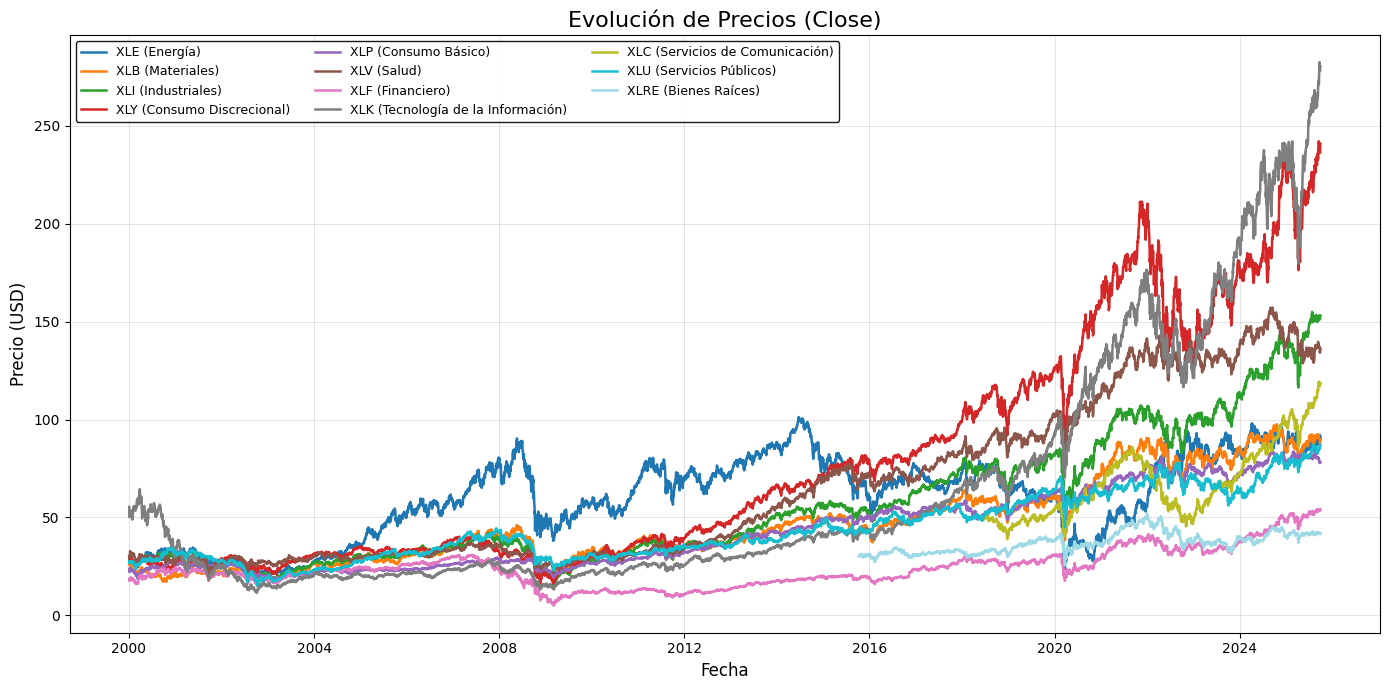

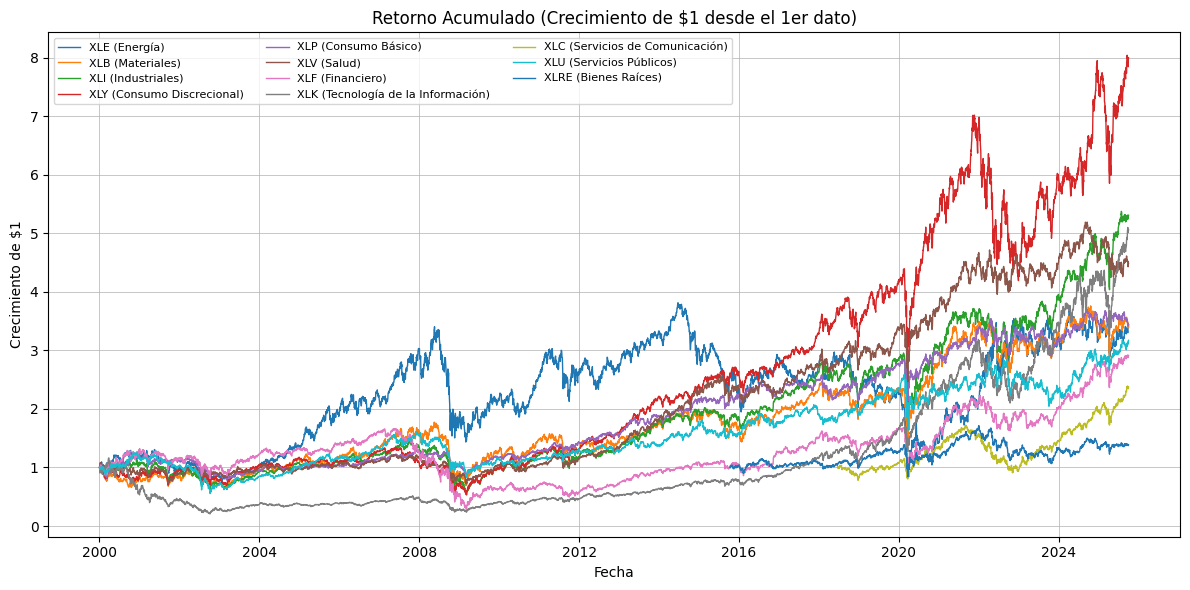

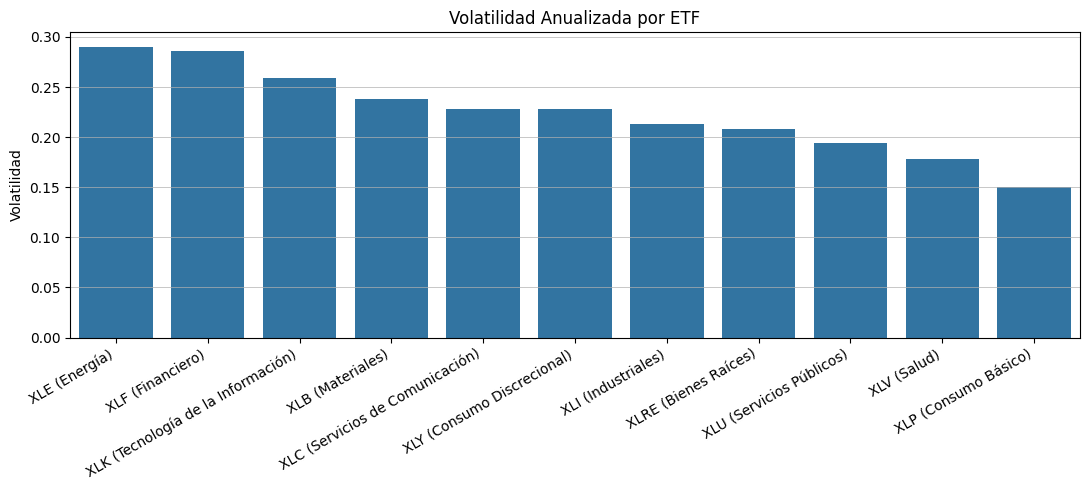

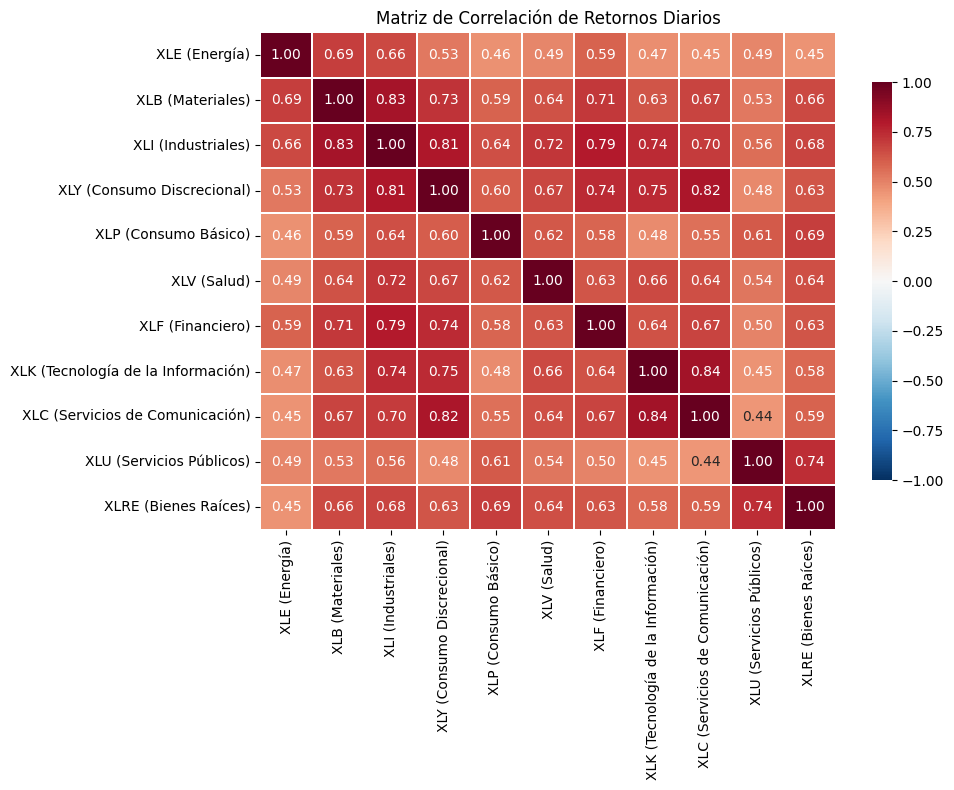

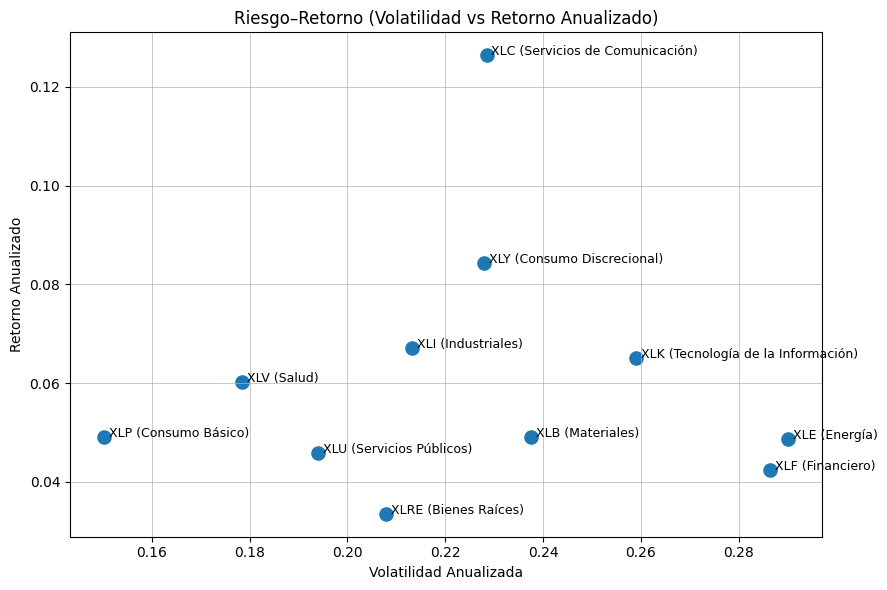

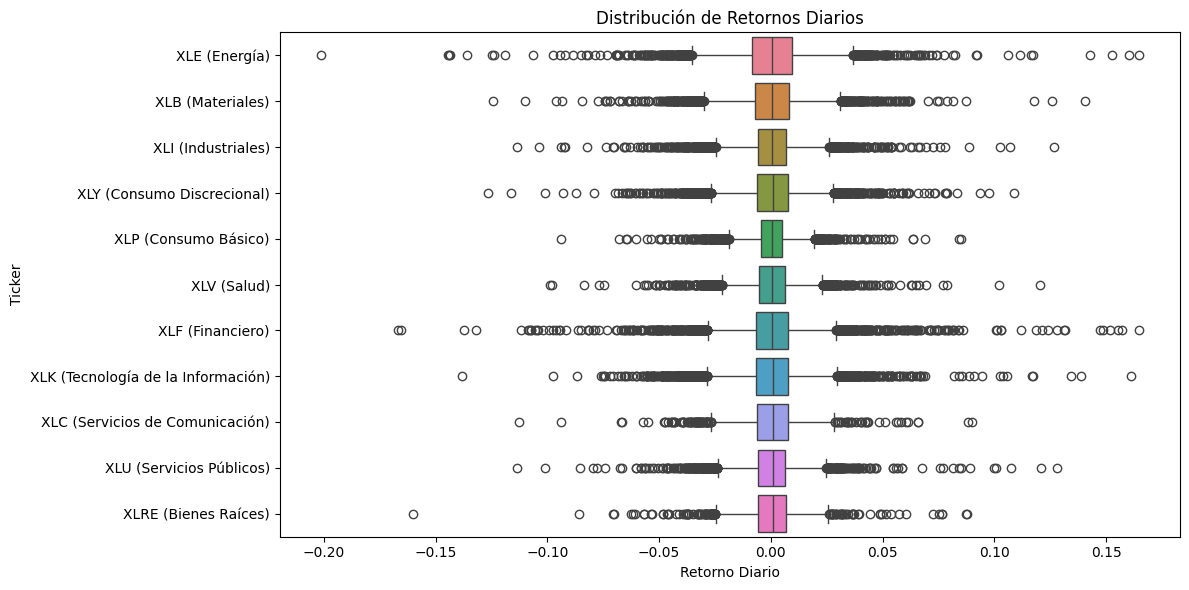


✅ Archivo Excel generado: ./outputs/exploratorio_etfs.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ===========================================================
# 2) Análisis Exploratorio de ETFs (Precios Diarios)
#    - Usa daily_close_df (no re-descarga)
#    - Métricas desde el 1er dato válido de CADA ETF (p.ej. 2000-01-01)
#    - Leyendas legibles: 'XLE (Energía)'
# ===========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

assert 'daily_close_df' in globals(), "Falta daily_close_df (crealo en el Punto 1)."

# ---------- Helpers ----------
def pretty_label(col: str) -> str:
    """Convierte 'XLE_Energía' -> 'XLE (Energía)'."""
    if "_" in col:
        t, sec = col.split("_", 1)
        return f"{t} ({sec})"
    return col

pretty_cols = {c: pretty_label(c) for c in daily_close_df.columns}

# ---------- 1) Retornos diarios y métricas ----------
daily_returns = daily_close_df.pct_change()  # no dropeo global; cada serie maneja sus NaNs

# Retorno anualizado (CAGR) a partir de PRECIOS (robusto)
def _ann_return_from_prices(prc: pd.Series) -> float:
    s = prc.dropna()
    if len(s) < 2: return np.nan
    years_eq = len(s) / 252.0
    return (s.iloc[-1] / s.iloc[0])**(1/years_eq) - 1

ann_returns = daily_close_df.apply(_ann_return_from_prices)

# Volatilidad anualizada (std diaria * sqrt(252))
ann_volatility = daily_returns.apply(lambda s: s.dropna().std(ddof=1) * np.sqrt(252))

# Correlación (pairwise, maneja NaNs)
corr_matrix = daily_returns.corr()

metrics_df = pd.DataFrame({
    "Retorno_Anualizado": ann_returns,
    "Volatilidad_Anualizada": ann_volatility
}).round(4)

print("\n=== Métricas Clave (Retorno & Volatilidad) ===")
display(metrics_df.rename(index=pretty_cols))

# ---------- 2) Evolución de precios (más legible) ----------
import matplotlib.cm as cm
import numpy as np

plt.figure(figsize=(14,7))

# Paleta con suficientes colores distintos (ej: tab20 o viridis)
colors = cm.get_cmap("tab20", len(daily_close_df.columns))

for i, c in enumerate(daily_close_df.columns):
    plt.plot(
        daily_close_df.index, daily_close_df[c],
        label=pretty_cols[c],
        linewidth=1.8,            # un poco más grueso
        color=colors(i)           # color distinto de la paleta
    )

plt.title("Evolución de Precios (Close)", fontsize=16)
plt.xlabel("Fecha", fontsize=12); plt.ylabel("Precio (USD)", fontsize=12)

# Leyenda más clara, con marco
plt.legend(
    loc="upper left", ncol=3, fontsize=9,
    frameon=True, framealpha=0.9, edgecolor="black"
)

plt.grid(True, linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


# ---------- 3) Retorno acumulado (normalizado en el 1er dato de cada ETF) ----------
norm_prices = daily_close_df.copy()
for c in norm_prices.columns:
    s = norm_prices[c].dropna()
    if len(s):
        norm_prices.loc[s.index, c] = s / s.iloc[0]

plt.figure(figsize=(12,6))
for c in norm_prices.columns:
    plt.plot(norm_prices.index, norm_prices[c], label=pretty_cols[c], linewidth=1)
plt.title("Retorno Acumulado (Crecimiento de $1 desde el 1er dato)")
plt.xlabel("Fecha"); plt.ylabel("Crecimiento de $1")
plt.legend(loc="upper left", ncol=3, fontsize=8, frameon=True)
plt.grid(True, linewidth=0.5)
plt.tight_layout()
plt.show()

# ---------- 4) Volatilidad anualizada (barras) ----------
plt.figure(figsize=(11,5))
order = ann_volatility.sort_values(ascending=False).index
sns.barplot(x=[pretty_cols[c] for c in order], y=ann_volatility[order].values)
plt.title("Volatilidad Anualizada por ETF")
plt.ylabel("Volatilidad"); plt.xlabel("")
plt.xticks(rotation=30, ha='right')
plt.grid(True, axis="y", linewidth=0.5)
plt.tight_layout()
plt.show()

# ---------- 5) Matriz de correlación (custom: +1=rojo) ----------
plt.figure(figsize=(10,8))
corr_pretty = corr_matrix.copy()
corr_pretty.index = [pretty_cols[c] for c in corr_pretty.index]
corr_pretty.columns = [pretty_cols[c] for c in corr_pretty.columns]
sns.heatmap(corr_pretty, annot=True, fmt=".2f",
            cmap="RdBu_r", vmin=-1, vmax=1, center=0,
            linewidths=.3, cbar_kws={"shrink": .8})
plt.title("Matriz de Correlación de Retornos Diarios")
plt.tight_layout()
plt.show()


# ---------- 6) Riesgo–retorno (dispersión) ----------
plt.figure(figsize=(9,6))
valid = ~(ann_returns.isna() | ann_volatility.isna())
x = ann_volatility[valid].values
y = ann_returns[valid].values
labs = [pretty_cols[c] for c in ann_returns[valid].index]

plt.scatter(x, y, s=90)
for i, lab in enumerate(labs):
    plt.text(x[i]+0.001, y[i], lab, fontsize=9)
plt.title("Riesgo–Retorno (Volatilidad vs Retorno Anualizado)")
plt.xlabel("Volatilidad Anualizada")
plt.ylabel("Retorno Anualizado")
plt.grid(True, linewidth=0.5)
plt.tight_layout()
plt.show()

# ---------- 7) Distribución de retornos diarios (boxplot) ----------
plt.figure(figsize=(12,6))
sns.boxplot(data=daily_returns.rename(columns=pretty_cols), orient="h")
plt.title("Distribución de Retornos Diarios")
plt.xlabel("Retorno Diario")
plt.tight_layout()
plt.show()

# ---------- 8) Estadísticas descriptivas + Cobertura ----------
stats_df = daily_returns.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
stats_df["skewness"] = daily_returns.skew()
stats_df["kurtosis"]  = daily_returns.kurtosis()
stats_df = stats_df.rename(index=pretty_cols).round(4)

coverage = pd.DataFrame({
    "Primer_Fecha": daily_close_df.apply(lambda s: s.first_valid_index()),
    "Última_Fecha": daily_close_df.apply(lambda s: s.last_valid_index())
}).rename(index=pretty_cols)

# ---------- Guardar a Excel ----------
excel_out = f"{OUTPUT_DIR}/exploratorio_etfs.xlsx"
with pd.ExcelWriter(excel_out, engine=EXCEL_ENGINE) as writer:
    daily_close_df.rename(columns=pretty_cols).to_excel(writer, sheet_name="Precios_Diarios")
    daily_returns.rename(columns=pretty_cols).to_excel(writer, sheet_name="Retornos_Diarios")
    metrics_df.rename(index=pretty_cols).to_excel(writer, sheet_name="Metricas_RetVol")
    corr_pretty.to_excel(writer, sheet_name="Correlacion")
    stats_df.to_excel(writer, sheet_name="Estadisticas")
    coverage.to_excel(writer, sheet_name="Cobertura")

print(f"\n✅ Archivo Excel generado: {excel_out}")
if _ON_COLAB:
    files.download(excel_out)



=== Máximo Drawdown por ETF (desde primer dato) ===


Max_Drawdown_% Inicio_Pico      Valle Recuperación
Ticker                                                                                
XLF (Financiero)                        -83.750000  2007-06-01 2009-03-06   2019-12-17
XLK (Tecnología de la Información)      -82.050000  2000-03-27 2002-10-09   2017-11-24
XLE (Energía)                           -76.730000  2014-06-23 2020-03-23          NaT
XLI (Industriales)                      -63.340000  2007-10-09 2009-03-09   2013-03-11
XLB (Materiales)                        -60.720000  2008-05-20 2009-03-02   2013-12-27
XLY (Consumo Discrecional)              -60.130000  2007-06-04 2009-03-09   2011-04-27
XLU (Servicios Públicos)                -55.670000  2000-12-13 2002-10-09   2006-08-21
XLC (Servicios de Comunicación)         -47.230000  2021-09-01 2022-11-03   2024-06-27
XLV (Salud)                             -40.580000  2007-12-10 2009-03-09   2012-03-13
XLRE (Bienes Raíces)                    -39.280000  2020-02-21 2020-03-23   2021-04-20
XLP (Consumo Básico)                    -37.810000  2000-12-28 2003-03-10   2007-11-28

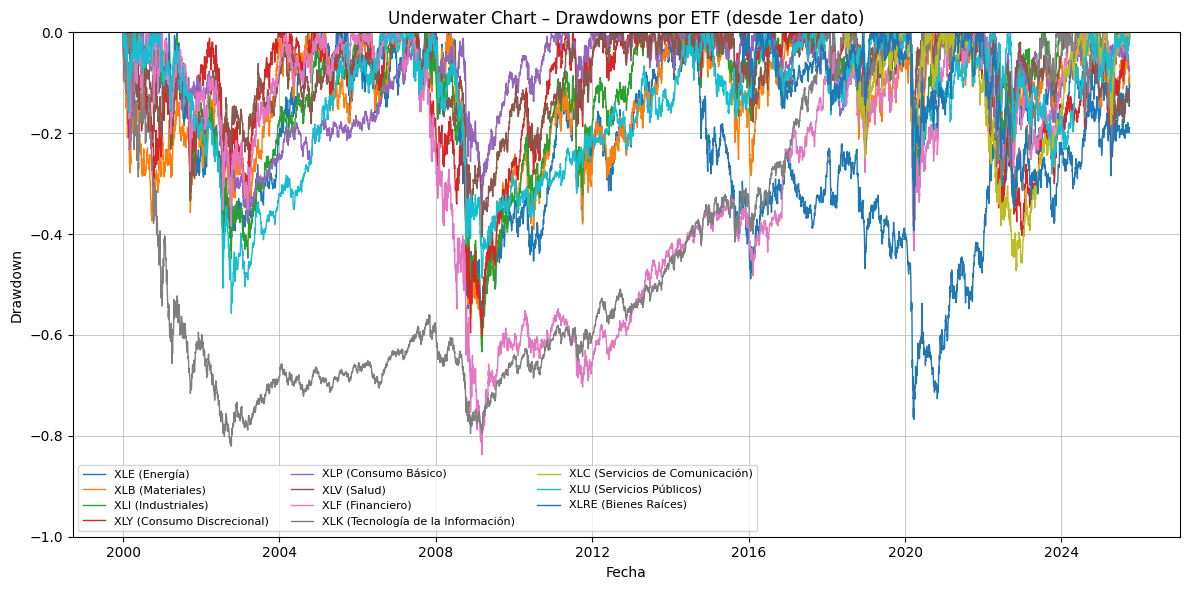

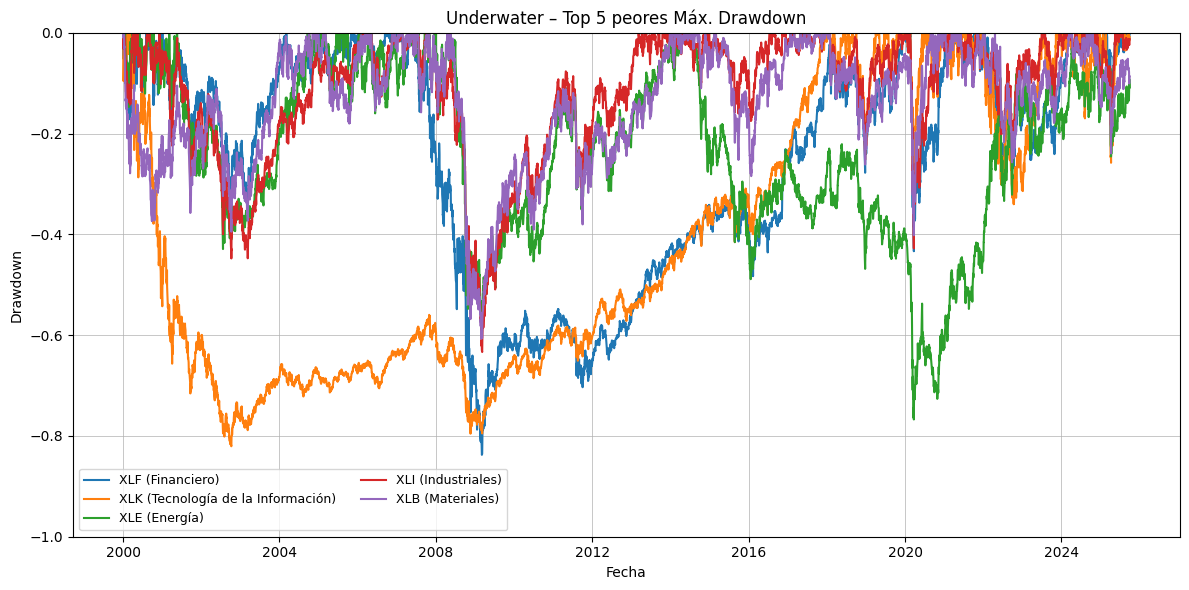

✅ PNG guardados en ./outputs y Excel: ./outputs/exploratorio_etfs_drawdown.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ===========================================================
# 2.1) Drawdowns (underwater) + resumen de Máx. Drawdown
# ===========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

assert 'daily_close_df' in globals(), "Falta daily_close_df (Punto 1)."

# --- Helper para etiquetas legibles ---
def pretty_label(col: str) -> str:
    if "_" in col:
        t, sec = col.split("_", 1)
        return f"{t} ({sec})"
    return col

pretty_cols = {c: pretty_label(c) for c in daily_close_df.columns}

# --- 1) Curvas normalizadas por ETF (desde su primer dato válido) ---
norm_px = daily_close_df.copy()
for c in norm_px.columns:
    s = norm_px[c].dropna()
    if len(s):
        norm_px.loc[s.index, c] = s / s.iloc[0]

# --- 2) Drawdown por ETF: DD_t = (precio / máximo_acum) - 1  (≤ 0) ---
dd_df = pd.DataFrame(index=norm_px.index, columns=norm_px.columns, dtype=float)
for c in norm_px.columns:
    s = norm_px[c].astype(float)
    peak = s.cummax()
    dd_df[c] = (s / peak) - 1.0

# --- 3) Tabla de Máximo Drawdown y fechas (inicio, valle, recuperación) ---
def max_drawdown_info(s: pd.Series):
    """Devuelve (MDD, start_date, trough_date, recovery_date) para serie normalizada."""
    x = s.dropna().astype(float)
    if x.empty:
        return np.nan, pd.NaT, pd.NaT, pd.NaT

    running_max = x.cummax()
    dd = x / running_max - 1.0
    trough_idx = dd.idxmin()                  # fecha del valle
    mdd = dd.loc[trough_idx]                  # valor negativo
    # fecha del pico anterior al valle
    pre_trough = x.loc[:trough_idx]
    start_idx = pre_trough.idxmax()

    # primera recuperación: cuando vuelve a >= pico previo
    peak_level = x.loc[start_idx]
    after_trough = x.loc[trough_idx:]
    recov = after_trough[after_trough >= peak_level]
    recov_idx = recov.index[0] if not recov.empty else pd.NaT
    return float(mdd), start_idx, trough_idx, recov_idx

rows = []
for c in norm_px.columns:
    mdd, start, trough, recov = max_drawdown_info(norm_px[c])
    rows.append({
        "Ticker": pretty_cols[c],
        "Max_Drawdown": mdd,                     # negativo
        "Inicio_Pico": start,
        "Valle": trough,
        "Recuperación": recov
    })
mdd_table = pd.DataFrame(rows).set_index("Ticker").sort_values("Max_Drawdown")
mdd_table["Max_Drawdown_%"] = (mdd_table["Max_Drawdown"] * 100).round(2)
mdd_table = mdd_table[["Max_Drawdown_%", "Inicio_Pico", "Valle", "Recuperación"]]

print("\n=== Máximo Drawdown por ETF (desde primer dato) ===")
display(mdd_table)

# --- 4) Gráfico Underwater (todas las series) ---
plt.figure(figsize=(12,6))
for c in dd_df.columns:
    plt.plot(dd_df.index, dd_df[c], label=pretty_cols[c], linewidth=1)
plt.title("Underwater Chart – Drawdowns por ETF (desde 1er dato)")
plt.xlabel("Fecha"); plt.ylabel("Drawdown")
plt.grid(True, linewidth=0.5)
plt.legend(loc="lower left", ncol=3, fontsize=8, frameon=True)
plt.ylim(-1.0, 0.0)  # de -100% a 0%
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/drawdowns_underwater.png", dpi=200)
plt.show()

# --- 5) (opcional) Gráfico de drawdown solo de los 5 peores MDD para claridad ---
top5 = mdd_table.nsmallest(5, "Max_Drawdown_%").index
plt.figure(figsize=(12,6))
for lab in top5:
    # buscar la columna original correspondiente a 'lab'
    col = [k for k,v in pretty_cols.items() if v == lab][0]
    plt.plot(dd_df.index, dd_df[col], label=lab, linewidth=1.5)
plt.title("Underwater – Top 5 peores Máx. Drawdown")
plt.xlabel("Fecha"); plt.ylabel("Drawdown")
plt.grid(True, linewidth=0.5)
plt.legend(loc="lower left", ncol=2, fontsize=9, frameon=True)
plt.ylim(-1.0, 0.0)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/drawdowns_underwater_top5.png", dpi=200)
plt.show()

# --- 6) Exportar a Excel (agregar/crear hojas) ---
# Si ya creaste exploratorio_etfs.xlsx antes, lo reescribimos agregando hojas de drawdown.
# Para evitar conflictos entre engines, creamos/actualizamos un archivo aparte.
dd_excel = f"{OUTPUT_DIR}/exploratorio_etfs_drawdown.xlsx"
with pd.ExcelWriter(dd_excel, engine=EXCEL_ENGINE) as writer:
    norm_px.rename(columns=pretty_cols).to_excel(writer, sheet_name="Precios_Normalizados")
    dd_df.rename(columns=pretty_cols).to_excel(writer, sheet_name="Drawdowns_Series")
    mdd_table.to_excel(writer, sheet_name="Max_Drawdown_Resumen")

print(f"✅ PNG guardados en {OUTPUT_DIR} y Excel: {dd_excel}")
if _ON_COLAB:
    from google.colab import files
    files.download(f"{OUTPUT_DIR}/drawdowns_underwater.png")
    files.download(f"{OUTPUT_DIR}/drawdowns_underwater_top5.png")
    files.download(dd_excel)


In [ ]:
# ===========================================================
# 3) Backtesting de Carteras
#    - Naïve 1/N
#    - Markowitz (MVP y Target)
#    - Black-Litterman
#    - (El modelo ML usará LOS MISMOS retornos logarítmicos mensuales)
# -----------------------------------------------------------
#    - Ventana estimación: 60 meses
#    - Evaluación mensual: 2005-01 a 2024-12 (ajustable)
#    - daily_close_df proviene del Punto 1
# ===========================================================
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from itertools import combinations

assert 'daily_close_df' in globals(), "Falta daily_close_df (crealo en el Punto 1)."

# ---------- Parámetros ----------
WINDOW = WINDOW_SIZE_M               # 60
EVAL_START = pd.Timestamp("2005-01-01")
EVAL_END   = pd.Timestamp("2025-09-30")      ####Aca poner de nuevo "2024-12-31"

# ---------- 0) Precios y retornos mensuales ----------
monthly_prices = daily_close_df.resample("M").last()

# ✅ Retornos logarítmicos mensuales (COMUNES a TODOS los modelos, incluido ML)
monthly_logret = np.log(monthly_prices / monthly_prices.shift(1))

# Este DataFrame 'returns' será el insumo de:
# - Naïve 1/N
# - Markowitz (MVP y Target)
# - Black-Litterman
# - Modelo Machine Learning (Lasso) en el Punto 5
returns = monthly_logret.copy()

# ---------- 1) Determinar primer índice de backtest ----------
# Queremos que la ventana histórica termine el mes anterior a la 1a evaluación (estilo i/i+1)
ret_idx = returns.index.sort_values()
# Posición donde evaluation_month = ret_idx[i+1] sea >= EVAL_START
i_eval_start = np.argmax(ret_idx >= EVAL_START)
# El índice 'i' arranca en el mes anterior a la 1a evaluación
start_i = max(WINDOW - 1, i_eval_start - 1)

# Limitar también por EVAL_END
last_eval_pos = np.where(ret_idx <= EVAL_END)[0]
last_eval_pos = last_eval_pos[-1] if len(last_eval_pos) else len(ret_idx) - 1

print(f"\nBacktest mensual desde {ret_idx[start_i+1].date()} hasta {ret_idx[last_eval_pos].date()} "
      f"con ventana de {WINDOW} meses.")

# ---------- 2) Naïve 1/N ----------
print("\n--- Iniciando Backtesting: Naïve 1/N ---")
portfolio_1N_returns = pd.Series(dtype=float)
all_weights_1N_df = pd.DataFrame(columns=returns.columns, dtype=float)

for i in range(start_i, last_eval_pos):
    evaluation_month_date = ret_idx[i + 1]
    # ETFs disponibles en el mes de evaluación (no NaN en ese mes)
    r_t = returns.loc[evaluation_month_date].dropna()
    if r_t.empty:
        portfolio_1N_returns.at[evaluation_month_date] = np.nan
        all_weights_1N_df.loc[evaluation_month_date] = np.nan
        continue

    n_active = len(r_t)
    w = np.array([1.0 / n_active] * n_active)

    # Guardar pesos en formato ancho con todas las columnas (otras = 0)
    w_series = pd.Series(0.0, index=returns.columns)
    w_series[r_t.index] = w
    all_weights_1N_df.loc[evaluation_month_date] = w_series

    # Retorno de la cartera en el mes de evaluación (log-ret)
    portfolio_1N_returns.at[evaluation_month_date] = float(np.dot(w, r_t.values))

print("--- Naïve 1/N completado ---")

# ---------- 3) Target para Markowitz (a partir de Naïve) ----------
if not portfolio_1N_returns.empty:
    benchmark_avg_annual_return = portfolio_1N_returns.mean() * MONTHS_PER_YEAR
    target_return_annual_for_markowitz = benchmark_avg_annual_return + 0.001
    target_return_monthly = target_return_annual_for_markowitz / MONTHS_PER_YEAR
else:
    target_return_monthly = 0.005  # fallback

print(f"Retorno objetivo mensual para Markowitz: {target_return_monthly:.6f} (log)")

# ---------- 4) Markowitz (MVP y Target) + Black-Litterman ----------
print("\n--- Iniciando Backtesting: Markowitz MVP/Target y Black-Litterman ---")

portfolio_markowitz_mvp_returns    = pd.Series(dtype=float)
portfolio_markowitz_target_returns = pd.Series(dtype=float)
portfolio_black_litterman_returns  = pd.Series(dtype=float)

all_weights_markowitz_mvp_df    = pd.DataFrame(columns=returns.columns, dtype=float)
all_weights_markowitz_target_df = pd.DataFrame(columns=returns.columns, dtype=float)
all_weights_black_litterman_df  = pd.DataFrame(columns=returns.columns, dtype=float)

for i in range(start_i, last_eval_pos):
    evaluation_month_date = ret_idx[i + 1]

    # Ventana histórica de 60 meses (finaliza en ret_idx[i])
    window_rets = returns.iloc[i - WINDOW + 1 : i + 1]
    # Mantener SOLO columnas con 60 meses completos (sin NaN)
    window_full = window_rets.dropna(axis=1)
    if window_full.shape[1] < 1:
        # No hay activos con 60m completos → saltamos
        for s in [portfolio_markowitz_mvp_returns,
                  portfolio_markowitz_target_returns,
                  portfolio_black_litterman_returns]:
            s.at[evaluation_month_date] = np.nan
        for dfw in [all_weights_markowitz_mvp_df,
                    all_weights_markowitz_target_df,
                    all_weights_black_litterman_df]:
            dfw.loc[evaluation_month_date] = np.nan
        continue

    mu = window_full.mean().values                      # E[r] (log mensual)
    sigma = window_full.cov().values                    # Covarianza
    n = window_full.shape[1]

    # Estabilidad numérica
    sigma_stable = sigma + np.eye(n) * 1e-6

    def port_var(weights, cov):
        return float(weights.T @ cov @ weights)

    def ret_constraint(weights, exp_rets, target):
        return float(weights @ exp_rets - target)

    bounds = tuple((0.0, 1.0) for _ in range(n))
    x0 = np.array([1.0 / n] * n)

    # ------ Markowitz MVP ------
    cons_mvp = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
    try:
        res = minimize(port_var, x0, args=(sigma_stable,),
                       method='SLSQP', bounds=bounds, constraints=cons_mvp)
        w_mvp = res.x if res.success else x0.copy()
    except Exception:
        w_mvp = x0.copy()
    w_mvp = w_mvp / w_mvp.sum()

    # Guardar pesos en la base completa (otras columnas = 0)
    w_series_mvp = pd.Series(0.0, index=returns.columns)
    w_series_mvp[window_full.columns] = w_mvp
    all_weights_markowitz_mvp_df.loc[evaluation_month_date] = w_series_mvp

    # Retorno realizado en el mes de evaluación (usando mismos activos de la ventana)
    r_eval = returns.loc[evaluation_month_date, window_full.columns].dropna()
    if len(r_eval) == len(w_mvp):
        portfolio_markowitz_mvp_returns.at[evaluation_month_date] = float(w_mvp @ r_eval.values)
    else:
        portfolio_markowitz_mvp_returns.at[evaluation_month_date] = np.nan

    # ------ Markowitz Target ------
    cons_tgt = [
        {'type': 'eq',   'fun': lambda w: np.sum(w) - 1.0},
        {'type': 'ineq', 'fun': ret_constraint, 'args': (mu, target_return_monthly)}
    ]
    try:
        res = minimize(port_var, x0, args=(sigma_stable,),
                       method='SLSQP', bounds=bounds, constraints=cons_tgt)
        w_tgt = res.x if res.success else x0.copy()
    except Exception:
        w_tgt = x0.copy()
    w_tgt = w_tgt / w_tgt.sum()

    w_series_tgt = pd.Series(0.0, index=returns.columns)
    w_series_tgt[window_full.columns] = w_tgt
    all_weights_markowitz_target_df.loc[evaluation_month_date] = w_series_tgt

    r_eval = returns.loc[evaluation_month_date, window_full.columns].dropna()
    if len(r_eval) == len(w_tgt):
        portfolio_markowitz_target_returns.at[evaluation_month_date] = float(w_tgt @ r_eval.values)
    else:
        portfolio_markowitz_target_returns.at[evaluation_month_date] = np.nan

    # ------ Black-Litterman ------
    tau = 1.0 / n  # TAU_RULE = "1/N"
    w_market_proxy = np.array([1.0 / n] * n)

    # Implied equilibrium returns Π = δ Σ w_mkt
    Pi = RISK_AVERSION_DELTA * (sigma_stable @ w_market_proxy)

    # Vistas basadas en momentum de MOMENTUM_M meses
    P_rows, Q_vals = [], []
    if window_full.shape[0] >= MOMENTUM_M:
        mom = window_full.iloc[-MOMENTUM_M:].sum()   # log-momentum
        cum6 = np.exp(mom) - 1.0                     # acumulado simple
        diffs = []
        cols = list(window_full.columns)
        for a, b in combinations(cols, 2):
            diffs.append(mom[a] - mom[b])
        thr = np.std(diffs) if (len(diffs) and np.isfinite(np.std(diffs)) and np.std(diffs) > 1e-6) else STD_MOMENTUM_FALLBACK

        for ia, a in enumerate(cols):
            for ib, b in enumerate(cols):
                if ia == ib:
                    continue
                d = mom[a] - mom[b]
                if d > thr:
                    row = np.zeros(n)
                    row[ia], row[ib] = 1.0, -1.0
                    P_rows.append(row)
                    Q_vals.append(cum6[a] - cum6[b])

    P = np.array(P_rows)
    Q = np.array(Q_vals)

    if P.shape[0] > 0:
        # Omega diagonal (Meucci)
        Omega = np.diag(np.diag(P @ (tau * sigma_stable) @ P.T))
        # Posterior
        try:
            inv_tauSigma = np.linalg.inv(tau * sigma_stable)
        except np.linalg.LinAlgError:
            inv_tauSigma = np.linalg.pinv(tau * sigma_stable)
        try:
            Omega_inv = np.linalg.inv(Omega)
        except np.linalg.LinAlgError:
            Omega_inv = np.linalg.pinv(Omega)

        A = inv_tauSigma + P.T @ Omega_inv @ P
        b = inv_tauSigma @ Pi + P.T @ Omega_inv @ Q
        try:
            ER_BL = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
            ER_BL = np.linalg.pinv(A) @ b

        # Optimizamos Máximo Sharpe con ER_BL y sigma
        def neg_sharpe(w, mu_exp, cov, rf):
            ret = w @ mu_exp
            vol = np.sqrt(w.T @ cov @ w)
            return -((ret - rf) / vol) if vol > 0 else 1e6

        cons_bl = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
        try:
            res = minimize(neg_sharpe, x0, args=(ER_BL, sigma_stable, RF_MONTHLY),
                           method='SLSQP', bounds=bounds, constraints=cons_bl)
            w_bl = res.x if res.success else x0.copy()
        except Exception:
            w_bl = x0.copy()
    else:
        # Sin vistas → 1/N
        w_bl = x0.copy()

    w_bl = w_bl / w_bl.sum()
    w_series_bl = pd.Series(0.0, index=returns.columns)
    w_series_bl[window_full.columns] = w_bl
    all_weights_black_litterman_df.loc[evaluation_month_date] = w_series_bl

    r_eval = returns.loc[evaluation_month_date, window_full.columns].dropna()
    if len(r_eval) == len(w_bl):
        portfolio_black_litterman_returns.at[evaluation_month_date] = float(w_bl @ r_eval.values)
    else:
        portfolio_black_litterman_returns.at[evaluation_month_date] = np.nan

print("--- Markowitz y Black-Litterman completados ---")

# ---------- 5) Variables de salida (listas para Punto 4/5) ----------
# Series de retornos (log) por estrategia
portfolio_1N_returns.name                = "Naive_1N"
portfolio_markowitz_mvp_returns.name     = "Markowitz_MVP"
portfolio_markowitz_target_returns.name  = "Markowitz_Target"
portfolio_black_litterman_returns.name   = "BlackLitterman"

# DataFrames de pesos mensuales
all_weights_1N_df.name                   = "Weights_Naive_1N"
all_weights_markowitz_mvp_df.name        = "Weights_Markowitz_MVP"
all_weights_markowitz_target_df.name     = "Weights_Markowitz_Target"
all_weights_black_litterman_df.name      = "Weights_BlackLitterman"

print("\n✅ Backtesting terminado. Variables disponibles:")
print(" - portfolio_1N_returns")
print(" - portfolio_markowitz_mvp_returns")
print(" - portfolio_markowitz_target_returns")
print(" - portfolio_black_litterman_returns")
print(" - all_weights_1N_df")
print(" - all_weights_markowitz_mvp_df")
print(" - all_weights_markowitz_target_df")
print(" - all_weights_black_litterman_df")
print(" - returns (retornos logarítmicos mensuales, COMUNES a todos los modelos, incluido ML)")



Backtest mensual desde 2005-01-31 hasta 2025-09-30 con ventana de 60 meses.

--- Iniciando Backtesting: Naïve 1/N ---
--- Naïve 1/N completado ---
Retorno objetivo mensual para Markowitz: 0.005653 (log)

--- Iniciando Backtesting: Markowitz MVP/Target y Black-Litterman ---
--- Markowitz y Black-Litterman completados ---

✅ Backtesting terminado. Variables disponibles:
 - portfolio_1N_returns
 - portfolio_markowitz_mvp_returns
 - portfolio_markowitz_target_returns
 - portfolio_black_litterman_returns
 - all_weights_1N_df
 - all_weights_markowitz_mvp_df
 - all_weights_markowitz_target_df
 - all_weights_black_litterman_df
 - returns (retornos logarítmicos mensuales, COMUNES a todos los modelos, incluido ML)


In [ ]:
# ===========================================================
# 4) MODELO MACHINE LEARNING (LASSO) PARA CARTERA DE ETFs
#    - Usa 'returns' (retornos logarítmicos mensuales)
#    - Un modelo por ETF (target)
#    - Ventana rolling sin look-ahead
# ===========================================================

# 4.1) Chequeo de insumos y setup
assert "returns" in globals(), (
    "No encuentro el DataFrame 'returns'. "
    "Asegurate de haber ejecutado el Punto 3), "
    "donde se construyen los retornos logarítmicos mensuales."
)

# Trabajamos con una copia ordenada
returns_ml = returns.sort_index().copy()
etfs = returns_ml.columns.tolist()

print("\n=== Setup ML (Lasso por ETF) ===")
print("Shape returns_ml:", returns_ml.shape)
print("ETFs:", etfs)
print(f"LAGS_ML = {LAGS_ML}")
print(f"WINDOW_TRAIN_ML = {WINDOW_TRAIN_ML}")
print(f"Grid de alphas (LassoCV): {ALPHA_GRID[0]:.4f} ... {ALPHA_GRID[-1]:.4f}")

# -----------------------------------------------------------
# 4.2) Definir ETFs con "historia larga" como FEATURES
#      (targets pueden ser todos, incluso XLRE y XLC)
# -----------------------------------------------------------
info_etfs = pd.DataFrame({
    "primer_dato": returns_ml.apply(lambda s: s.first_valid_index()),
    "ultimo_dato": returns_ml.apply(lambda s: s.last_valid_index()),
    "obs_no_nan": returns_ml.notna().sum(),
    "n_nan": returns_ml.isna().sum()
})

print("\n=== Cobertura de datos por ETF ===")
display(info_etfs)

global_min = returns_ml.index.min()
global_max = returns_ml.index.max()
margen_meses = 3  # permitimos un pequeño margen al inicio/fin

long_etfs = []
for col in returns_ml.columns:
    first_i = info_etfs.loc[col, "primer_dato"]
    last_i  = info_etfs.loc[col, "ultimo_dato"]
    if (first_i is not None and last_i is not None and
        first_i <= global_min + pd.DateOffset(months=margen_meses) and
        last_i  >= global_max - pd.DateOffset(months=margen_meses)):
        long_etfs.append(col)

print("\nETFs con historia larga (usados como FEATURES en ML):")
print(long_etfs)

short_etfs = [c for c in returns_ml.columns if c not in long_etfs]
print("\nETFs con historia más corta (SOLO como TARGET, no como feature):")
print(short_etfs)

# -----------------------------------------------------------
# Helper: construcción X,Y por ETF target
# -----------------------------------------------------------
def build_lagged_single_target_ml(ret_df: pd.DataFrame,
                                  target_col: str,
                                  feature_cols: list,
                                  n_lags: int):
    """
    Construye X (features) e Y (target) para un ETF (target_col),
    usando como features los retornos rezagados de feature_cols.

    - X: lags 1..n_lags de feature_cols
    - Y: retornos del ETF target_col
    - Se filtran filas donde falte info en X o en Y
    """
    Y = ret_df[target_col].copy()

    lagged_list = []
    for lag in range(1, n_lags + 1):
        lagged = ret_df[feature_cols].shift(lag)
        lagged.columns = [f"{c}_lag{lag}" for c in feature_cols]
        lagged_list.append(lagged)

    X = pd.concat(lagged_list, axis=1)

    mask = (~X.isna().any(axis=1)) & (~Y.isna())
    X = X.loc[mask]
    Y = Y.loc[mask]

    return X, Y

# Chequeo de observaciones útiles por ETF
obs_por_etf = {}
for col in etfs:
    X_etf, Y_etf = build_lagged_single_target_ml(returns_ml, col, long_etfs, LAGS_ML)
    obs_por_etf[col] = len(Y_etf)

obs_por_etf_series = pd.Series(obs_por_etf).sort_values(ascending=False)
print("\n=== Observaciones útiles por ETF con features largas ===")
display(obs_por_etf_series)

# -----------------------------------------------------------
# 4.3) Entrenamiento estático LassoCV (diagnóstico)
#      - Un modelo por ETF
#      - Solo para ver alphas y #features activos
# -----------------------------------------------------------
modelos_lasso_static = {}
alphas_lasso_static = {}
n_features_usados_static = {}

for col in etfs:
    X_etf, Y_etf = build_lagged_single_target_ml(returns_ml, col, long_etfs, LAGS_ML)

    if len(Y_etf) < MIN_OBS_LASSO:
        print(f"Aviso: {col} tiene pocas observaciones ({len(Y_etf)}). Se omite en fit estático.")
        continue

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_etf)

    lasso = LassoCV(alphas=ALPHA_GRID, cv=5).fit(X_scaled, Y_etf)

    modelos_lasso_static[col] = lasso
    alphas_lasso_static[col] = lasso.alpha_
    n_features_usados_static[col] = np.sum(lasso.coef_ != 0)

resumen_lasso_static = pd.DataFrame({
    "alpha_seleccionado": pd.Series(alphas_lasso_static),
    "n_features_activos": pd.Series(n_features_usados_static)
}).sort_index()

print("\n=== Resumen Lasso estático (diagnóstico) ===")
display(resumen_lasso_static)

# -----------------------------------------------------------
# 4.4) Rolling ML (sin look-ahead)
#      - Entrenamos hasta fecha-1
#      - Predecimos retorno del mes "fecha"
# -----------------------------------------------------------

predicciones_ml = pd.DataFrame(index=returns_ml.index, columns=etfs, dtype=float)

for fecha in returns_ml.index[WINDOW_TRAIN_ML + LAGS_ML:]:
    # 1) Ventana de entrenamiento: [inicio_entrenamiento, fin_entrenamiento]
    fin_entrenamiento = fecha - pd.DateOffset(months=1)
    inicio_entrenamiento = fin_entrenamiento - pd.DateOffset(months=WINDOW_TRAIN_ML - 1)
    ventana = returns_ml.loc[inicio_entrenamiento:fin_entrenamiento].copy()

    # 2) Entrenamos un modelo por ETF target
    for col in etfs:
        X_train, Y_train = build_lagged_single_target_ml(ventana, col, long_etfs, LAGS_ML)

        if len(Y_train) < MIN_OBS_LASSO:
            continue

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train)

        lasso = LassoCV(alphas=ALPHA_GRID, cv=5).fit(X_scaled, Y_train)

        # 3) Predicción para el mes "fecha"
        X_pred_last = X_train.iloc[[-1]]             # última observación de entrenamiento
        X_pred_last_scaled = scaler.transform(X_pred_last.values)
        y_hat = lasso.predict(X_pred_last_scaled)[0]

        predicciones_ml.loc[fecha, col] = y_hat

print("\n=== Rolling ML (Lasso) finalizado ===")
predicciones_ml = predicciones_ml.dropna(how="all")
display(predicciones_ml.head())

# -----------------------------------------------------------
# 4.5) Construcción de pesos ML a partir de predicciones
# -----------------------------------------------------------
pesos_ml = pd.DataFrame(index=predicciones_ml.index, columns=etfs, dtype=float)

for fecha in predicciones_ml.index:
    preds = predicciones_ml.loc[fecha]

    # ETFs con predicción válida
    preds_valid = preds.dropna()
    if preds_valid.empty:
        continue

    # Nos quedamos con predicciones positivas
    preds_pos = preds_valid.clip(lower=0)

    if preds_pos.sum() > 0:
        # Pesos proporcionales a la magnitud del retorno esperado
        w_valid = preds_pos / preds_pos.sum()
    else:
        # Si todas las predicciones son <= 0, cartera equiponderada entre los ETFs con predicción
        w_valid = pd.Series(1.0 / len(preds_valid), index=preds_valid.index)

    pesos_ml.loc[fecha, w_valid.index] = w_valid

pesos_ml = pesos_ml.fillna(0.0)

print("\n=== Pesos ML construidos ===")
display(pesos_ml.head())

# -----------------------------------------------------------
# 4.6) Backtesting del Portafolio ML
#      - Retornos mensuales del portafolio ML
#      - Curva acumulada
# -----------------------------------------------------------

# Alineamos retornos con las fechas donde hay pesos ML
ret_aligned_ml = returns.loc[pesos_ml.index]

retornos_ml_portfolio = (pesos_ml * ret_aligned_ml).sum(axis=1)
retorno_acumulado_ml = (1 + retornos_ml_portfolio).cumprod()

retornos_ml_portfolio.name = "ML_Lasso"

print("\n=== Backtesting ML completado ===")
display(retornos_ml_portfolio.head())
display(retorno_acumulado_ml.head())

print("\n✅ Modelo ML (Lasso) listo. Variables disponibles:")
print(" - predicciones_ml  (retornos esperados por ETF)")
print(" - pesos_ml         (pesos de cartera por mes)")
print(" - retornos_ml_portfolio  (retornos mensuales de la cartera ML)")
print(" - retorno_acumulado_ml   (curva acumulada ML)")



=== Setup ML (Lasso por ETF) ===
Shape returns_ml: (309, 11)
ETFs: ['XLE_Energía', 'XLB_Materiales', 'XLI_Industriales', 'XLY_Consumo Discrecional', 'XLP_Consumo Básico', 'XLV_Salud', 'XLF_Financiero', 'XLK_Tecnología de la Información', 'XLC_Servicios de Comunicación', 'XLU_Servicios Públicos', 'XLRE_Bienes Raíces']
LAGS_ML = 12
WINDOW_TRAIN_ML = 60
Grid de alphas (LassoCV): 0.0001 ... 1.0000

=== Cobertura de datos por ETF ===


primer_dato ultimo_dato  obs_no_nan  n_nan
Ticker                                                                     
XLE_Energía                       2000-02-29  2025-09-30         308      1
XLB_Materiales                    2000-02-29  2025-09-30         308      1
XLI_Industriales                  2000-02-29  2025-09-30         308      1
XLY_Consumo Discrecional          2000-02-29  2025-09-30         308      1
XLP_Consumo Básico                2000-02-29  2025-09-30         308      1
XLV_Salud                         2000-02-29  2025-09-30         308      1
XLF_Financiero                    2000-02-29  2025-09-30         308      1
XLK_Tecnología de la Información  2000-02-29  2025-09-30         308      1
XLC_Servicios de Comunicación     2018-07-31  2025-09-30          87    222
XLU_Servicios Públicos            2000-02-29  2025-09-30         308      1
XLRE_Bienes Raíces                2015-11-30  2025-09-30         119    190


ETFs con historia larga (usados como FEATURES en ML):
['XLE_Energía', 'XLB_Materiales', 'XLI_Industriales', 'XLY_Consumo Discrecional', 'XLP_Consumo Básico', 'XLV_Salud', 'XLF_Financiero', 'XLK_Tecnología de la Información', 'XLU_Servicios Públicos']

ETFs con historia más corta (SOLO como TARGET, no como feature):
['XLC_Servicios de Comunicación', 'XLRE_Bienes Raíces']

=== Observaciones útiles por ETF con features largas ===


XLE_Energía                         296
XLB_Materiales                      296
XLI_Industriales                    296
XLY_Consumo Discrecional            296
XLP_Consumo Básico                  296
XLV_Salud                           296
XLF_Financiero                      296
XLK_Tecnología de la Información    296
XLU_Servicios Públicos              296
XLRE_Bienes Raíces                  119
XLC_Servicios de Comunicación        87
dtype: int64


=== Resumen Lasso estático (diagnóstico) ===


alpha_seleccionado  n_features_activos
XLB_Materiales                              1.000000                   0
XLC_Servicios de Comunicación               1.000000                   0
XLE_Energía                                 1.000000                   0
XLF_Financiero                              1.000000                   0
XLI_Industriales                            0.007848                   3
XLK_Tecnología de la Información            0.012743                   1
XLP_Consumo Básico                          1.000000                   0
XLRE_Bienes Raíces                          1.000000                   0
XLU_Servicios Públicos                      1.000000                   0
XLV_Salud                                   0.004833                   4
XLY_Consumo Discrecional                    1.000000                   0


=== Rolling ML (Lasso) finalizado ===


XLE_Energía  XLB_Materiales  XLI_Industriales  XLY_Consumo Discrecional  XLP_Consumo Básico  XLV_Salud  XLF_Financiero  \
Date                                                                                                                                 
2006-01-31     0.013199        0.007212          0.002625                  0.002759           -0.007888   0.003395        0.003871   
2006-02-28     0.014250        0.006874          0.004070                  0.002130           -0.003091   0.003626        0.004197   
2006-03-31     0.014078        0.006187          0.004167                  0.002490           -0.002650   0.003120        0.005096   
2006-04-30     0.012644        0.005745          0.003750                  0.002300           -0.002940   0.001996        0.003912   
2006-05-31     0.019471        0.008209          0.006430                  0.003226           -0.000893   0.001090        0.005199   

            XLK_Tecnología de la Información  XLC_Servicios de Comunicación  XLU_Servicios Públicos  XLRE_Bienes Raíces  
Date                                                                                                                     
2006-01-31                         -0.002881                            NaN                0.002359                 NaN  
2006-02-28                         -0.002711                            NaN                0.003190                 NaN  
2006-03-31                          0.000985                            NaN                0.003931                 NaN  
2006-04-30                         -0.000020                            NaN                0.003080                 NaN  
2006-05-31                          0.002857                            NaN                0.003505                 NaN


=== Pesos ML construidos ===


XLE_Energía  XLB_Materiales  XLI_Industriales  XLY_Consumo Discrecional  XLP_Consumo Básico  XLV_Salud  XLF_Financiero  \
Date                                                                                                                                 
2006-01-31     0.372642        0.203609          0.074119                  0.077899            0.000000   0.095854        0.109286   
2006-02-28     0.371717        0.179311          0.106155                  0.055554            0.000000   0.094578        0.109485   
2006-03-31     0.351481        0.154462          0.104042                  0.062160            0.000000   0.077893        0.127227   
2006-04-30     0.378250        0.171870          0.112180                  0.068818            0.000000   0.059706        0.117024   
2006-05-31     0.389519        0.164224          0.128639                  0.064531            0.000000   0.021810        0.104005   

            XLK_Tecnología de la Información  XLC_Servicios de Comunicación  XLU_Servicios Públicos  XLRE_Bienes Raíces  
Date                                                                                                                     
2006-01-31                          0.000000                       0.000000                0.066591            0.000000  
2006-02-28                          0.000000                       0.000000                0.083200            0.000000  
2006-03-31                          0.024598                       0.000000                0.098136            0.000000  
2006-04-30                          0.000000                       0.000000                0.092152            0.000000  
2006-05-31                          0.057153                       0.000000                0.070120            0.000000


=== Backtesting ML completado ===


Date
2006-01-31    0.065771
2006-02-28   -0.031747
2006-03-31    0.017912
2006-04-30    0.032400
2006-05-31   -0.028219
Freq: ME, Name: ML_Lasso, dtype: float64

Date
2006-01-31   1.065771
2006-02-28   1.031936
2006-03-31   1.050420
2006-04-30   1.084454
2006-05-31   1.053852
Freq: ME, dtype: float64


✅ Modelo ML (Lasso) listo. Variables disponibles:
 - predicciones_ml  (retornos esperados por ETF)
 - pesos_ml         (pesos de cartera por mes)
 - retornos_ml_portfolio  (retornos mensuales de la cartera ML)
 - retorno_acumulado_ml   (curva acumulada ML)


In [ ]:
# ===========================================================
# 5.1) Exportar Retornos y Pesos Mensuales de las Carteras
#      (Naïve, Markowitz, Black-Litterman y ML Lasso)
# ===========================================================
import pandas as pd

# Aseguramos nombres consistentes
portfolio_1N_returns.name               = "Naive_1N"
portfolio_markowitz_mvp_returns.name    = "Markowitz_MVP"
portfolio_markowitz_target_returns.name = "Markowitz_Target"
portfolio_black_litterman_returns.name  = "BlackLitterman"
retornos_ml_portfolio.name              = "ML_Lasso"

# --- 1) Unificar retornos logarítmicos de TODAS las estrategias ---
returns_all_log = pd.concat([
    portfolio_1N_returns,
    portfolio_markowitz_mvp_returns,
    portfolio_markowitz_target_returns,
    portfolio_black_litterman_returns,
    retornos_ml_portfolio
], axis=1).sort_index()

# --- 2) Preparar pesos (ya están en DataFrames por cartera) ---
weights_dict = {
    "Naive_1N":        all_weights_1N_df,
    "Markowitz_MVP":   all_weights_markowitz_mvp_df,
    "Markowitz_Target":all_weights_markowitz_target_df,
    "BlackLitterman":  all_weights_black_litterman_df,
    "ML_Lasso":        pesos_ml
}

# --- 3) Guardar en Excel con varias hojas ---
excel_out = f"{OUTPUT_DIR}/carteras_retornos_pesos.xlsx"
with pd.ExcelWriter(excel_out, engine=EXCEL_ENGINE) as writer:
    # Retornos de todas las carteras
    returns_all_log.to_excel(writer, sheet_name="Retornos_Log")

    # Pesos por cartera en hojas separadas
    for name, df in weights_dict.items():
        df.to_excel(writer, sheet_name=f"Pesos_{name}")

    # También un combinado con columnas multi-índice (Cartera, ETF)
    dfs_mi = []
    for name, df in weights_dict.items():
        tmp = df.copy()
        tmp.columns = pd.MultiIndex.from_product([[name], tmp.columns])
        dfs_mi.append(tmp)
    weights_combined = pd.concat(dfs_mi, axis=1).sort_index()
    weights_combined.to_excel(writer, sheet_name="Pesos_Combinado")

print(f"✅ Archivo Excel generado: {excel_out}")

# --- 4) Descargar en Colab ---
if _ON_COLAB:
    from google.colab import files
    files.download(excel_out)


✅ Archivo Excel generado: ./outputs/carteras_retornos_pesos.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

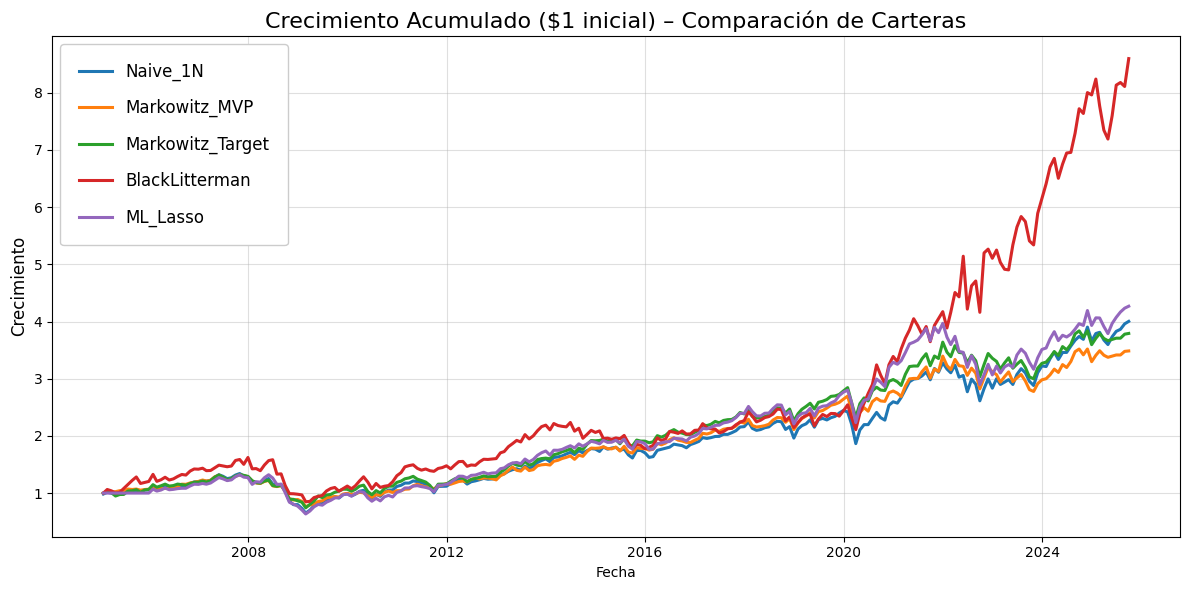

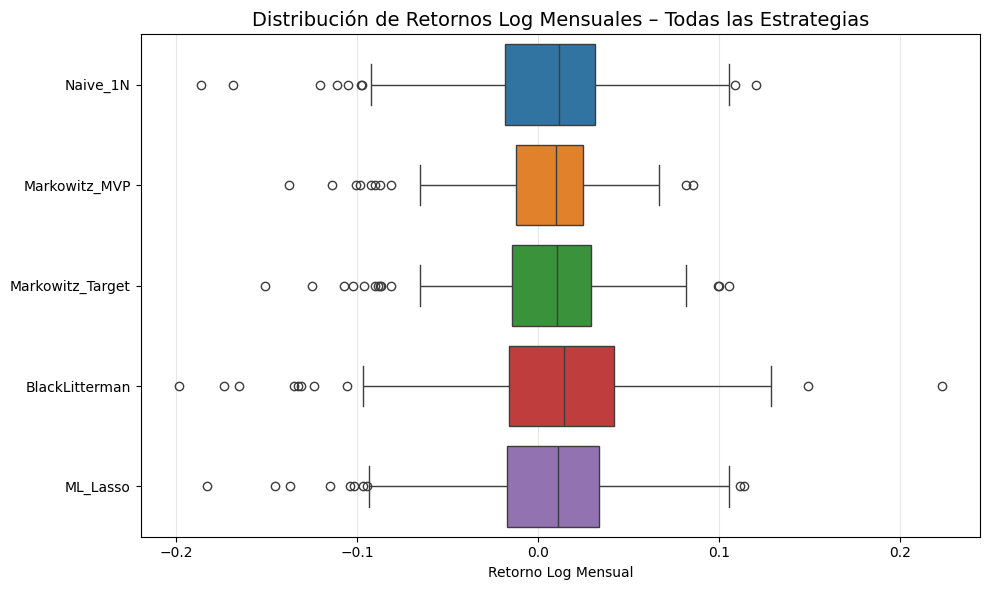

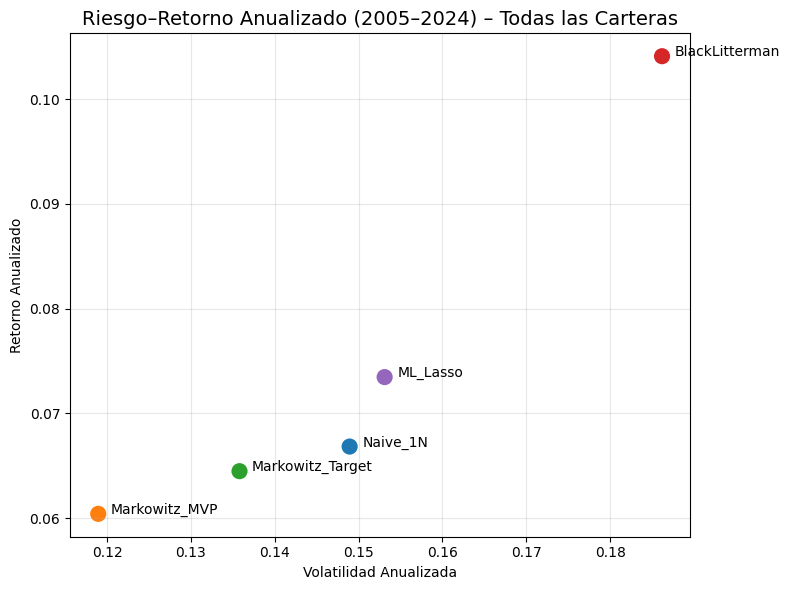

<Figure size 1200x600 with 0 Axes>

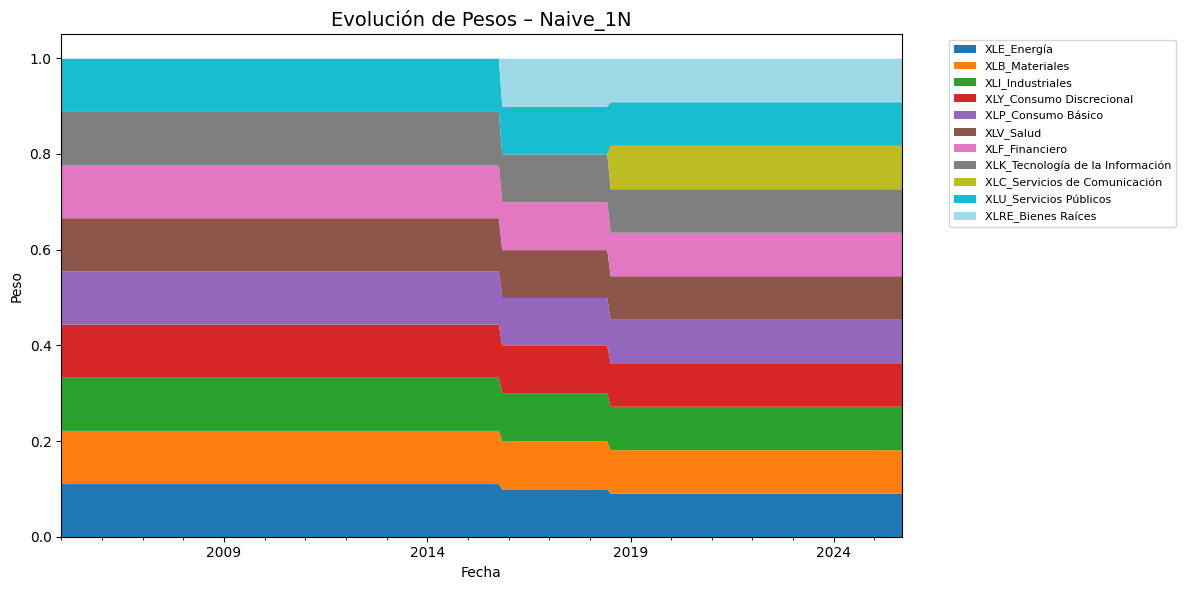

<Figure size 1200x600 with 0 Axes>

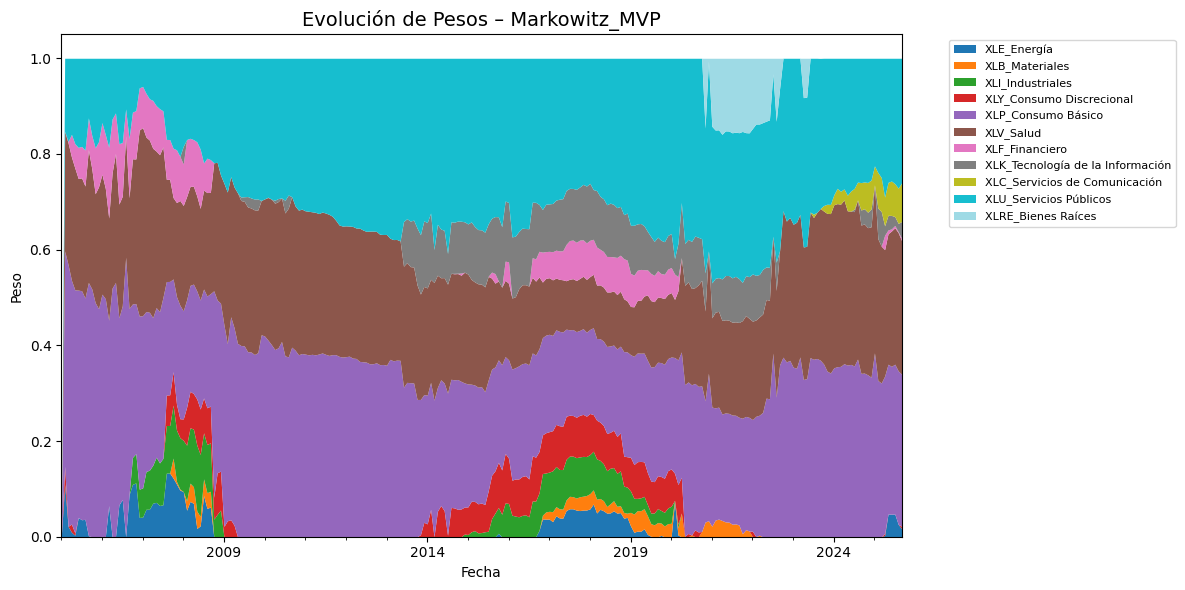

<Figure size 1200x600 with 0 Axes>

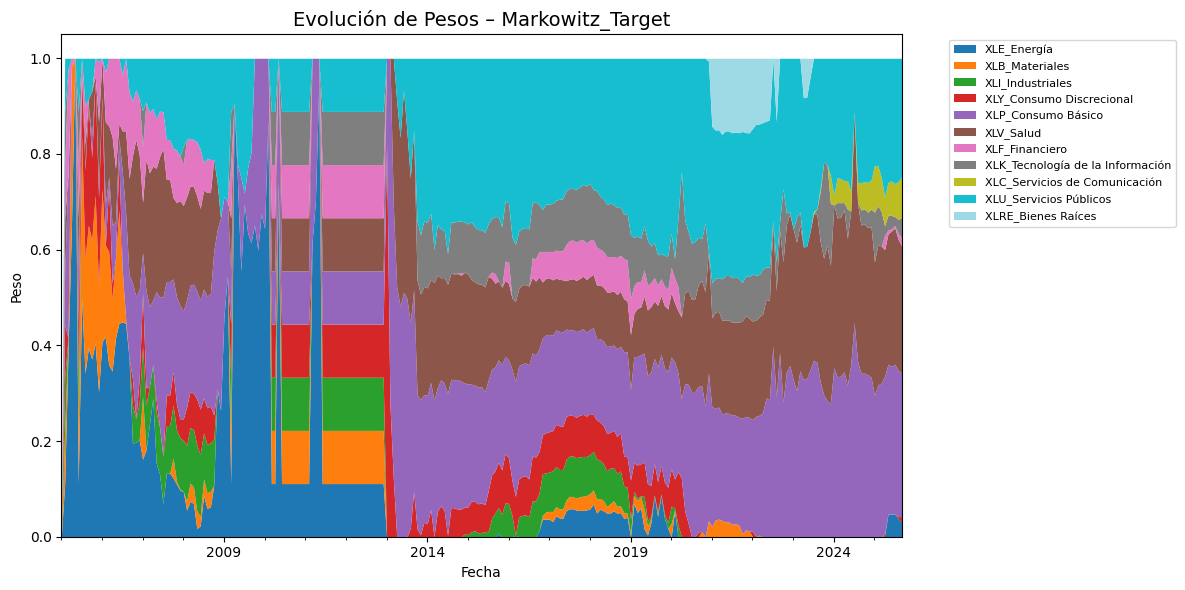

<Figure size 1200x600 with 0 Axes>

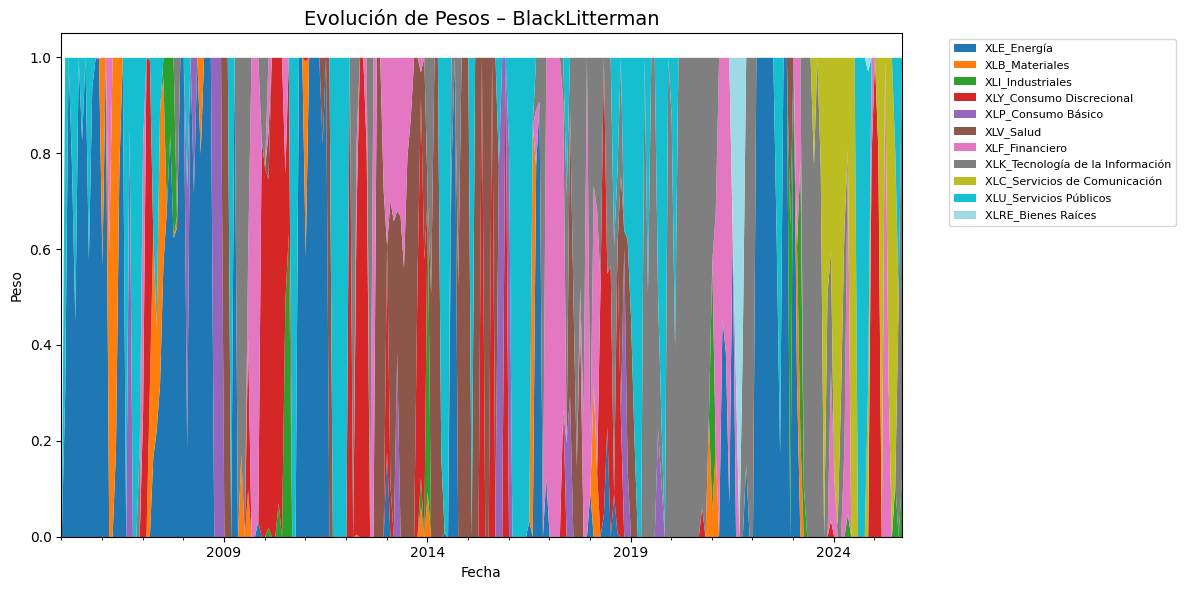

<Figure size 1200x600 with 0 Axes>

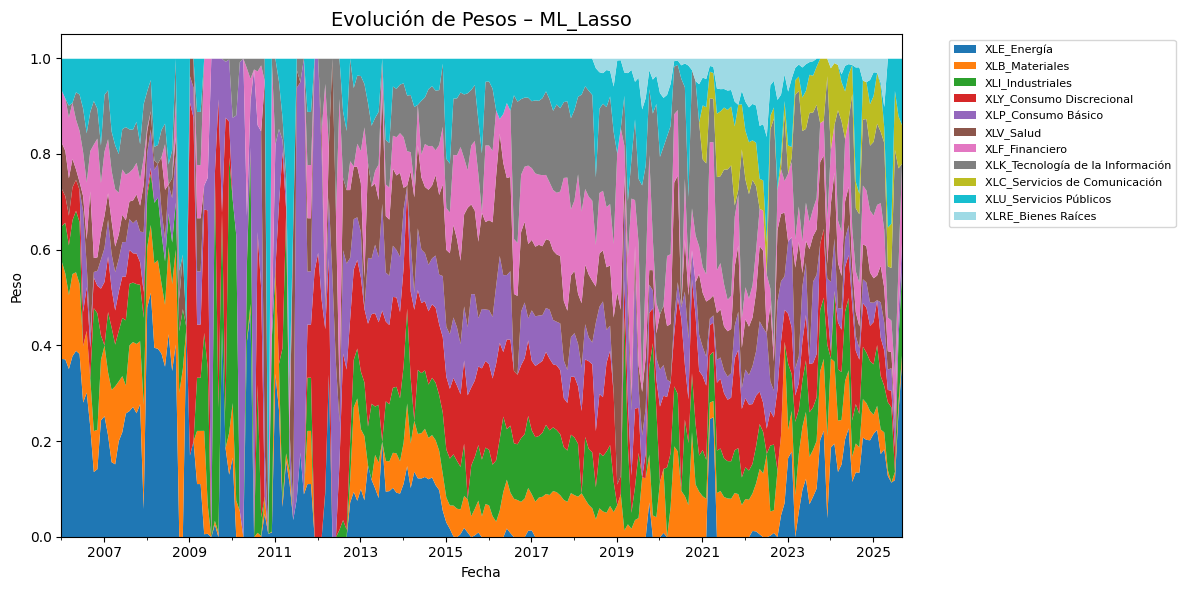

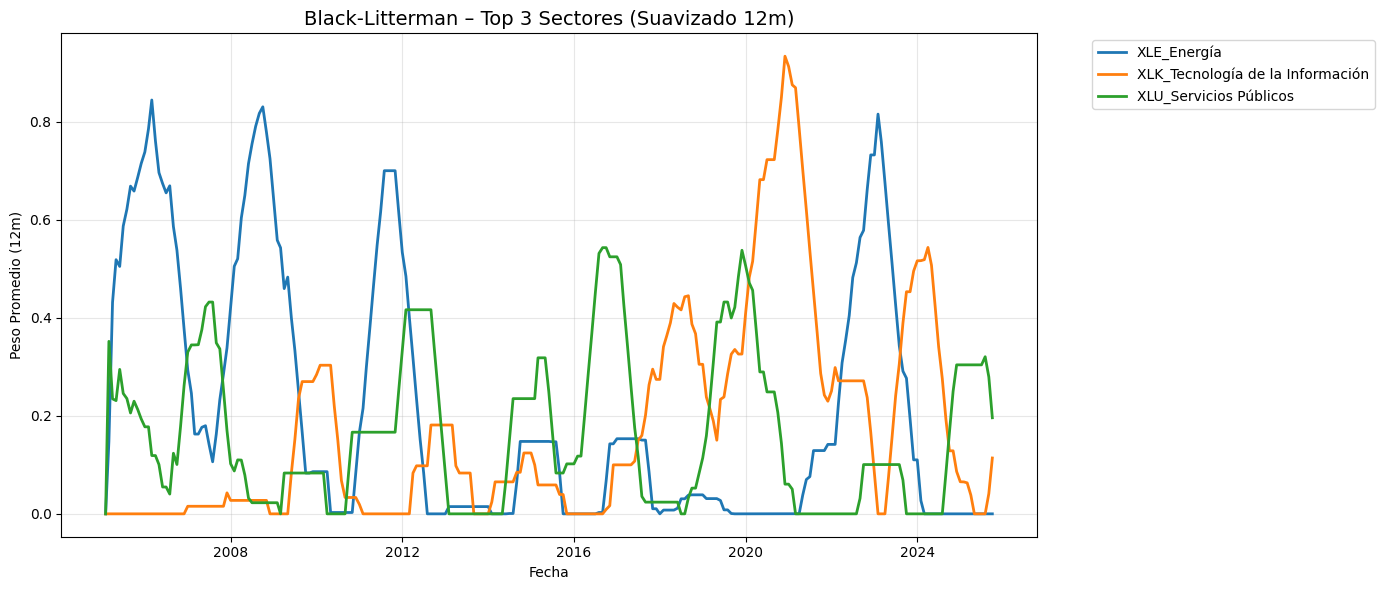

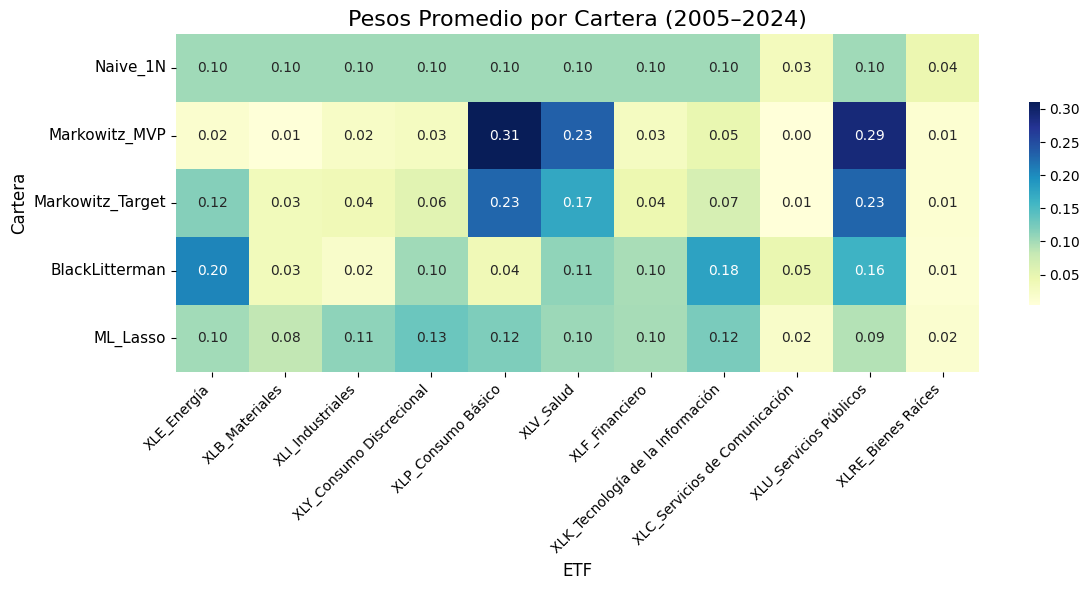

In [ ]:
# ===========================================================
# 5.2) Gráficos sobre Retornos Log y Pesos de Carteras
#      (incluye Naïve, Markowitz, BL y ML Lasso)
# ===========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurarnos de tener returns_all_log y weights_dict del paso 5.1
assert "returns_all_log" in globals(), "Falta returns_all_log (ejecuta paso 5.1 primero)"
assert "weights_dict" in globals(), "Falta weights_dict (ejecuta paso 5.1 primero)"

# ---------- 1) Evolución acumulada ----------
plt.figure(figsize=(12,6))

cum_growth = (returns_all_log.fillna(0)).cumsum().apply(np.exp)

for col in cum_growth.columns:
    plt.plot(cum_growth.index, cum_growth[col], label=col, linewidth=2.2)

plt.title("Crecimiento Acumulado ($1 inicial) – Comparación de Carteras", fontsize=16)
plt.xlabel("Fecha"); plt.ylabel("Crecimiento",  fontsize=12)

plt.legend(
    loc="upper left",
    fontsize=12,
    frameon=True,
    framealpha=1,
    borderpad=1.1,
    labelspacing=1.1
)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

# ---------- 2) Distribución de retornos ----------
plt.figure(figsize=(10,6))
sns.boxplot(data=returns_all_log, orient="h")
plt.title("Distribución de Retornos Log Mensuales – Todas las Estrategias", fontsize=14)
plt.xlabel("Retorno Log Mensual")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout(); plt.show()

# ---------- 3) Riesgo-retorno promedio ----------
mean_rets = returns_all_log.mean() * 12   # anualizado
vol_rets  = returns_all_log.std() * np.sqrt(12)

plt.figure(figsize=(8,6))
sns.scatterplot(x=vol_rets, y=mean_rets, s=160, hue=mean_rets.index, legend=False)

for name in mean_rets.index:
    plt.text(vol_rets[name] + 0.0015, mean_rets[name], name, fontsize=10)

plt.title("Riesgo–Retorno Anualizado (2005–2024) – Todas las Carteras", fontsize=14)
plt.xlabel("Volatilidad Anualizada")
plt.ylabel("Retorno Anualizado")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# ---------- 4) Evolución de pesos (stacked area) ----------
for name, wdf in weights_dict.items():
    if wdf.empty:
        continue
    plt.figure(figsize=(12,6))
    wdf_plot = wdf.fillna(0)
    wdf_plot.plot.area(figsize=(12,6), colormap="tab20", linewidth=0)
    plt.title(f"Evolución de Pesos – {name}", fontsize=14)
    plt.xlabel("Fecha"); plt.ylabel("Peso")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=8)
    plt.tight_layout(); plt.show()

# ---------- 4.1) Evolución Black-Litterman – Top 3 ----------
if "BlackLitterman" in weights_dict and not weights_dict["BlackLitterman"].empty:
    wdf_bl = weights_dict["BlackLitterman"].copy().fillna(0)
    wdf_bl = wdf_bl.select_dtypes(include=[np.number])

    top3_cols = wdf_bl.mean().nlargest(3).index.tolist()
    wdf_top = wdf_bl[top3_cols]
    wdf_top_smooth = wdf_top.rolling(window=12, min_periods=1).mean()

    plt.figure(figsize=(14,6))
    for col in wdf_top_smooth.columns:
        plt.plot(wdf_top_smooth.index, wdf_top_smooth[col], label=col, linewidth=2)
    plt.title("Black-Litterman – Top 3 Sectores (Suavizado 12m)", fontsize=14)
    plt.xlabel("Fecha"); plt.ylabel("Peso Promedio (12m)")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ---------- 5) Heatmap de pesos promedio ----------
avg_weights = {name: df.mean() for name, df in weights_dict.items() if not df.empty}
avg_weights_df = pd.DataFrame(avg_weights).T

plt.figure(figsize=(12,6))
sns.heatmap(
    avg_weights_df,
    annot=True, fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={"shrink": 0.6}
)
plt.title("Pesos Promedio por Cartera (2005–2024)", fontsize=16)
plt.xlabel("ETF", fontsize=12)
plt.ylabel("Cartera", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()


✅ Excel generado: ./outputs/retornos_anuales_y_cagr_2005_2024.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

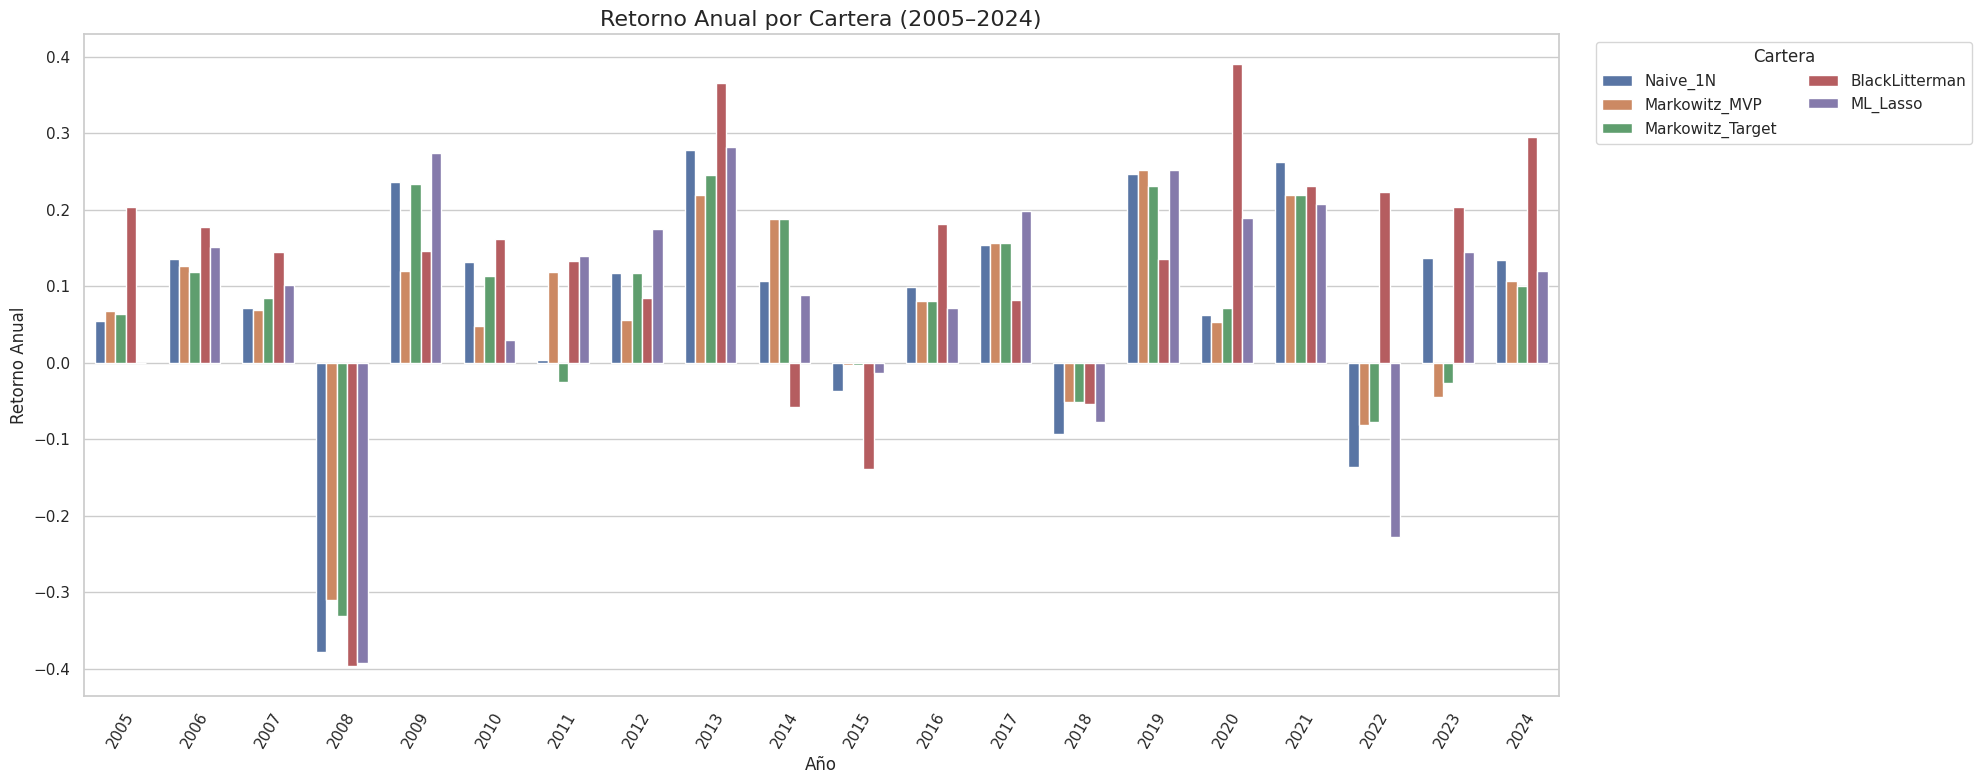

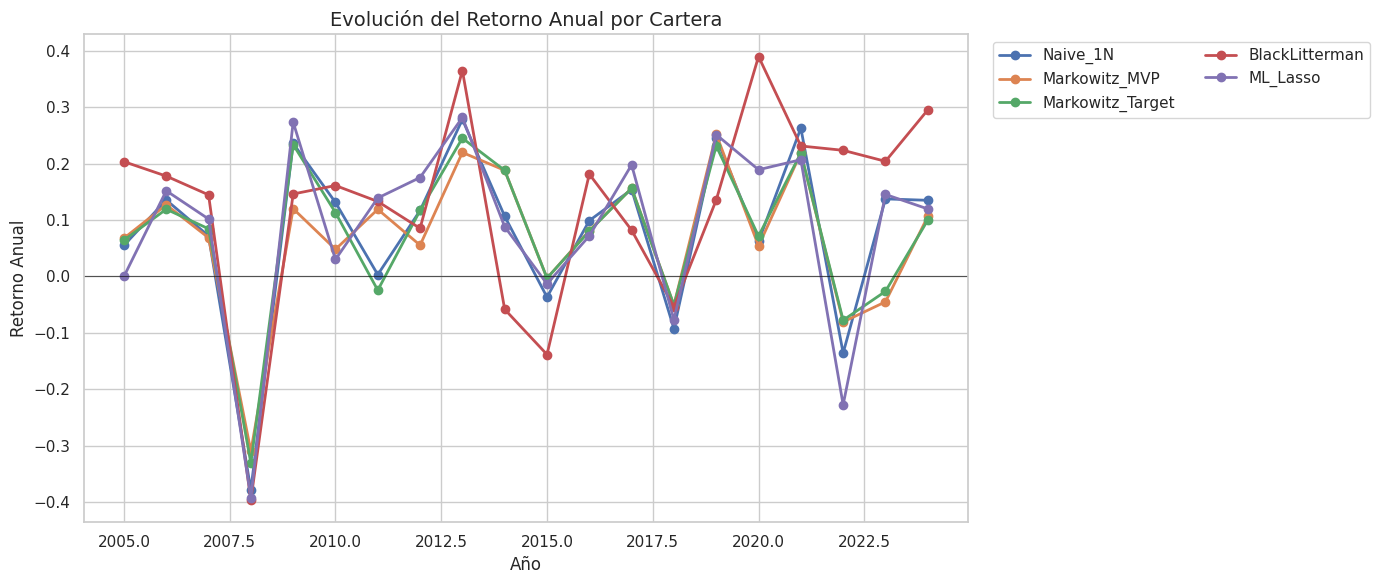

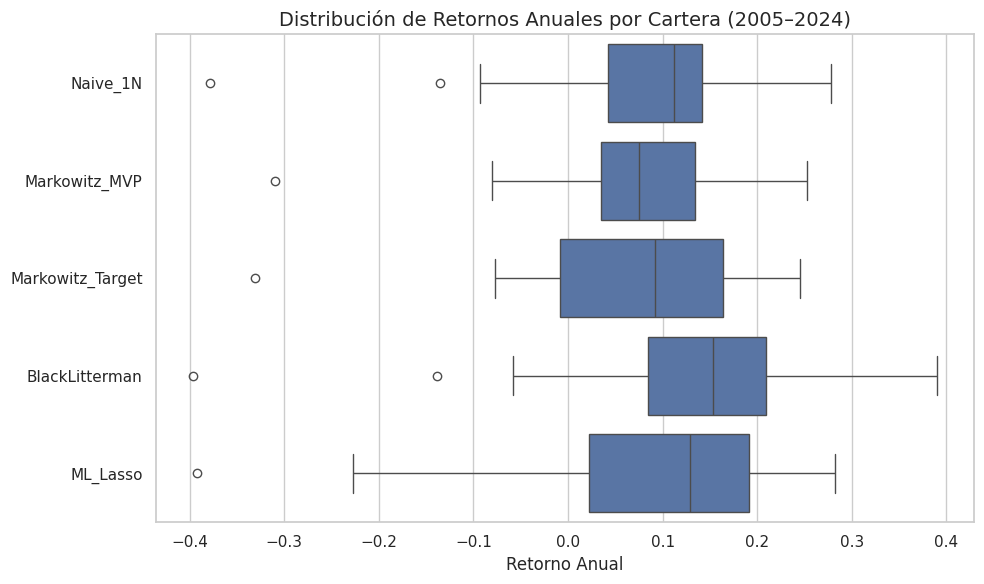

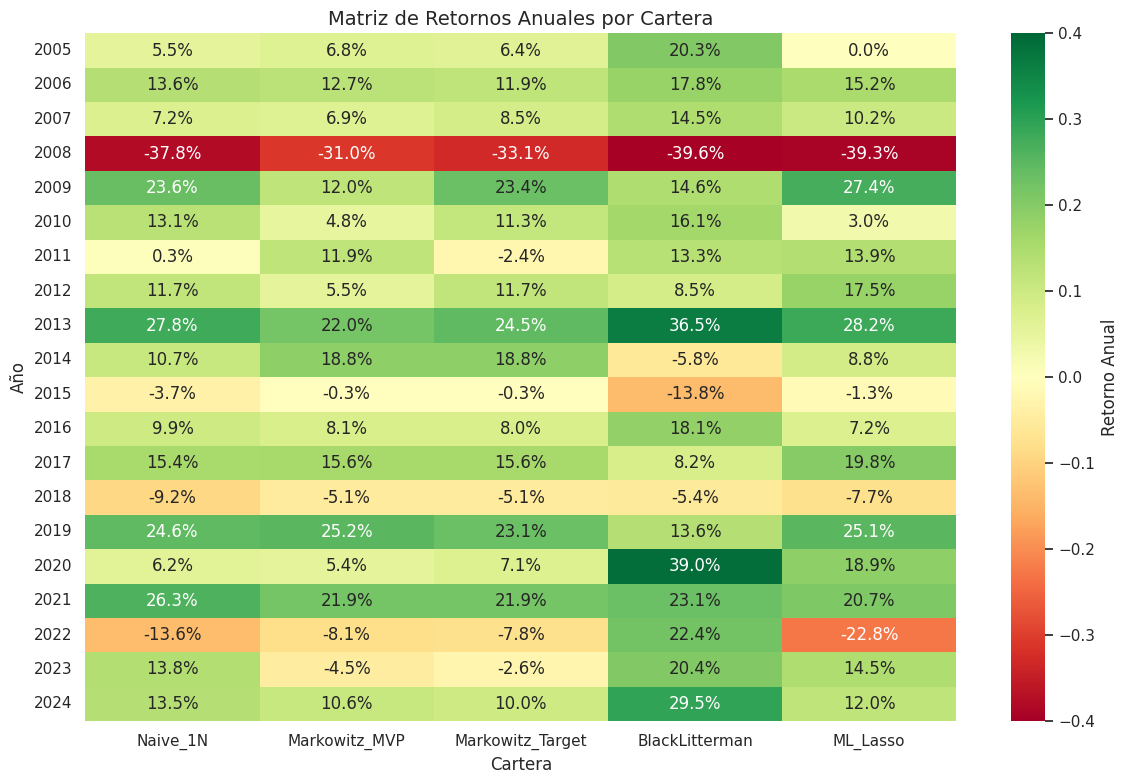

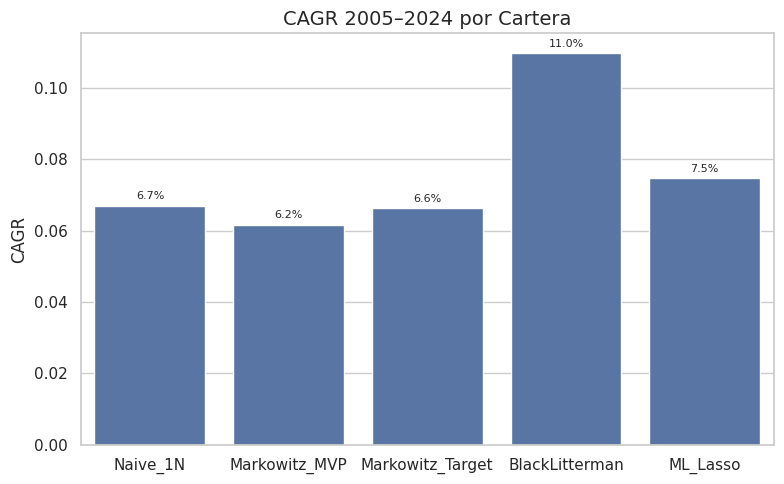


=== Retornos anuales (primeras filas) ===


Naive_1N  Markowitz_MVP  Markowitz_Target  BlackLitterman  ML_Lasso
Año                                                                      
2005  0.055100       0.067800          0.064300        0.203500  0.000000
2006  0.135500       0.127000          0.119200        0.177900  0.151900
2007  0.071900       0.068600          0.084500        0.144700  0.101900
2008 -0.378400      -0.309800         -0.330900       -0.396400 -0.392600
2009  0.235900       0.120100          0.233800        0.146200  0.273600


=== CAGR total 2005–2024 ===


CAGR_2005_2024
Naive_1N                0.067000
Markowitz_MVP           0.061700
Markowitz_Target        0.066400
BlackLitterman          0.109800
ML_Lasso                0.074700


=== Estadísticas descriptivas (anuales) ===


Media  DesvStd       Mín  Mediana      Máx  Años_Pos  Años_Neg  Hit_Rate  Asimetría  Curtosis
Naive_1N         0.079400 0.154200 -0.378400 0.111800 0.278300        16         4  0.800000  -1.425000  3.019600
Markowitz_MVP    0.069700 0.127700 -0.309800 0.074900 0.252200        15         5  0.750000  -1.294700  2.993300
Markowitz_Target 0.075500 0.136700 -0.330900 0.092200 0.245200        14         6  0.700000  -1.317500  2.882600
BlackLitterman   0.125600 0.179000 -0.396400 0.153700 0.389900        16         4  0.800000  -1.349800  2.839500
ML_Lasso         0.085700 0.167500 -0.392600 0.129400 0.281800        15         5  0.750000  -1.515000  2.597400

In [ ]:
# ===========================================================
# 5.3) Retornos anuales por cartera, CAGR total y gráficos
#      (Naïve, Markowitz, BL y ML Lasso)
# ===========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

assert "returns_all_log" in globals(), "Falta returns_all_log (ejecutá 5.1 primero)"

# ----- 1) Preparación: logs -> simples y recorte 2005-2024 -----
# returns_all_log incluye:
# - Naive_1N
# - Markowitz_MVP
# - Markowitz_Target
# - BlackLitterman
# - ML_Lasso
monthly_simple = np.exp(returns_all_log) - 1
monthly_simple = monthly_simple.loc[
    (monthly_simple.index >= "2005-01-01") & (monthly_simple.index <= "2024-12-31")
]

# ----- 2) Retornos anuales (producto de 1+r por año - 1) -----
annual_returns = (
    (1 + monthly_simple)
    .groupby(monthly_simple.index.year)
    .prod()
    .sub(1)
)
annual_returns.index.name = "Año"
annual_returns = annual_returns.round(4)

# ----- 3) CAGR total 2005-2024 por cartera -----
def _cagr_from_monthlies(s):
    """
    Calcula el CAGR a partir de retornos mensuales.
    Para cada cartera:
      - se eliminan NaNs (por ej., ML antes de 2006)
      - se calcula la duración efectiva en años = n_meses / 12
      - CAGR = (∏(1+r))^(1/n_años) - 1
    """
    s = s.dropna()
    if s.empty:
        return np.nan
    n_years = s.shape[0] / 12.0
    return (1 + s).prod() ** (1 / n_years) - 1

cagr_series = pd.Series(
    {col: _cagr_from_monthlies(monthly_simple[col]) for col in monthly_simple.columns},
    name="CAGR_2005_2024",   # para ML será "CAGR en su período disponible dentro de 2005–2024"
).round(4)

# ----- 4) Estadísticas descriptivas sobre retornos anuales -----
stats_df = pd.DataFrame({
    "Media": annual_returns.mean(),
    "DesvStd": annual_returns.std(),
    "Mín": annual_returns.min(),
    "Mediana": annual_returns.median(),
    "Máx": annual_returns.max(),
    "Años_Pos": (annual_returns > 0).sum(),
    "Años_Neg": (annual_returns <= 0).sum(),
    "Hit_Rate": (annual_returns > 0).mean()
})
# Extra: asimetría y curtosis
stats_df["Asimetría"] = annual_returns.skew()
stats_df["Curtosis"]  = annual_returns.kurtosis()
stats_df = stats_df.round(4)

# ----- 5) Guardar Excel -----
excel_out = f"{OUTPUT_DIR}/retornos_anuales_y_cagr_2005_2024.xlsx"
with pd.ExcelWriter(excel_out, engine=EXCEL_ENGINE) as writer:
    annual_returns.to_excel(writer, sheet_name="Retornos_Anuales")
    cagr_series.to_frame().to_excel(writer, sheet_name="CAGR_Total")
    stats_df.to_excel(writer, sheet_name="Estadisticas_Anuales")
    # Long format para gráficos/pivots
    annual_long = annual_returns.reset_index().melt(
        id_vars="Año", var_name="Cartera", value_name="Ret_Anual"
    )
    annual_long.to_excel(writer, sheet_name="Anuales_Long", index=False)

print(f"✅ Excel generado: {excel_out}")
if '_ON_COLAB' in globals() and _ON_COLAB:
    from google.colab import files
    files.download(excel_out)

# ===========================================================
# Gráficos (presentables)
# ===========================================================
sns.set_theme(style="whitegrid")

# Helper para anotar barras con % (p.ej. 12.3%)
def _annotate_bars(ax, fmt="{:.1%}"):
    for p in ax.patches:
        h = p.get_height()
        if np.isfinite(h):
            ax.annotate(fmt.format(h),
                        (p.get_x()+p.get_width()/2., h),
                        ha='center', va='bottom', fontsize=8, rotation=0, xytext=(0,3),
                        textcoords='offset points')

# --- G1: Barras de retornos anuales ---
plt.figure(figsize=(20,8))
annual_long = annual_returns.reset_index().melt(
    id_vars="Año", var_name="Cartera", value_name="Ret_Anual"
)
ax = sns.barplot(
    data=annual_long, x="Año", y="Ret_Anual", hue="Cartera",
    dodge=True, width=0.7
)
plt.title("Retorno Anual por Cartera (2005–2024)", fontsize=16)
plt.ylabel("Retorno Anual")
plt.xlabel("Año")
plt.xticks(rotation=60)
plt.legend(title="Cartera", ncol=2, bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

# --- G2: Líneas por año ---
plt.figure(figsize=(14,6))
for col in annual_returns.columns:
    plt.plot(annual_returns.index, annual_returns[col], marker='o', linewidth=2, label=col)
plt.axhline(0, color='black', linewidth=0.8, alpha=0.6)
plt.title("Evolución del Retorno Anual por Cartera", fontsize=14)
plt.xlabel("Año"); plt.ylabel("Retorno Anual")
plt.legend(ncol=2, bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

# --- G3: Boxplot de retornos anuales ---
plt.figure(figsize=(10,6))
sns.boxplot(data=annual_long, x="Ret_Anual", y="Cartera", orient="h")
plt.title("Distribución de Retornos Anuales por Cartera (2005–2024)", fontsize=14)
plt.xlabel("Retorno Anual"); plt.ylabel("")
plt.tight_layout(); plt.show()

# --- G4: Heatmap de retornos anuales ---
plt.figure(figsize=(12,8))
sns.heatmap(
    annual_returns,
    annot=True, fmt=".1%",
    cmap="RdYlGn", center=0, vmin=-0.4, vmax=0.4,
    cbar_kws={"label": "Retorno Anual"}
)
plt.title("Matriz de Retornos Anuales por Cartera", fontsize=14)
plt.xlabel("Cartera"); plt.ylabel("Año")
plt.tight_layout(); plt.show()

# --- G5: Barras: CAGR total por cartera ---
plt.figure(figsize=(8,5))
ax = sns.barplot(x=cagr_series.index, y=cagr_series.values)
plt.title("CAGR 2005–2024 por Cartera", fontsize=14)
plt.ylabel("CAGR"); plt.xlabel("")
_annotate_bars(ax)
plt.tight_layout(); plt.show()

# ----- (Opcional) Estadísticas impresas en consola -----
print("\n=== Retornos anuales (primeras filas) ===")
display(annual_returns.head())

print("\n=== CAGR total 2005–2024 ===")
display(cagr_series.to_frame())

print("\n=== Estadísticas descriptivas (anuales) ===")
display(stats_df)



✅ Excel generado: ./outputs/volatilidad_anualizada_carteras.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1400x600 with 0 Axes>

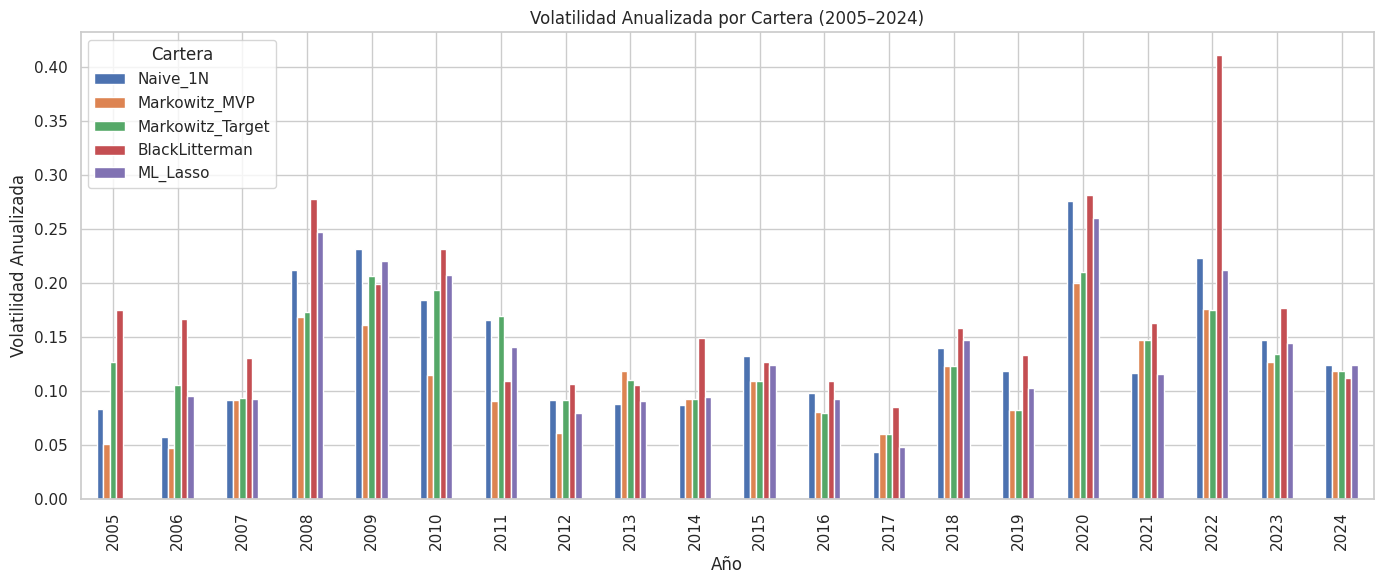

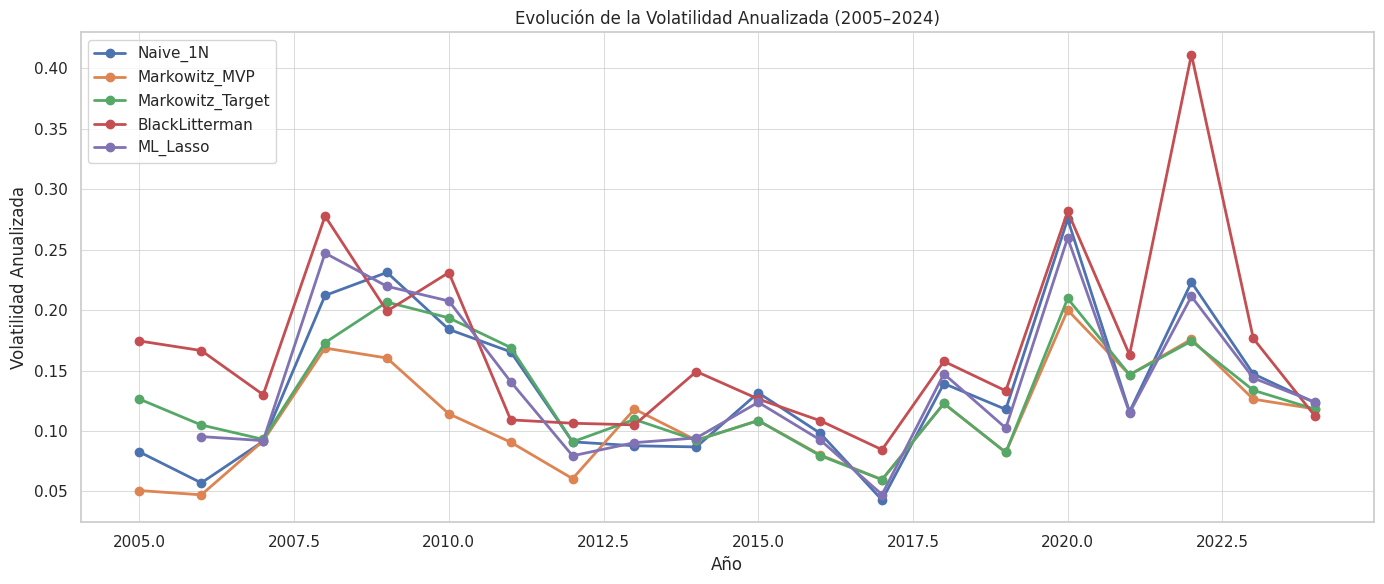

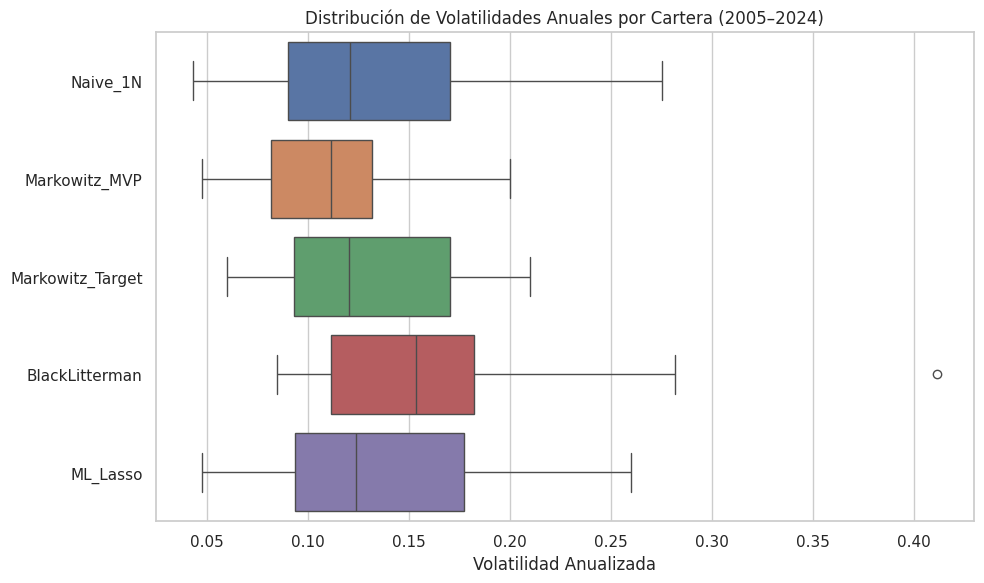

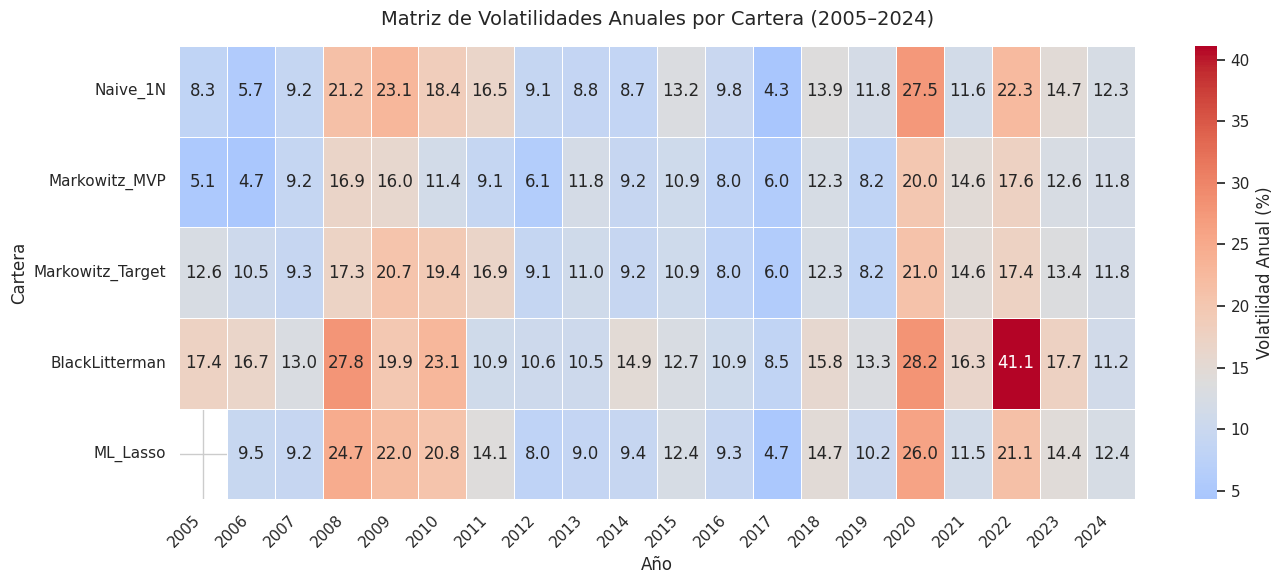

count     mean      std      min       5%      25%      50%      75%      95%      max  skewness  kurtosis
Naive_1N         20.000000 0.135200 0.062400 0.043000 0.056400 0.090200 0.120600 0.170100 0.233400 0.275300  0.733600 -0.162600
Markowitz_MVP    20.000000 0.110800 0.043200 0.047200 0.050600 0.081800 0.111500 0.131400 0.177100 0.200000  0.399800 -0.528000
Markowitz_Target 20.000000 0.129800 0.044500 0.059800 0.078700 0.092900 0.120400 0.170100 0.206800 0.209600  0.457400 -0.882900
BlackLitterman   20.000000 0.170200 0.079100 0.084500 0.104100 0.111400 0.153400 0.182200 0.288100 0.411300  1.757800  3.515800
ML_Lasso         19.000000 0.138600 0.061300 0.047500 0.076300 0.093500 0.123800 0.177400 0.248400 0.259700  0.750000 -0.541900

In [ ]:
# ===========================================================
# 5.4) Volatilidad anualizada por cartera (2005–2024)
#      Incluye: Naïve, Markowitz MVP, Markowitz Target,
#               Black-Litterman y Machine Learning (Lasso)
# ===========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===========================================================
# Diccionario con retornos mensuales por cartera
# ===========================================================
# Se toma directamente desde returns_all_log, que incluye ML_Lasso
# y se convierte a retornos simples para comparabilidad.
monthly_simple_full = np.exp(returns_all_log) - 1

# Recortamos al período de interés
monthly_simple_full = monthly_simple_full.loc[
    (monthly_simple_full.index >= "2005-01-01") &
    (monthly_simple_full.index <= "2024-12-31")
]

# Construir diccionario por cartera
portfolios_returns = {
    col: monthly_simple_full[col].dropna()
    for col in monthly_simple_full.columns
}

# ===========================================================
# 1) Volatilidad anualizada por año
# ===========================================================
vol_anual_dict = {}

for name, series in portfolios_returns.items():
    # std mensual * sqrt(12)
    vol_anual = series.groupby(series.index.year).std() * np.sqrt(12)
    vol_anual_dict[name] = vol_anual

vol_anual_df = pd.DataFrame(vol_anual_dict)

# ===========================================================
# 2) Volatilidad total 2005–2024 por cartera
# ===========================================================
vol_total = {
    name: ret.std() * np.sqrt(12)
    for name, ret in portfolios_returns.items()
}
vol_total = pd.Series(vol_total, name="Volatilidad_Total").sort_values()

# ===========================================================
# 3) Guardar a Excel
# ===========================================================
excel_out = f"{OUTPUT_DIR}/volatilidad_anualizada_carteras.xlsx"
with pd.ExcelWriter(excel_out, engine=EXCEL_ENGINE) as writer:
    vol_anual_df.to_excel(writer, sheet_name="Vol_Anual")
    vol_total.to_excel(writer, sheet_name="Vol_Total")

print(f"\n✅ Excel generado: {excel_out}")
if _ON_COLAB:
    from google.colab import files
    files.download(excel_out)

# ===========================================================
# 4) Visualizaciones
# ===========================================================

# --- G1: Barras por año ---
plt.figure(figsize=(14,6))
vol_anual_df.plot(kind="bar", figsize=(14,6))
plt.title("Volatilidad Anualizada por Cartera (2005–2024)")
plt.ylabel("Volatilidad Anualizada")
plt.xlabel("Año")
plt.legend(title="Cartera")
plt.tight_layout()
plt.show()

# --- G2: Líneas temporales ---
plt.figure(figsize=(14,6))
for col in vol_anual_df.columns:
    plt.plot(vol_anual_df.index, vol_anual_df[col], marker="o", linewidth=2, label=col)
plt.title("Evolución de la Volatilidad Anualizada (2005–2024)")
plt.ylabel("Volatilidad Anualizada")
plt.xlabel("Año")
plt.legend()
plt.grid(True, linewidth=0.5)
plt.tight_layout()
plt.show()

# --- G3: Boxplot comparativo ---
plt.figure(figsize=(10,6))
sns.boxplot(data=vol_anual_df, orient="h")
plt.title("Distribución de Volatilidades Anuales por Cartera (2005–2024)")
plt.xlabel("Volatilidad Anualizada")
plt.tight_layout()
plt.show()

# --- G4: Heatmap ---
plt.figure(figsize=(14,6))

# Pasar a porcentajes
vol_anual_pct = vol_anual_df * 100

# Si todo es NaN, avisamos y no dibujamos un gráfico vacío
if vol_anual_pct.dropna(how="all").empty:
    print("⚠️ vol_anual_df no tiene datos numéricos (solo NaN). No se puede generar el heatmap.")
else:
    # Más robusto: ignorar NaN en el promedio y usar mask
    media_global = np.nanmean(vol_anual_pct.values)

    sns.heatmap(
        vol_anual_pct.T,
        cmap="coolwarm",
        annot=True,
        fmt=".1f",
        linewidths=0.5,
        cbar_kws={'label': 'Volatilidad Anual (%)'},
        center=media_global,
        mask=vol_anual_pct.T.isna()
    )

    plt.title("Matriz de Volatilidades Anuales por Cartera (2005–2024)", fontsize=14, pad=15)
    plt.xlabel("Año", fontsize=12)
    plt.ylabel("Cartera", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# ===========================================================
# 5) Estadísticas descriptivas
# ===========================================================
stats_vol = vol_anual_df.describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).T
stats_vol["skewness"] = vol_anual_df.skew()
stats_vol["kurtosis"] = vol_anual_df.kurtosis()

display(stats_vol.round(4))


Columnas disponibles para Sharpe: ['Naive_1N', 'Markowitz_MVP', 'Markowitz_Target', 'BlackLitterman', 'ML_Lasso']
✅ Excel guardado en: ./outputs/4_5_sharpe_anualizado_2005_2024.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

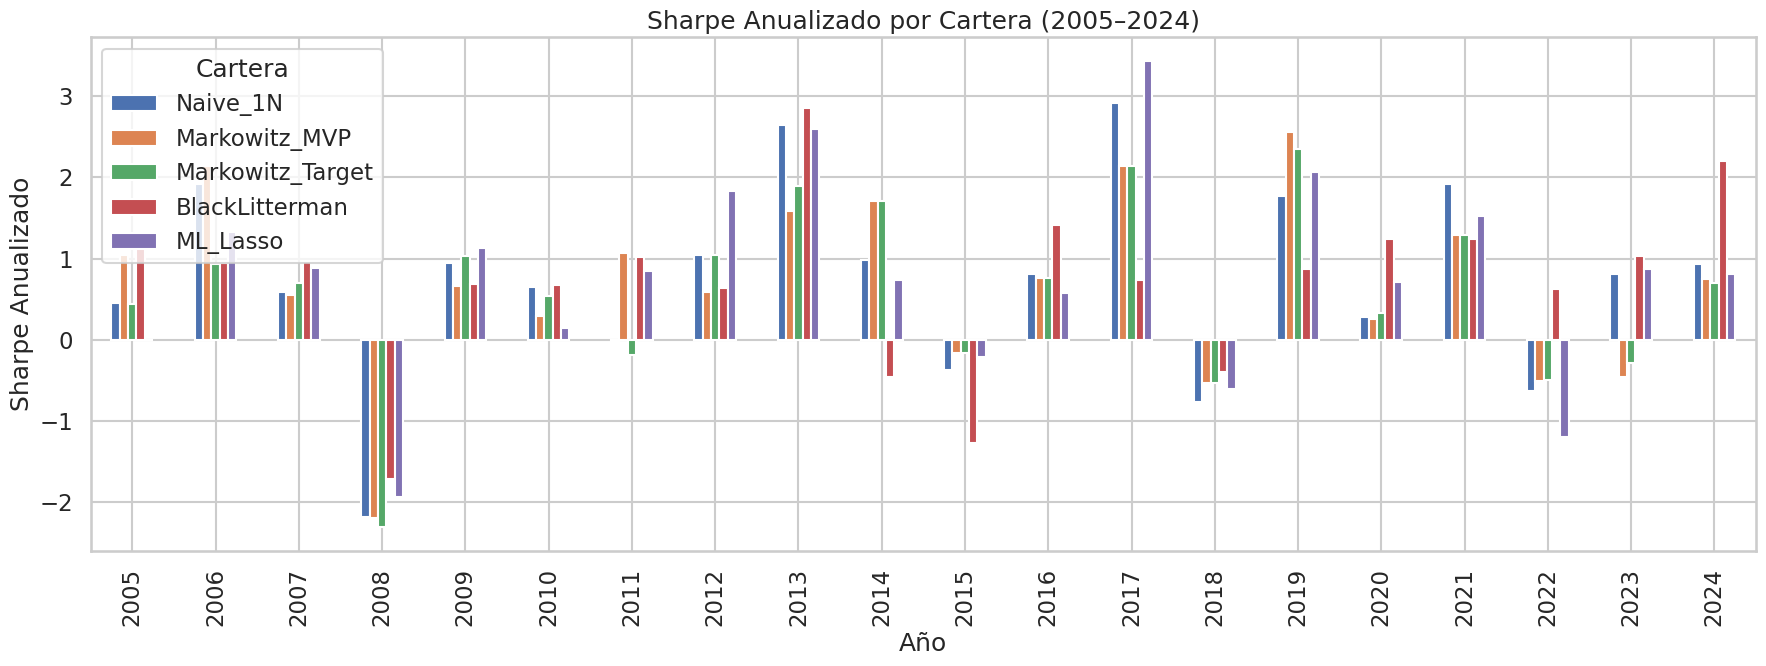

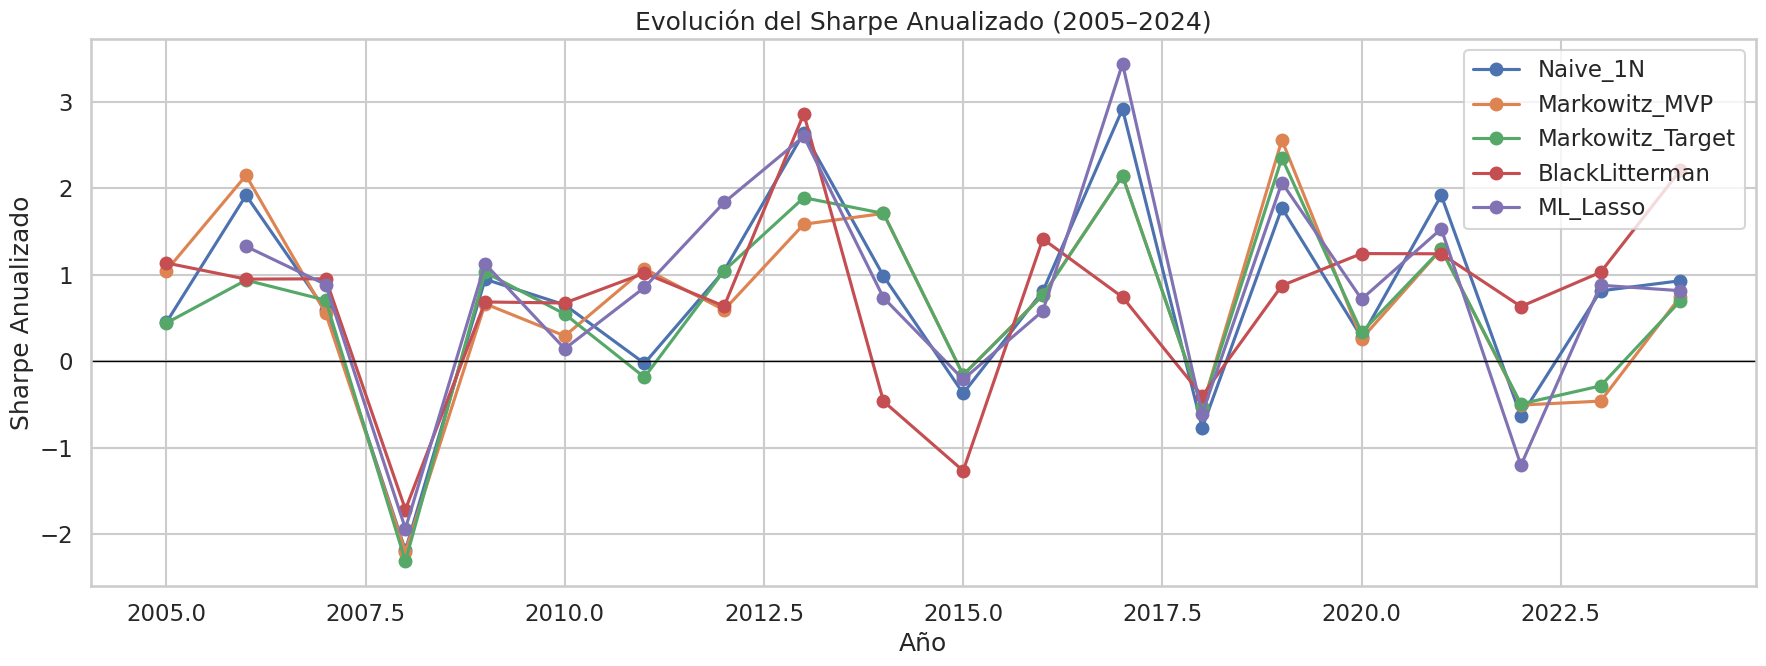

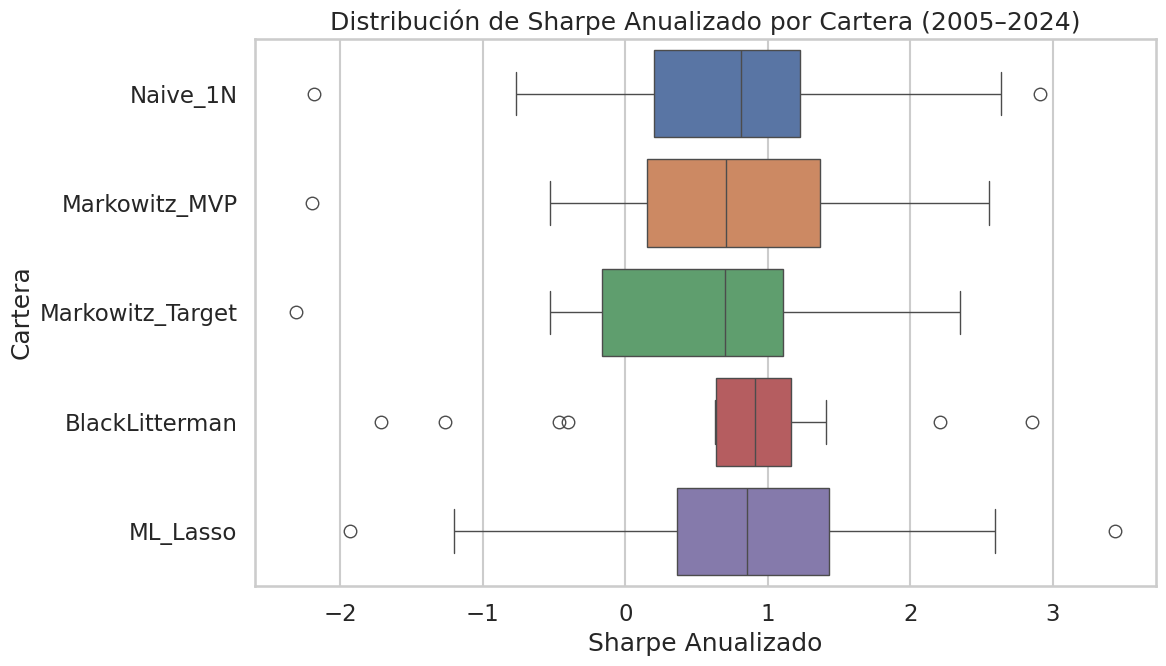

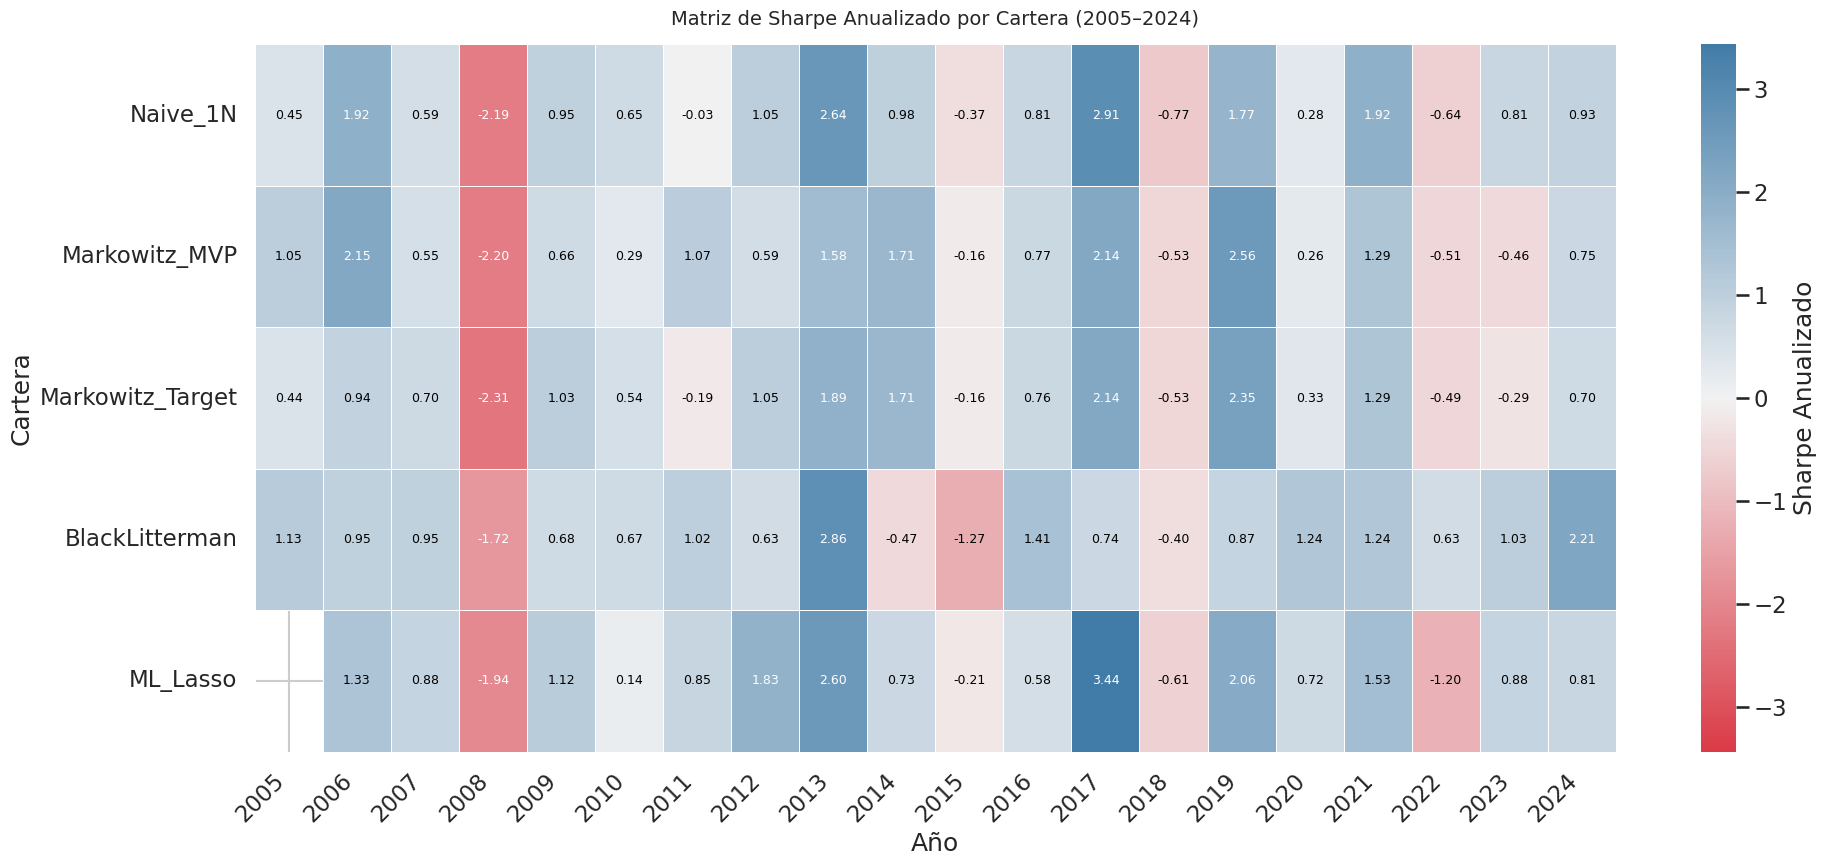

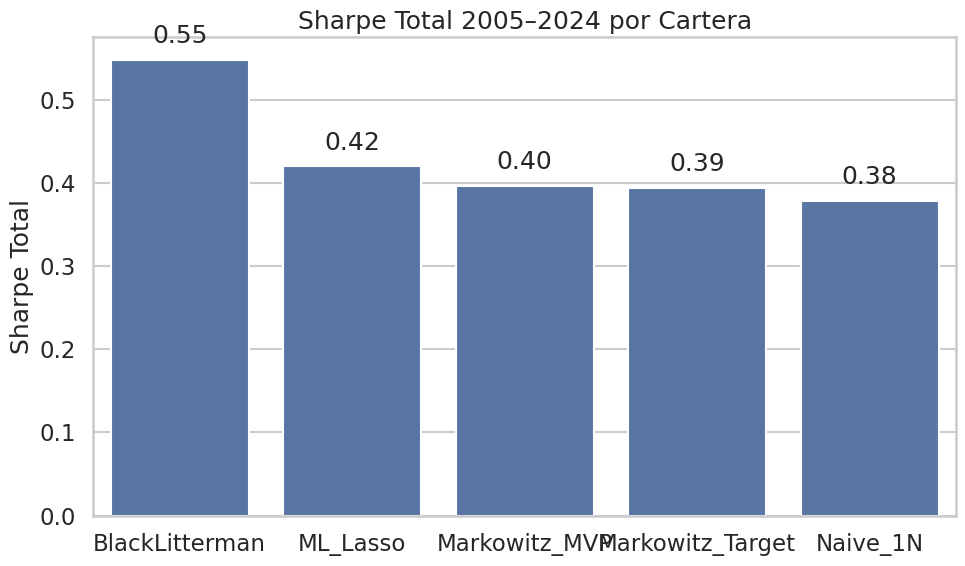


=== Sharpe Total 2005–2024 ===


Sharpe_Total_2005_2024
Naive_1N                        0.379000
Markowitz_MVP                   0.397000
Markowitz_Target                0.394000
BlackLitterman                  0.548000
ML_Lasso                        0.420000


=== Estadísticas descriptivas de Sharpe anual ===


count     mean      std       min        5%       25%      50%      75%      95%      max  skewness  kurtosis  %_años_Sharpe>0  \
Naive_1N         20.000000 0.732000 1.199000 -2.187000 -0.842000  0.201000 0.810000 1.227000 2.653000 2.913000 -0.371000  0.802000        75.000000   
Markowitz_MVP    20.000000 0.677000 1.121000 -2.202000 -0.611000  0.153000 0.704000 1.366000 2.166000 2.555000 -0.596000  0.973000        75.000000   
Markowitz_Target 20.000000 0.595000 1.085000 -2.313000 -0.617000 -0.167000 0.700000 1.108000 2.152000 2.348000 -0.719000  1.441000        70.000000   
BlackLitterman   20.000000 0.721000 1.047000 -1.715000 -1.290000  0.634000 0.910000 1.161000 2.239000 2.858000 -0.591000  1.295000        80.000000   
ML_Lasso         19.000000 0.818000 1.264000 -1.936000 -1.277000  0.361000 0.851000 1.427000 2.681000 3.437000 -0.197000  0.700000        78.900000   

                  %_años_Sharpe>1  
Naive_1N                30.000000  
Markowitz_MVP           40.000000  
Markowitz_Target        35.000000  
BlackLitterman          40.000000  
ML_Lasso                36.800000

In [ ]:
# ============================================
# 5.5) Sharpe anualizado (2005–2024) por cartera
# Incluye: Naive_1N, Markowitz_MVP, Markowitz_Target,
#          BlackLitterman y ML_Lasso
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Parámetros ----------
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = "./outputs"

try:
    EXCEL_ENGINE
except NameError:
    EXCEL_ENGINE = "xlsxwriter"

# Tasa libre de riesgo (ejemplo: 2% anual)
RF_ANUAL = 0.02
RF_MENSUAL = (1 + RF_ANUAL)**(1/12) - 1

# ---------- 1) Retornos mensuales (log) ----------
# Usamos directamente returns_all_log, que YA incluye ML_Lasso
assert "returns_all_log" in globals(), "Falta 'returns_all_log'. Ejecuta antes el paso 5.1."

rets_log = returns_all_log.copy()

# Nos quedamos solo con las columnas esperadas
expected_cols = ["Naive_1N", "Markowitz_MVP", "Markowitz_Target",
                 "BlackLitterman", "ML_Lasso"]
cols_present = [c for c in expected_cols if c in rets_log.columns]
rets_log = rets_log[cols_present]

# Índice datetime y orden
rets_log.index = pd.to_datetime(rets_log.index)
rets_log = rets_log.sort_index()

# Filtrar ventana 2005–2024
mask = (rets_log.index >= "2005-01-01") & (rets_log.index <= "2024-12-31")
rets_log = rets_log.loc[mask].dropna(how="all")

# Convertir log-returns a retornos simples
rets_simple = np.exp(rets_log) - 1

# Excesos de retorno (sobre rf mensual)
excess = rets_simple - RF_MENSUAL

# ---------- 2) Sharpe por año ----------
def sharpe_annualized(group):
    mu = group.mean()
    sd = group.std(ddof=1)
    sr = mu / sd
    sr = sr.replace([np.inf, -np.inf], np.nan)
    return sr * np.sqrt(12)

sharpe_anual_df = excess.groupby(excess.index.year).apply(sharpe_annualized)
sharpe_anual_df.index.name = "Año"
sharpe_anual_df = sharpe_anual_df.loc[2005:2024]

# ---------- 3) Sharpe total ----------
mu_tot = excess.mean()
sd_tot = excess.std(ddof=1)
sharpe_total = (mu_tot / sd_tot) * np.sqrt(12)
sharpe_total = sharpe_total.replace([np.inf, -np.inf], np.nan)
sharpe_total.name = "Sharpe_Total_2005_2024"
sharpe_total_df = sharpe_total.to_frame()

# ---------- 4) Estadísticas descriptivas ----------
stats = sharpe_anual_df.describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).T
stats["skewness"] = sharpe_anual_df.skew()
stats["kurtosis"] = sharpe_anual_df.kurtosis()
stats["%_años_Sharpe>0"] = ((sharpe_anual_df > 0).sum() / sharpe_anual_df.notna().sum() * 100).round(1)
stats["%_años_Sharpe>1"] = ((sharpe_anual_df > 1).sum() / sharpe_anual_df.notna().sum() * 100).round(1)

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Columnas disponibles para Sharpe:", list(rets_log.columns))
if sharpe_anual_df.empty:
    print("⚠️ 'sharpe_anual_df' está vacío. Revisa el filtrado por fechas o columnas.")

# ---------- 5) Guardar a Excel ----------
excel_out = f"{OUTPUT_DIR}/4_5_sharpe_anualizado_2005_2024.xlsx"
try:
    with pd.ExcelWriter(excel_out, engine=EXCEL_ENGINE) as writer:
        sharpe_anual_df.to_excel(writer, sheet_name="Sharpe_Anual")
        sharpe_total_df.to_excel(writer, sheet_name="Sharpe_Total")
        stats.round(4).to_excel(writer, sheet_name="Estadisticas")

        params_df = pd.DataFrame(
            {"Parametro": ["RF_ANUAL","RF_MENSUAL"],
             "Valor":     [RF_ANUAL,  RF_MENSUAL]}
        )
        params_df.to_excel(writer, sheet_name="Parametros", index=False)

    print(f"✅ Excel guardado en: {excel_out}")

    # Descarga automática en Colab (si aplica)
    try:
        from google.colab import files
        files.download(excel_out)
    except Exception:
        pass

except Exception as e:
    print("❌ No se pudo escribir el Excel. Detalle del error:\n", repr(e))


# ---------- 6) Gráficos ----------
sns.set_style("whitegrid")
sns.set_context("talk")

# G1) Barras por año
plt.figure(figsize=(18,7))
sharpe_anual_df.plot(kind="bar", ax=plt.gca())
plt.title("Sharpe Anualizado por Cartera (2005–2024)")
plt.xlabel("Año"); plt.ylabel("Sharpe Anualizado")
plt.legend(title="Cartera", loc="upper left")
plt.tight_layout(); plt.show()

# G2) Evolución temporal (líneas)
plt.figure(figsize=(18,7))
for col in sharpe_anual_df.columns:
    plt.plot(sharpe_anual_df.index, sharpe_anual_df[col], marker="o", label=col)
plt.axhline(0, color="black", linewidth=1)
plt.title("Evolución del Sharpe Anualizado (2005–2024)")
plt.xlabel("Año"); plt.ylabel("Sharpe Anualizado")
plt.legend(); plt.tight_layout(); plt.show()

# G3) Boxplot
plt.figure(figsize=(12,7))
sns.boxplot(data=sharpe_anual_df, orient="h")
plt.title("Distribución de Sharpe Anualizado por Cartera (2005–2024)")
plt.xlabel("Sharpe Anualizado"); plt.ylabel("Cartera")
plt.tight_layout(); plt.show()

# G4) Heatmap Sharpe (mejorado)
M = sharpe_anual_df.T.copy()
vmax = np.nanmax(np.abs(M.values))
vmin = -vmax
cmap = sns.diverging_palette(10, 240, as_cmap=True)
mask = M.isna()

plt.figure(figsize=(20, 9))
ax = sns.heatmap(
    M,
    cmap=cmap,
    vmin=vmin, vmax=vmax, center=0,
    mask=mask,
    linewidths=0.6, linecolor="white",
    cbar_kws={"label": "Sharpe Anualizado"},
    annot=False
)

thr = vmax * 0.45
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        val = M.iat[i, j]
        if np.isnan(val):
            continue
        txt_color = "white" if abs(val) >= thr else "black"
        ax.text(j + 0.5, i + 0.5, f"{val:.2f}",
                ha="center", va="center", color=txt_color, fontsize=9)

ax.set_title("Matriz de Sharpe Anualizado por Cartera (2005–2024)", pad=14, fontsize=14)
ax.set_xlabel("Año"); ax.set_ylabel("Cartera")
years = M.columns.to_list()
ax.set_xticks(np.arange(len(years)) + 0.5)
ax.set_xticklabels(years, rotation=45, ha="right")
ax.set_yticks(np.arange(len(M.index)) + 0.5)
ax.set_yticklabels(M.index, rotation=0)

plt.tight_layout()
plt.show()

# G5) Sharpe total
plt.figure(figsize=(10,6))
order_total = sharpe_total_df.sort_values("Sharpe_Total_2005_2024", ascending=False)
sns.barplot(x=order_total.index, y=order_total["Sharpe_Total_2005_2024"].values)
for i, v in enumerate(order_total["Sharpe_Total_2005_2024"].values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center")
plt.title("Sharpe Total 2005–2024 por Cartera")
plt.ylabel("Sharpe Total"); plt.xlabel("")
plt.tight_layout(); plt.show()

# ---------- 7) Resumen ----------
print("\n=== Sharpe Total 2005–2024 ===")
display(sharpe_total_df.round(3))

print("\n=== Estadísticas descriptivas de Sharpe anual ===")
display(stats.round(3))


✅ Excel guardado en: ./outputs/4_6_mdd_carteras.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

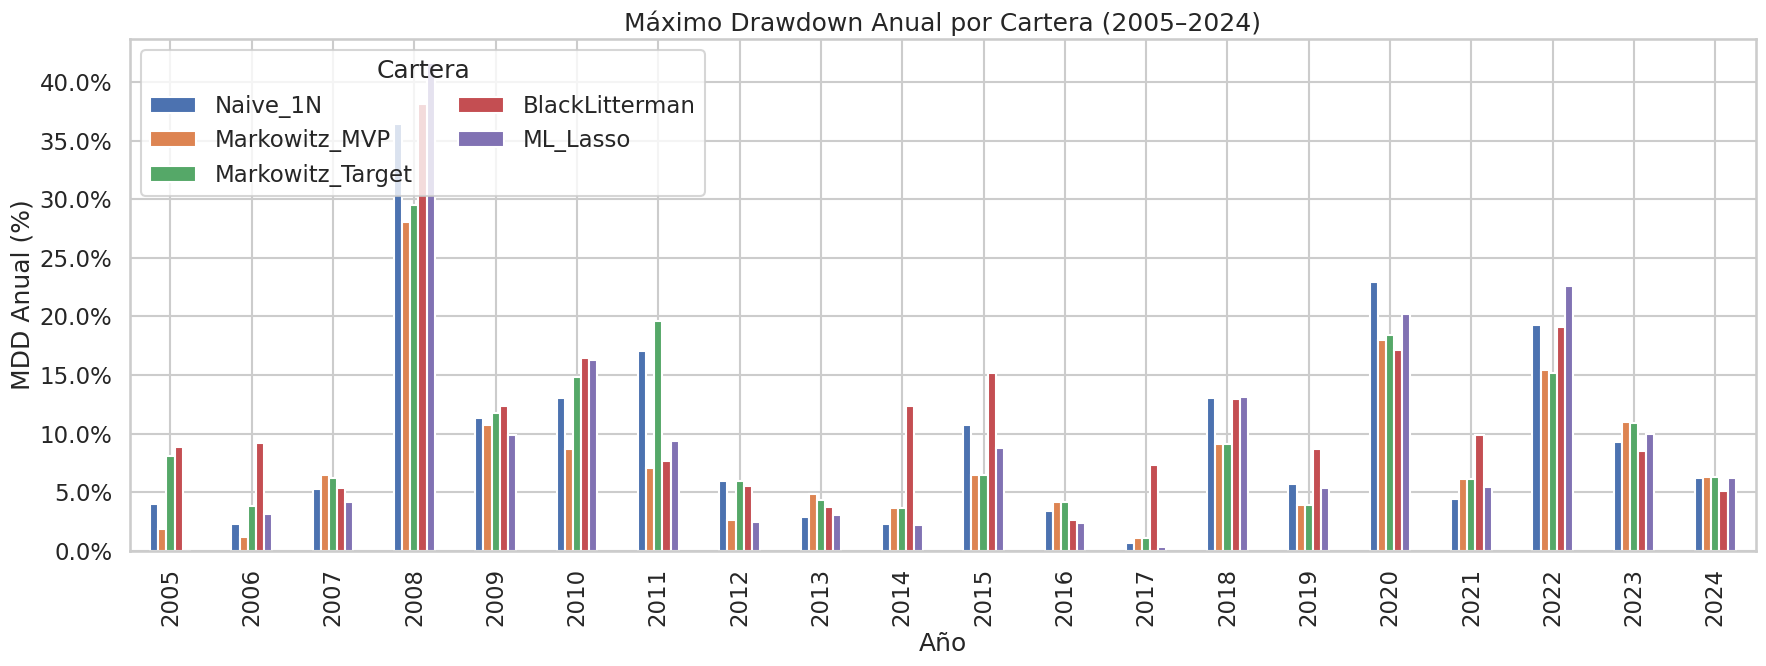

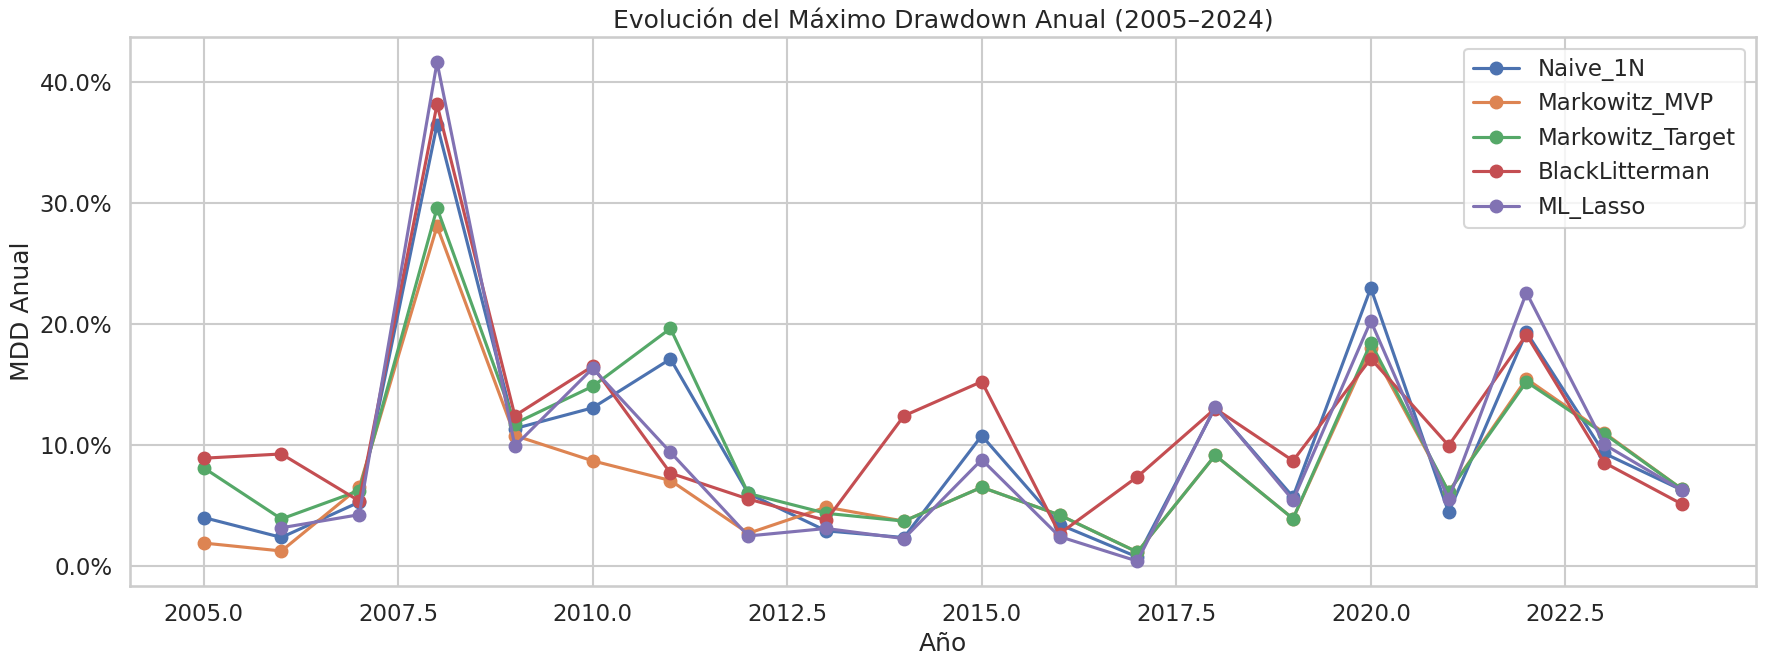

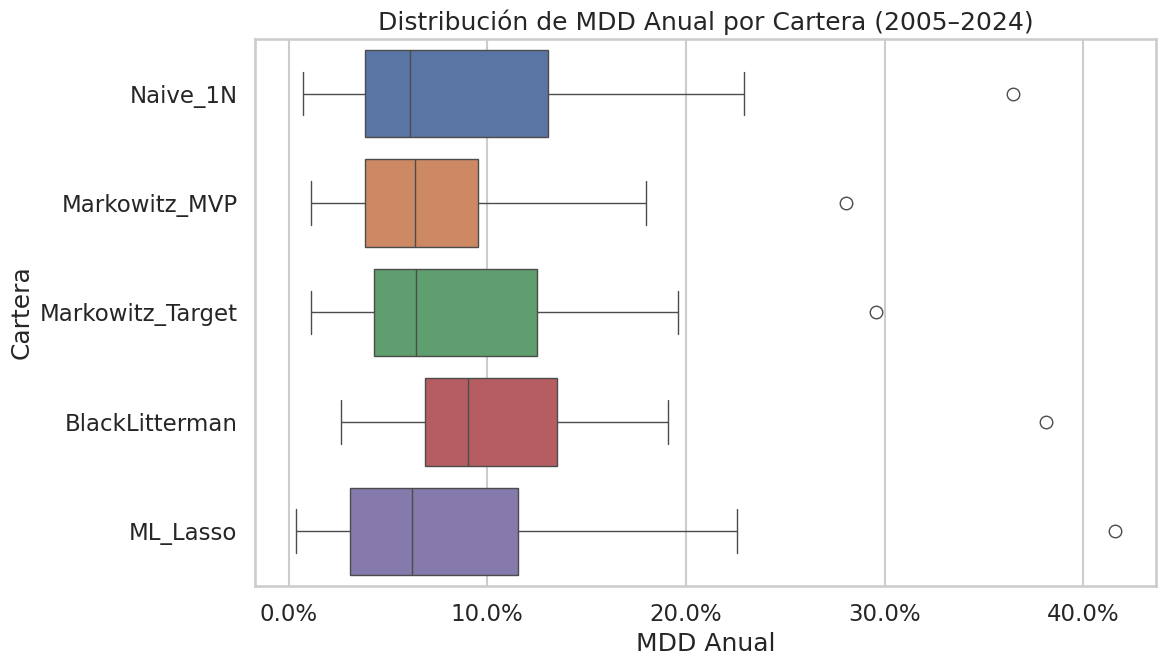

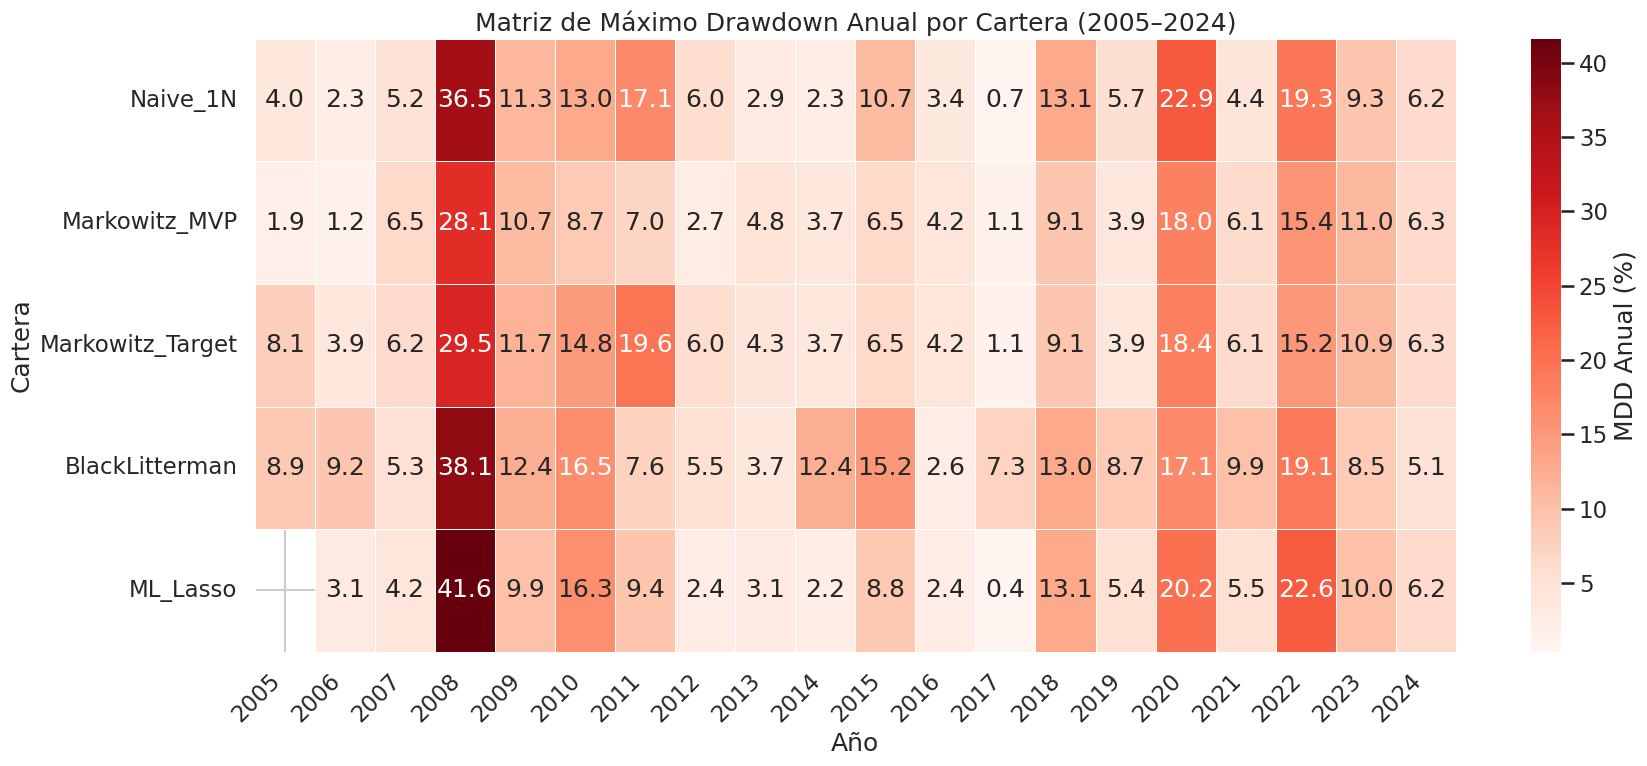

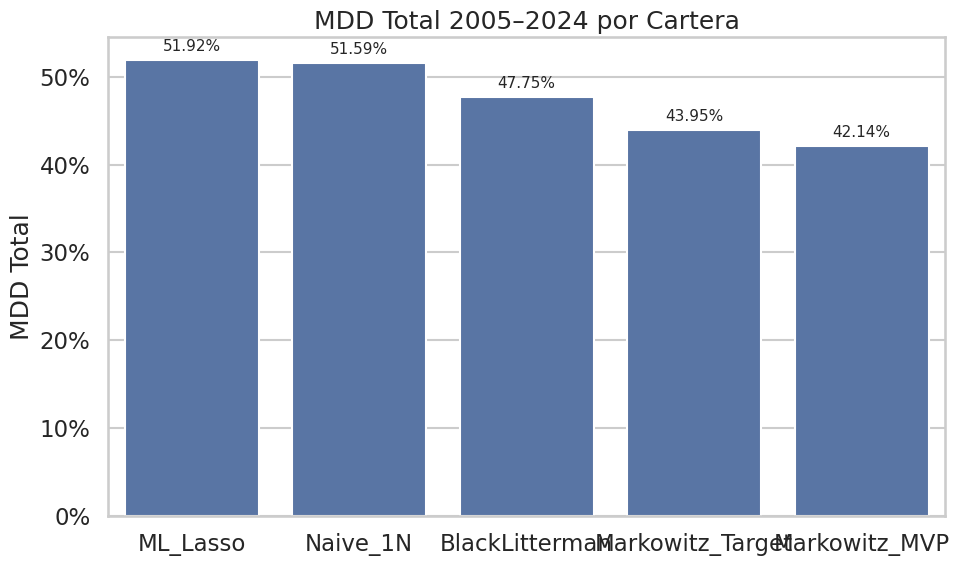

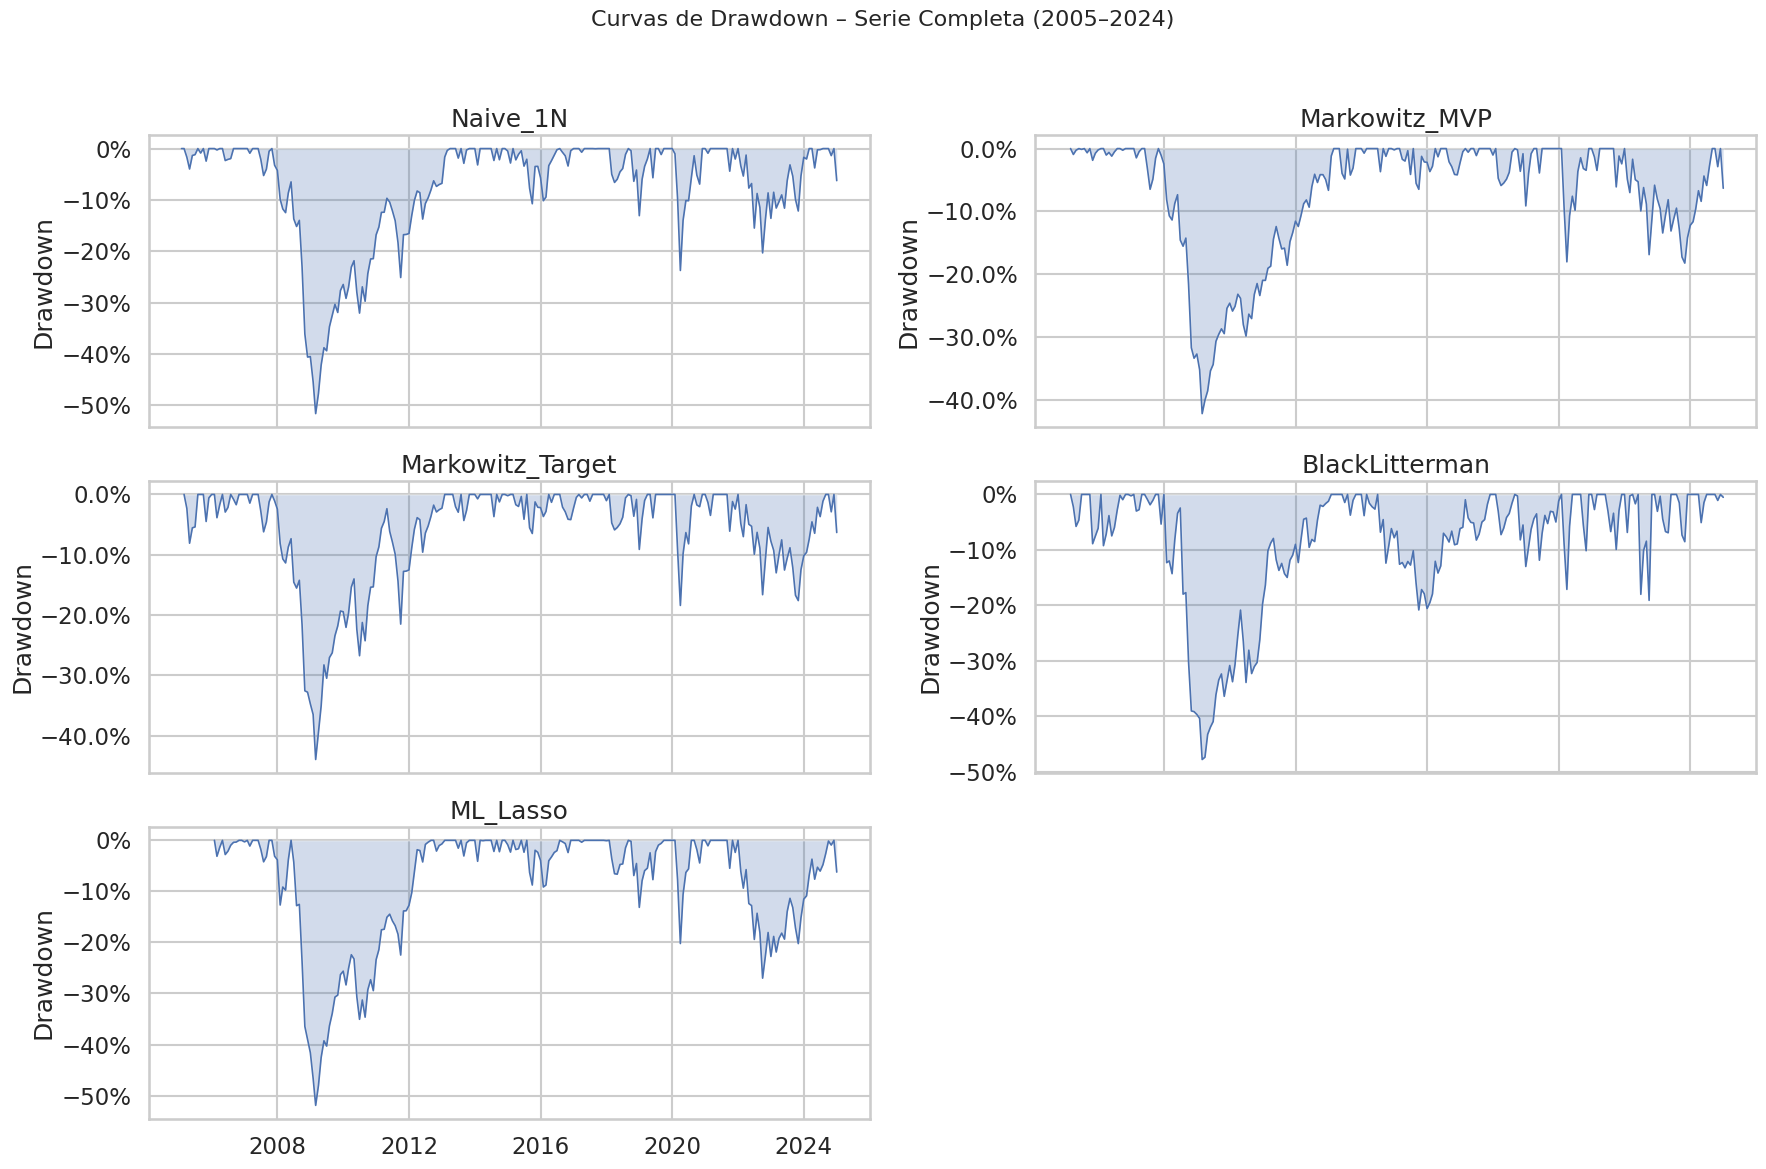

In [ ]:
# ===========================================================
# 5.6) Máximo Drawdown (MDD) por cartera – Anual y Total
#      Incluye: Naive_1N, Markowitz_MVP, Markowitz_Target,
#               BlackLitterman y ML_Lasso
# ===========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# ---------- Parámetros / paths ----------
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = "./outputs"

try:
    EXCEL_ENGINE
except NameError:
    EXCEL_ENGINE = "xlsxwriter"

# ---------- 1) Retornos mensuales (log) ----------
# Usamos directamente returns_all_log, que ya incluye ML_Lasso
assert "returns_all_log" in globals(), "Falta 'returns_all_log'. Ejecuta antes el paso 5.1."

rets_log = returns_all_log.copy()

expected = ["Naive_1N", "Markowitz_MVP", "Markowitz_Target",
            "BlackLitterman", "ML_Lasso"]
cols_present = [c for c in expected if c in rets_log.columns]
rets_log = rets_log[cols_present]

rets_log.index = pd.to_datetime(rets_log.index)
rets_log = rets_log.sort_index()
rets_log = rets_log.loc["2005-01-01":"2024-12-31"]

# ---------- 2) Funciones de MDD ----------
def _mdd_from_simple(returns_simple: pd.Series) -> float:
    """Máximo drawdown (magnitud positiva)."""
    if returns_simple.empty:
        return np.nan
    wealth = (1 + returns_simple).cumprod()
    roll_max = wealth.cummax()
    dd = wealth / roll_max - 1.0         # serie (≤ 0)
    return float(-dd.min())              # magnitud positiva

def mdd_anual_desde_log(rlog: pd.Series) -> pd.Series:
    """MDD por año (usando solo datos dentro de cada año)."""
    def _per_year(group):
        rs = np.exp(group.dropna()) - 1
        return _mdd_from_simple(rs)
    return rlog.groupby(rlog.index.year).apply(_per_year)

def mdd_total_desde_log(rlog: pd.Series):
    """Serie de drawdown completa (negativa) y MDD total (positivo)."""
    rs = np.exp(rlog.dropna()) - 1
    if rs.empty:
        return pd.Series(dtype=float), np.nan
    wealth = (1 + rs).cumprod()
    roll_max = wealth.cummax()
    dd = wealth / roll_max - 1.0         # serie (≤ 0)
    mdd_total = float(-dd.min())
    return dd, mdd_total

# ---------- 3) Cálculo por cartera ----------
mdd_anual_dict = {}
mdd_total_dict = {}
dd_series_dict = {}

for col in rets_log.columns:
    mdd_anual_dict[col] = mdd_anual_desde_log(rets_log[col])
    dd_curve, mdd_tot = mdd_total_desde_log(rets_log[col])
    mdd_total_dict[col] = mdd_tot
    dd_series_dict[col] = dd_curve  # serie negativa (para curvas de DD)

mdd_anual_df = pd.DataFrame(mdd_anual_dict)           # filas: año | cols: carteras
mdd_total_ser = pd.Series(mdd_total_dict, name="MDD_Total_2005_2024")

# ---------- 4) Estadísticas descriptivas ----------
stats = mdd_anual_df.describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).T
stats["skewness"] = mdd_anual_df.skew()
stats["kurtosis"]  = mdd_anual_df.kurtosis()

# Peor/mejor año y frecuencia de años "duros"
worst_year, worst_val, best_year, best_val = {}, {}, {}, {}
pcts = {}
for col in mdd_anual_df.columns:
    s = mdd_anual_df[col].dropna()
    if s.empty:
        worst_year[col] = best_year[col] = np.nan
        worst_val[col]  = best_val[col]  = np.nan
    else:
        worst_year[col] = int(s.idxmax())
        worst_val[col]  = float(s.max())
        best_year[col]  = int(s.idxmin())
        best_val[col]   = float(s.min())
    pcts[col] = {
        "%_años_MDD>10%": (mdd_anual_df[col].gt(0.10).mean() * 100),
        "%_años_MDD>20%": (mdd_anual_df[col].gt(0.20).mean() * 100),
        "%_años_MDD>30%": (mdd_anual_df[col].gt(0.30).mean() * 100),
    }

stats["Peor_Año"]   = pd.Series(worst_year)
stats["MDD_Peor"]   = pd.Series(worst_val)
stats["Mejor_Año"]  = pd.Series(best_year)
stats["MDD_Mejor"]  = pd.Series(best_val)
for k in ["%_años_MDD>10%","%_años_MDD>20%","%_años_MDD>30%"]:
    stats[k] = pd.Series({c: v[k] for c,v in pcts.items()}).round(1)

# ---------- 5) Exportar a Excel ----------
dd_matrix = pd.concat(dd_series_dict, axis=1)  # columnas: MultiIndex (cartera)

excel_out = f"{OUTPUT_DIR}/4_6_mdd_carteras.xlsx"
with pd.ExcelWriter(excel_out, engine=EXCEL_ENGINE) as writer:
    mdd_anual_df.to_excel(writer, sheet_name="MDD_Anual")
    mdd_total_ser.to_frame().to_excel(writer, sheet_name="MDD_Total")
    stats.round(4).to_excel(writer, sheet_name="Estadisticas")
    dd_matrix.to_excel(writer, sheet_name="Drawdown_Series")

print(f"✅ Excel guardado en: {excel_out}")

# Descarga (Colab)
try:
    from google.colab import files
    files.download(excel_out)
except Exception:
    pass

# ---------- 6) Gráficos ----------
sns.set_style("whitegrid")
sns.set_context("talk")

# G1) Barras por año
plt.figure(figsize=(18,7))
(mdd_anual_df*100).plot(kind="bar", ax=plt.gca())
plt.title("Máximo Drawdown Anual por Cartera (2005–2024)")
plt.ylabel("MDD Anual (%)"); plt.xlabel("Año")
plt.legend(title="Cartera", loc="upper left", ncol=2)
plt.gca().yaxis.set_major_formatter(PercentFormatter(100))
plt.tight_layout(); plt.show()

# G2) Evolución temporal (líneas)
plt.figure(figsize=(18,7))
for col in mdd_anual_df.columns:
    plt.plot(mdd_anual_df.index, mdd_anual_df[col], marker="o", label=col)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.title("Evolución del Máximo Drawdown Anual (2005–2024)")
plt.xlabel("Año"); plt.ylabel("MDD Anual")
plt.legend(); plt.tight_layout(); plt.show()

# G3) Boxplot comparativo
plt.figure(figsize=(12,7))
sns.boxplot(data=mdd_anual_df, orient="h")
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.title("Distribución de MDD Anual por Cartera (2005–2024)")
plt.xlabel("MDD Anual"); plt.ylabel("Cartera")
plt.tight_layout(); plt.show()

# G4) Heatmap (en % con anotación)
plt.figure(figsize=(18,8))
mdd_pct = (mdd_anual_df*100).round(1)
sns.heatmap(
    mdd_pct.T, cmap="Reds", annot=True, fmt=".1f",
    linewidths=.5, cbar_kws={"label":"MDD Anual (%)"}
)
plt.title("Matriz de Máximo Drawdown Anual por Cartera (2005–2024)")
plt.xlabel("Año"); plt.ylabel("Cartera")
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

# G5) MDD Total 2005–2024 (barras)
plt.figure(figsize=(10,6))
order = mdd_total_ser.sort_values(ascending=False)
sns.barplot(x=order.index, y=order.values)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
for i,v in enumerate(order.values):
    plt.text(i, v+0.01, f"{v:.2%}", ha="center", fontsize=11)
plt.title("MDD Total 2005–2024 por Cartera")
plt.ylabel("MDD Total"); plt.xlabel("")
plt.tight_layout(); plt.show()

# G6) Curvas de drawdown (serie completa, layout dinámico)
n_strats = len(dd_series_dict)
n_cols = 2
n_rows = int(np.ceil(n_strats / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows), sharex=True)
axes = np.atleast_1d(axes).flatten()

for ax, (name, dd) in zip(axes, dd_series_dict.items()):
    ax.plot(dd.index, dd.values, lw=1.2)
    ax.fill_between(dd.index, dd.values, 0, alpha=0.25)
    ax.set_title(name)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.set_ylabel("Drawdown")

# Eliminar ejes sobrantes si hay
for j in range(len(dd_series_dict), len(axes)):
    fig.delaxes(axes[j])

axes[-1].set_xlabel("Fecha")
fig.suptitle("Curvas de Drawdown – Serie Completa (2005–2024)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96]); plt.show()


Naive_1N  Markowitz_MVP  Markowitz_Target  BlackLitterman  ML_Lasso
Año                                                                      
2005  0.000000       0.047733          0.055058        0.139525       NaN
2006  0.000000       0.060448          0.077864        0.130410  0.057116
2007  0.000000       0.031637          0.029127        0.107356  0.014181
2008  0.000000       0.065171          0.085221        0.217396  0.129735
2009  0.000000       0.112560          0.111702        0.129308  0.040651

Naive_1N  Markowitz_MVP  Markowitz_Target  BlackLitterman  ML_Lasso
TE_Total_2005_2024  0.000000       0.072836          0.063707        0.128300  0.046369

count     mean      std      min       5%      25%      50%      75%      95%      max  skewness  kurtosis  %_años_TE<5%  %_años_TE<10%
Naive_1N         20.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000  0.000000  0.000000    100.000000     100.000000
Markowitz_MVP    20.000000 0.068600 0.026100 0.029900 0.030500 0.049000 0.066000 0.084000 0.111800 0.112600  0.193300 -0.800400     30.000000      85.000000
Markowitz_Target 20.000000 0.058100 0.029600 0.000000 0.018800 0.033100 0.054500 0.081700 0.103500 0.111700 -0.007400 -0.659900     40.000000      90.000000
BlackLitterman   20.000000 0.117500 0.052300 0.031200 0.054600 0.091500 0.114800 0.134100 0.219800 0.265000  1.243500  2.792600      5.000000      35.000000
ML_Lasso         19.000000 0.037500 0.026200 0.010900 0.012600 0.024500 0.033700 0.040300 0.065500 0.129700  2.528300  8.579300     84.200000      94.700000

✅ Excel guardado en: ./outputs/4_7_tracking_error_vs_1N_2005_2024.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

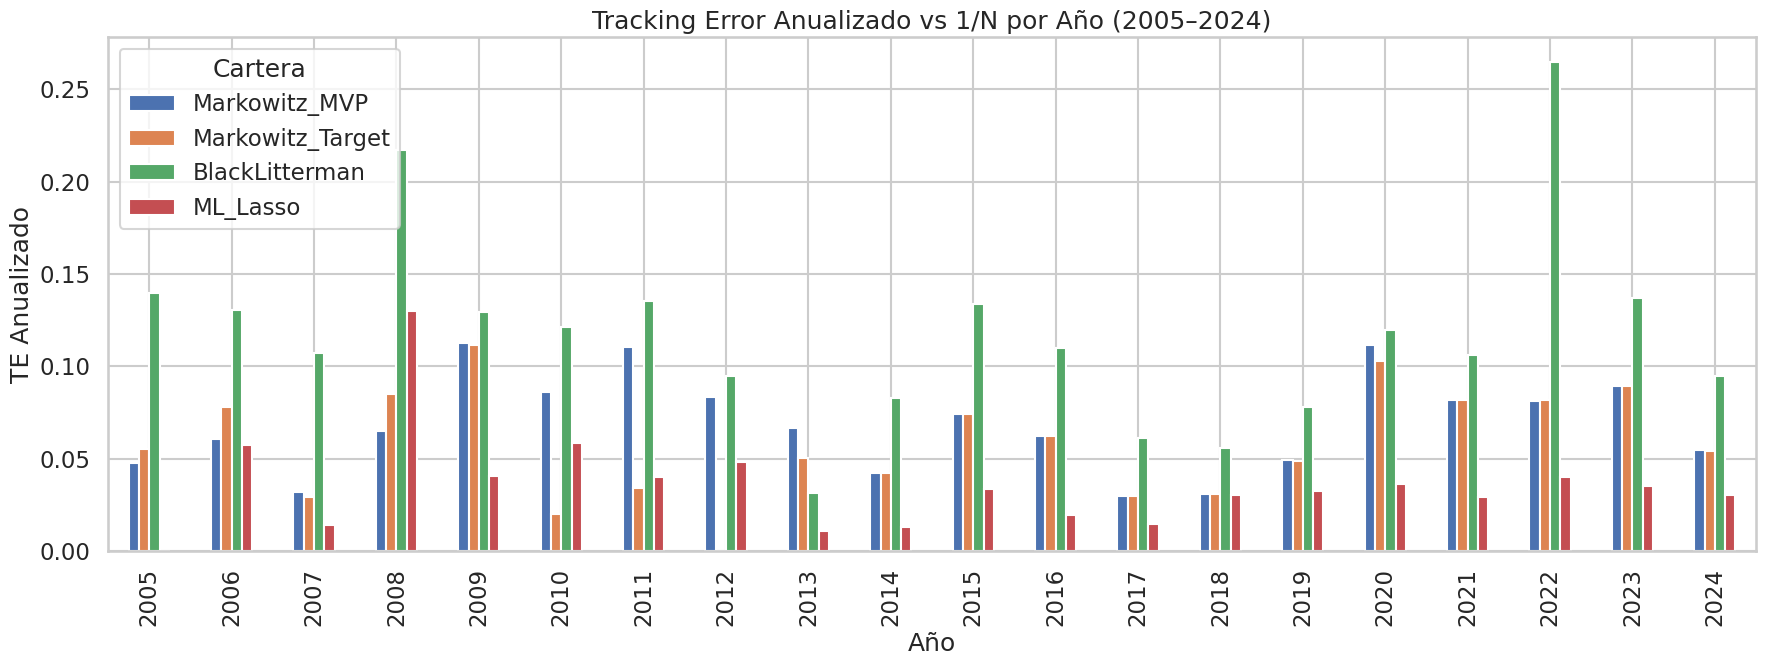

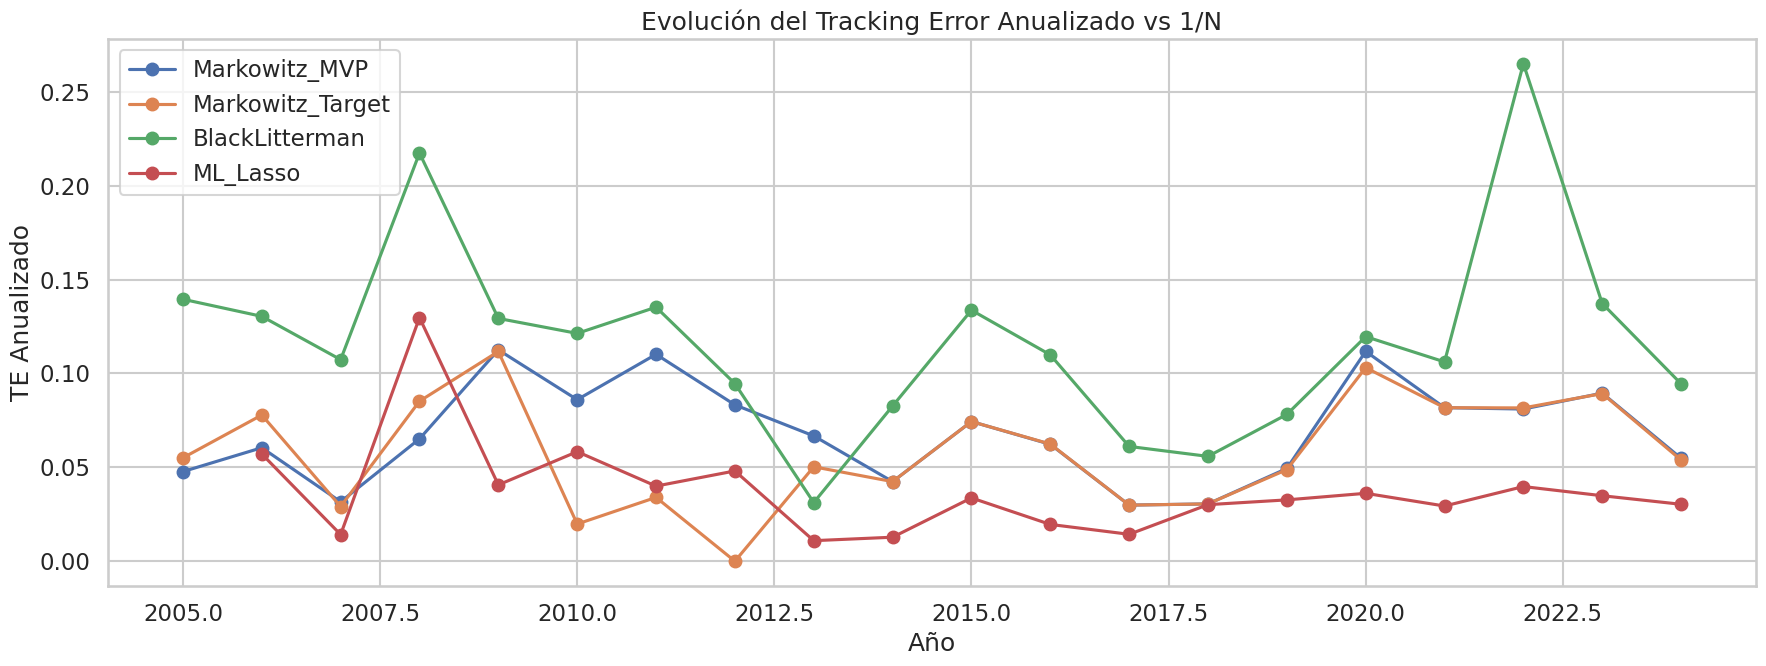

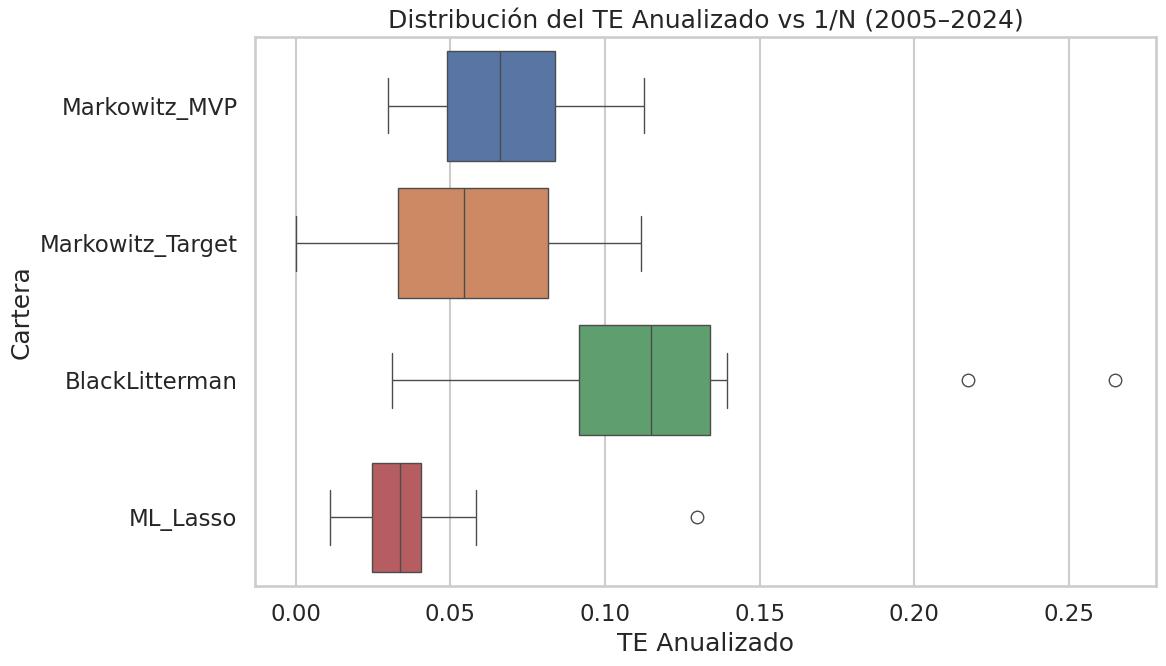

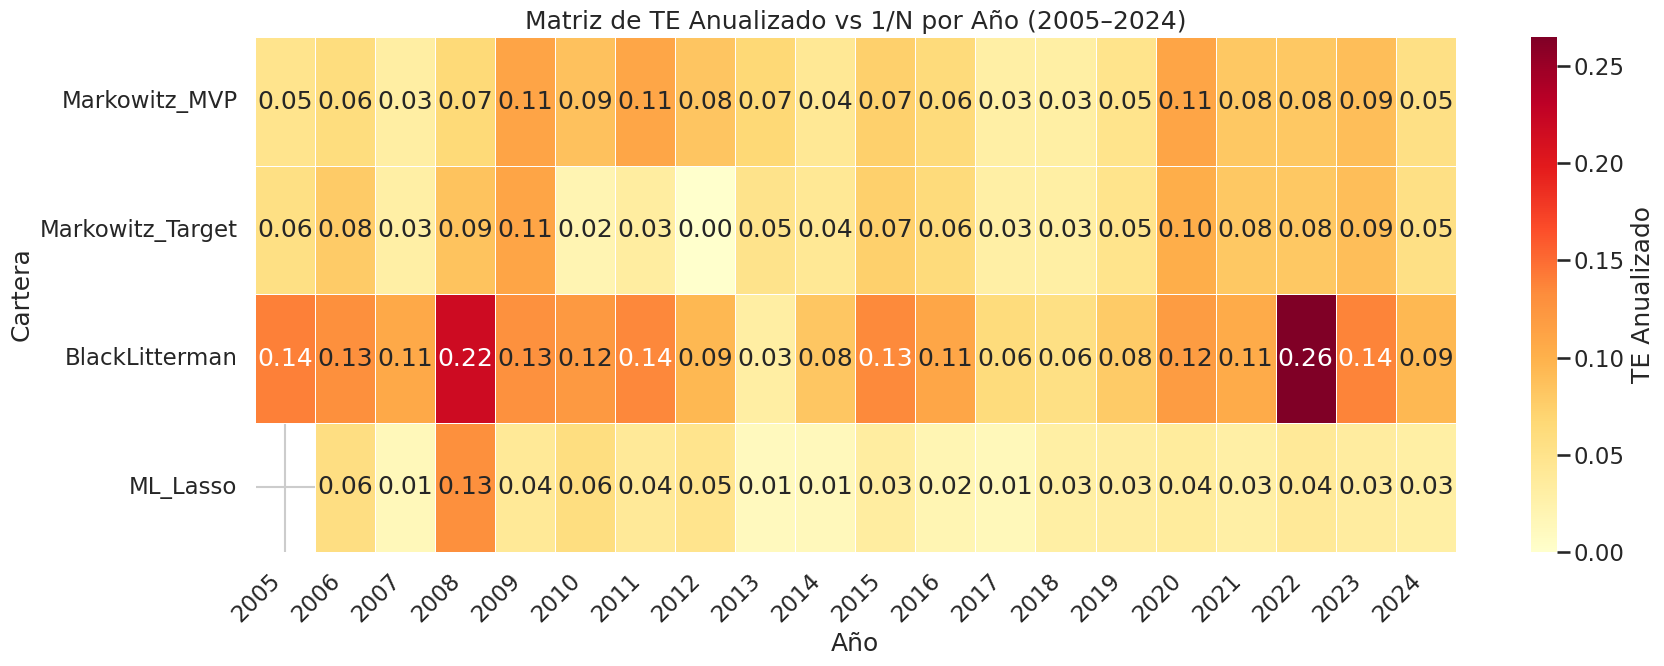

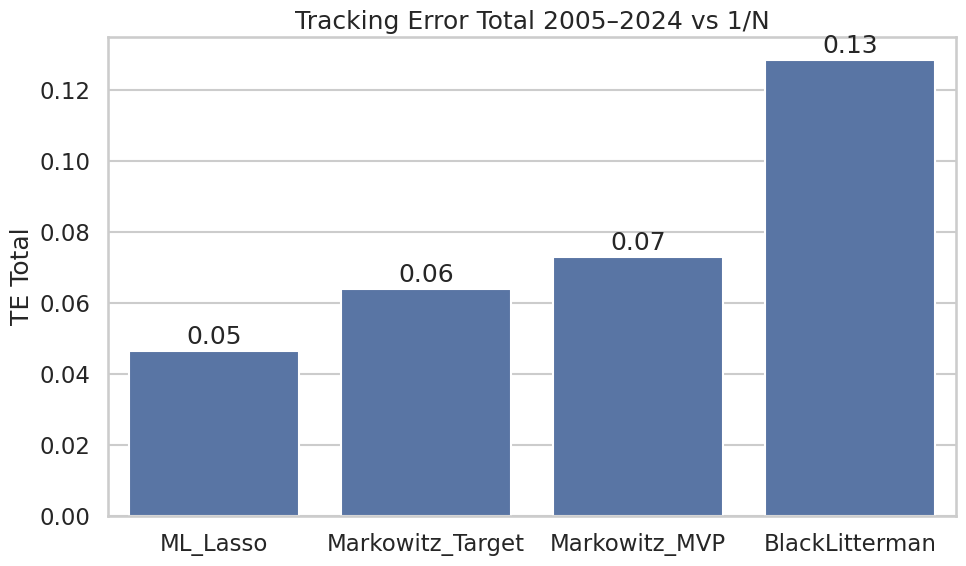

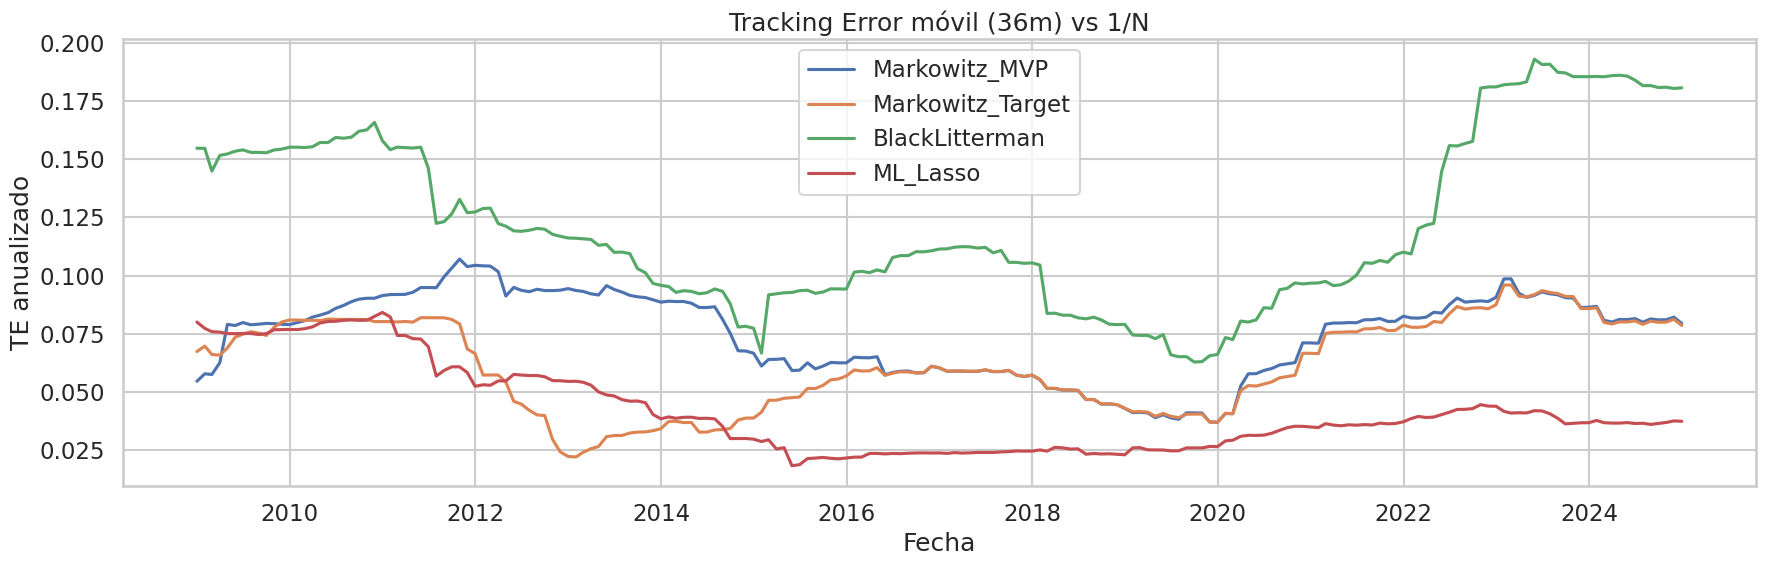

In [ ]:
# ===========================================================
# 5.7) Tracking Error anualizado (vs Naïve 1/N), 2005–2024
#     - TE = std mensual( R_port − R_1/N ) * sqrt(12)
#     - Retornos base: mensuales (usaremos *simples* para TE)
#     - Incluye: Naive_1N, Markowitz_MVP, Markowitz_Target,
#                BlackLitterman y ML_Lasso
# ===========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Parámetros / entorno ----------
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = "./outputs"

try:
    EXCEL_ENGINE
except NameError:
    EXCEL_ENGINE = "xlsxwriter"

YEARS = (2005, 2024)
ANNUALIZATION = np.sqrt(12)

# ---------- 1) Traer retornos mensuales (log) ----------
# Usamos directamente returns_all_log, que ya incluye ML_Lasso
assert "returns_all_log" in globals(), "Falta 'returns_all_log'. Ejecutá antes el paso 5.1."

rets_log = returns_all_log.copy()

# Columnas esperadas
expected = ["Naive_1N", "Markowitz_MVP", "Markowitz_Target",
            "BlackLitterman", "ML_Lasso"]
present = [c for c in expected if c in rets_log.columns]
rets_log = rets_log[present].copy()

# Índice y recorte temporal
rets_log.index = pd.to_datetime(rets_log.index)
rets_log = rets_log.sort_index()
rets_log = rets_log.loc[
    (rets_log.index >= "2005-01-01") &
    (rets_log.index <= "2024-12-31")
]

# ---------- 2) Convertir a retornos simples (TE se mide en aritméticos) ----------
rets_simple = np.exp(rets_log) - 1

# ---------- 3) Calcular TE anualizado por año (vs 1/N) ----------
if "Naive_1N" not in rets_simple.columns:
    raise ValueError("Falta la serie 'Naive_1N' para usar como benchmark del TE.")

benchmark = rets_simple["Naive_1N"]

te_anual = {}
for col in rets_simple.columns:
    diff = (rets_simple[col] - benchmark).dropna()
    te_y = diff.groupby(diff.index.year).std(ddof=1) * ANNUALIZATION
    te_anual[col] = te_y

te_anual_df = pd.DataFrame(te_anual).loc[YEARS[0]:YEARS[1]]
te_anual_df.index.name = "Año"

# ---------- 4) TE total del período ----------
te_total = {}
for col in rets_simple.columns:
    diff_total = (rets_simple[col] - benchmark).dropna()
    te_total[col] = diff_total.std(ddof=1) * ANNUALIZATION
te_total = pd.Series(te_total, name="TE_Total_2005_2024")

# ---------- 5) Estadísticas descriptivas ----------
stats = te_anual_df.describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).T
stats["skewness"] = te_anual_df.skew()
stats["kurtosis"]  = te_anual_df.kurtosis()
# % de años con TE bajo (p.ej. <5% y <10%), útil para evaluar “proximidad” a 1/N
stats["%_años_TE<5%"]  = (te_anual_df.lt(0.05).sum() / te_anual_df.notna().sum() * 100).round(1)
stats["%_años_TE<10%"] = (te_anual_df.lt(0.10).sum() / te_anual_df.notna().sum() * 100).round(1)

display(te_anual_df.head())
display(te_total.to_frame().T)
display(stats.round(4))

# ---------- 6) Guardar Excel ----------
excel_out = f"{OUTPUT_DIR}/4_7_tracking_error_vs_1N_2005_2024.xlsx"
with pd.ExcelWriter(excel_out, engine=EXCEL_ENGINE) as writer:
    te_anual_df.to_excel(writer, sheet_name="TE_Anual_vs_1N")
    te_total.to_frame().to_excel(writer, sheet_name="TE_Total_vs_1N")
    stats.round(6).to_excel(writer, sheet_name="Estadisticas")
    # Dejo explícito el benchmark utilizado
    pd.DataFrame({
        "Benchmark":["Naive_1N"],
        "Base_Retorno":["simple"],
        "Annualization":["sqrt(12)"]
    }).to_excel(writer, sheet_name="Parametros", index=False)

print(f"✅ Excel guardado en: {excel_out}")

# Descarga en Colab
try:
    from google.colab import files
    files.download(excel_out)
except Exception:
    pass

# ===========================================================
# 7) Gráficos
# ===========================================================
sns.set_style("whitegrid")
sns.set_context("talk")

# Para los gráficos, suele ser más informativo ocultar Naive_1N (su TE≈0 vs sí mismo)
cols_plot = [c for c in te_anual_df.columns if c != "Naive_1N"]
te_plot = te_anual_df[cols_plot].copy()

# G1) Barras por año
plt.figure(figsize=(18,7))
te_plot.plot(kind="bar", ax=plt.gca())
plt.title("Tracking Error Anualizado vs 1/N por Año (2005–2024)")
plt.xlabel("Año"); plt.ylabel("TE Anualizado")
plt.legend(title="Cartera", loc="upper left")
plt.tight_layout(); plt.show()

# G2) Evolución temporal (líneas)
plt.figure(figsize=(18,7))
for c in cols_plot:
    plt.plot(te_plot.index, te_plot[c], marker="o", label=c)
plt.title("Evolución del Tracking Error Anualizado vs 1/N")
plt.xlabel("Año"); plt.ylabel("TE Anualizado")
plt.legend(); plt.tight_layout(); plt.show()

# G3) Boxplot comparativo
plt.figure(figsize=(12,7))
sns.boxplot(data=te_plot, orient="h")
plt.title("Distribución del TE Anualizado vs 1/N (2005–2024)")
plt.xlabel("TE Anualizado"); plt.ylabel("Cartera")
plt.tight_layout(); plt.show()

# G4) Heatmap (bajo TE→claro, alto TE→oscuro)
plt.figure(figsize=(18,7))
sns.heatmap(
    te_plot.T, cmap="YlOrRd", annot=True, fmt=".2f",
    linewidths=0.5, cbar_kws={"label":"TE Anualizado"}
)
plt.title("Matriz de TE Anualizado vs 1/N por Año (2005–2024)")
plt.xlabel("Año"); plt.ylabel("Cartera")
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

# G5) TE total (barras)
plt.figure(figsize=(10,6))
order_total = te_total.drop(index="Naive_1N", errors="ignore").sort_values(ascending=True)
sns.barplot(x=order_total.index, y=order_total.values)
for i, v in enumerate(order_total.values):
    plt.text(i, v + 0.002, f"{v:.2f}", ha="center")
plt.title("Tracking Error Total 2005–2024 vs 1/N")
plt.ylabel("TE Total"); plt.xlabel("")
plt.tight_layout(); plt.show()

# (Opcional) G6: TE móvil 36m vs 1/N
try:
    window = 36
    te_roll = {}
    for c in cols_plot:
        diff = (rets_simple[c] - benchmark).dropna()
        te_roll[c] = diff.rolling(window).std(ddof=1) * ANNUALIZATION
    te_roll_df = pd.DataFrame(te_roll).dropna()

    plt.figure(figsize=(18,6))
    for c in te_roll_df.columns:
        plt.plot(te_roll_df.index, te_roll_df[c], label=c)
    plt.title(f"Tracking Error móvil ({window}m) vs 1/N")
    plt.ylabel("TE anualizado"); plt.xlabel("Fecha")
    plt.legend(); plt.tight_layout(); plt.show()
except Exception as e:
    print("No se pudo dibujar el TE móvil:", e)


TO_media_anual_2005_2024  TO_total_acum_2005_2024
Naive_1N                          0.150000                 2.999000
Markowitz_MVP                     0.478000                 9.568000
Markowitz_Target                  1.322000                26.444000
BlackLitterman                    4.999000                99.978000
ML_Lasso                          2.997000                56.948000

count     mean      std      min       5%      25%      50%      75%      95%      max  skewness  kurtosis  %_años_TO>25%  %_años_TO>50%
Naive_1N         20.000000 0.150000 0.043000 0.083000 0.099000 0.121000 0.142000 0.191000 0.221000 0.224000  0.481000 -0.881000       0.000000       0.000000
Markowitz_MVP    20.000000 0.478000 0.346000 0.074000 0.092000 0.262000 0.372000 0.617000 1.043000 1.332000  1.123000  0.533000      75.000000      35.000000
Markowitz_Target 20.000000 1.322000 1.158000 0.113000 0.181000 0.457000 0.951000 2.141000 2.836000 4.506000  1.274000  1.376000      90.000000      70.000000
BlackLitterman   20.000000 4.999000 1.572000 1.578000 3.089000 3.703000 5.011000 5.994000 6.983000 8.164000 -0.086000 -0.009000     100.000000     100.000000
ML_Lasso         19.000000 2.997000 1.906000 0.573000 1.171000 1.526000 2.582000 3.924000 6.561000 7.166000  1.003000  0.070000     100.000000     100.000000

✅ Excel guardado en: ./outputs/4_8_turnover_carteras.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

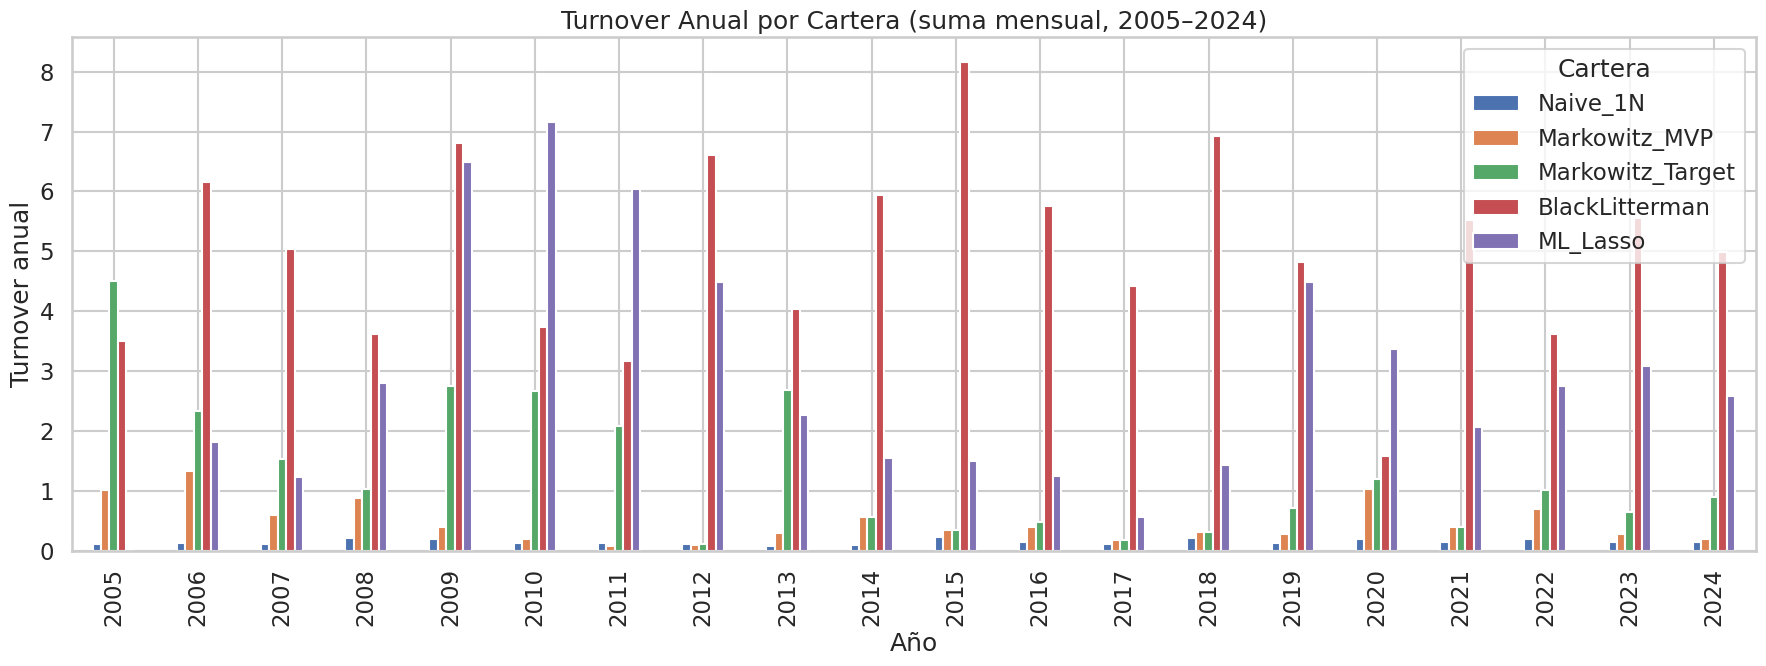

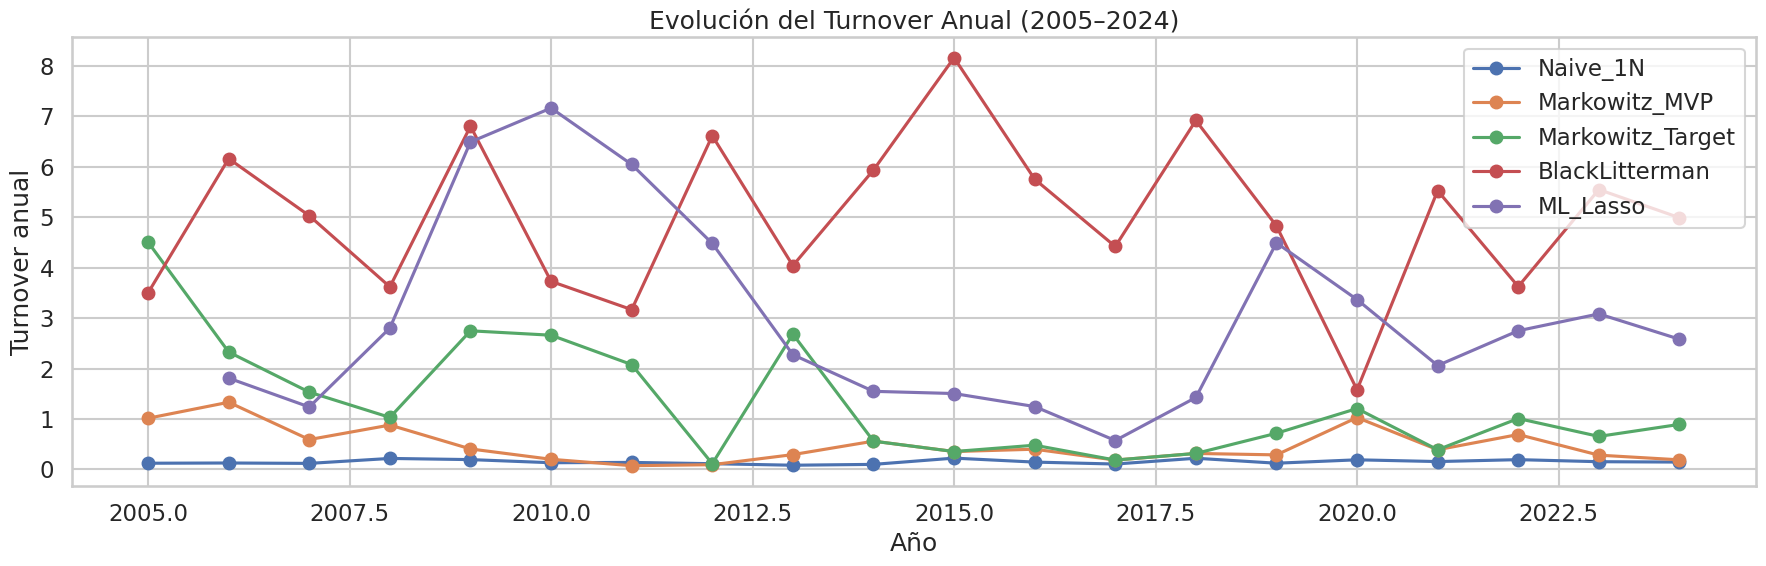

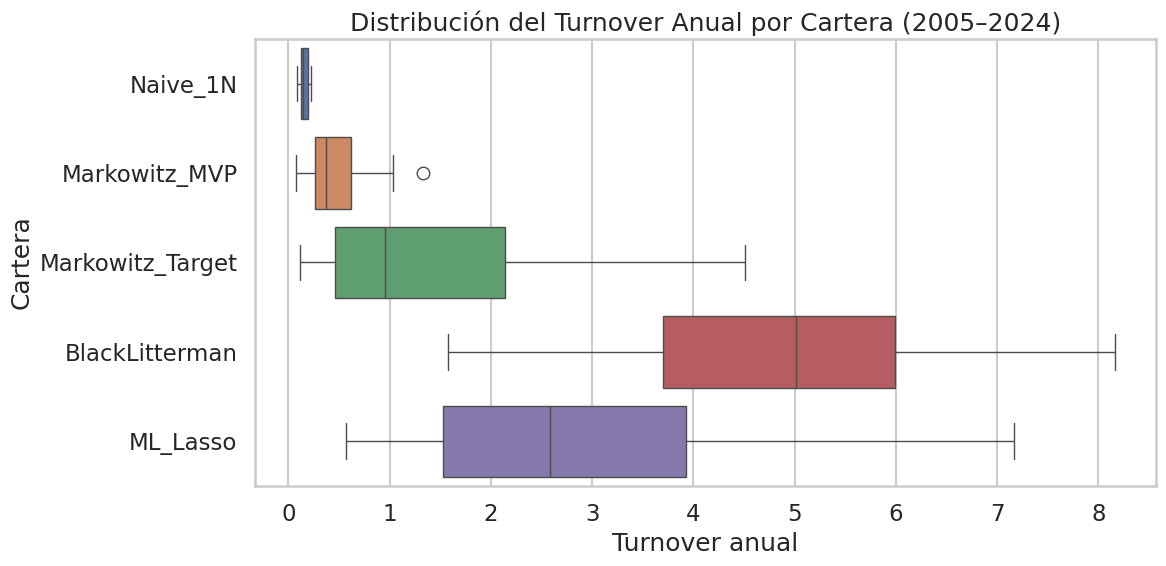

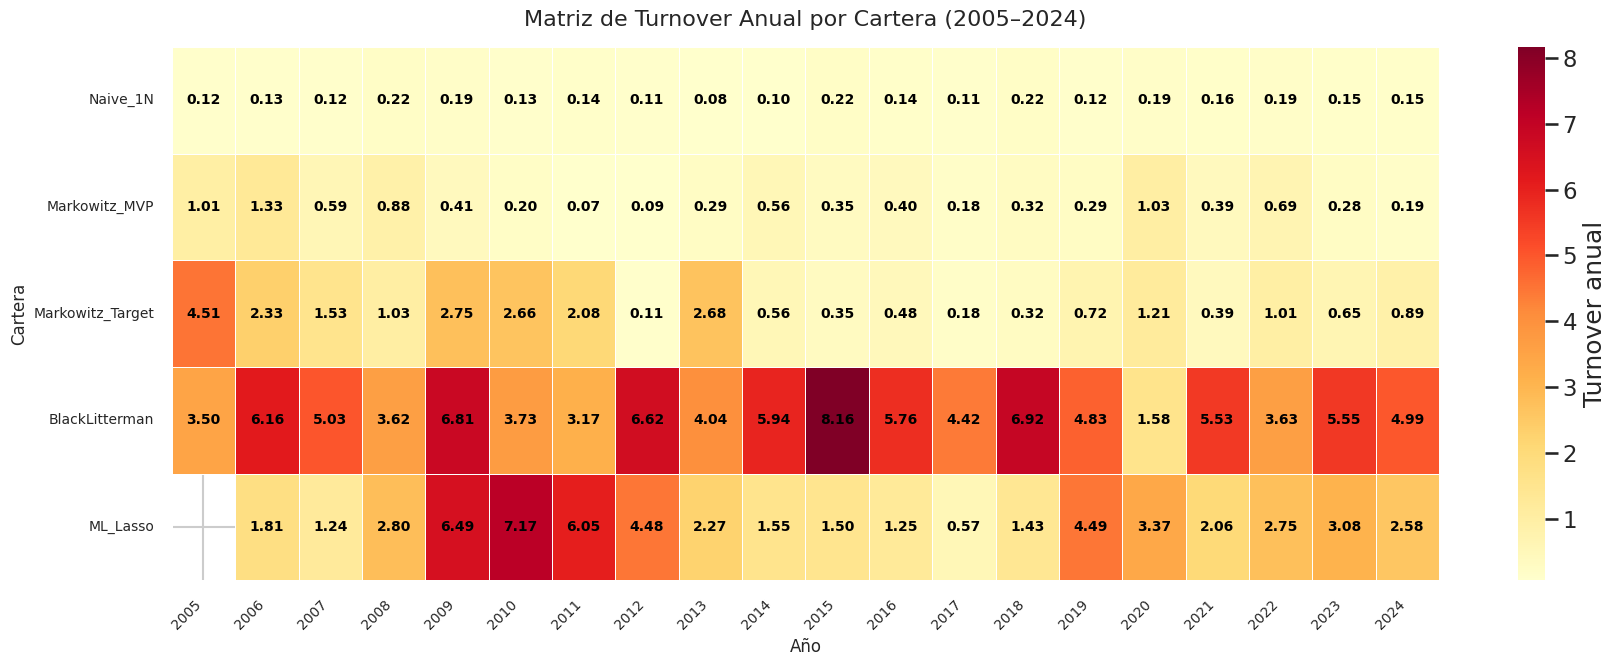

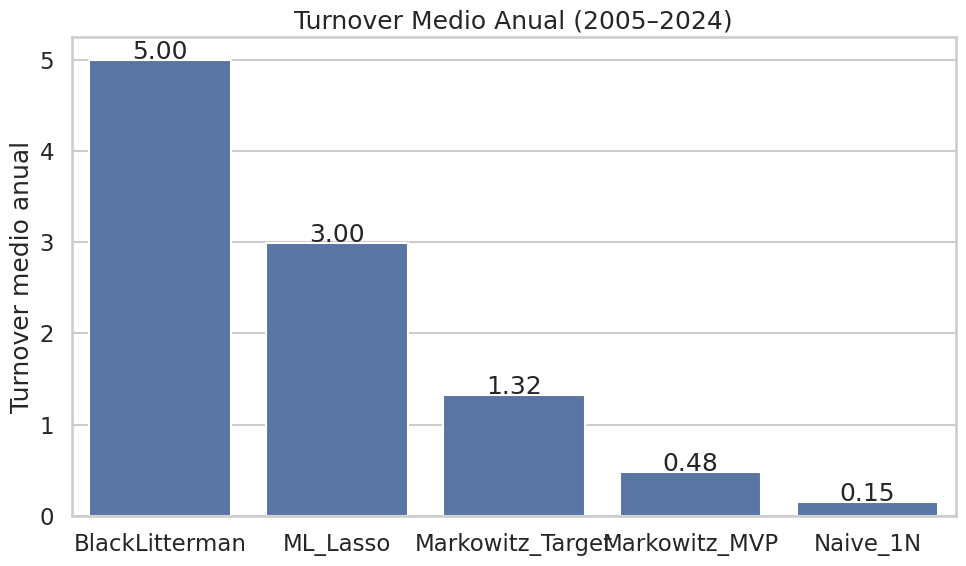

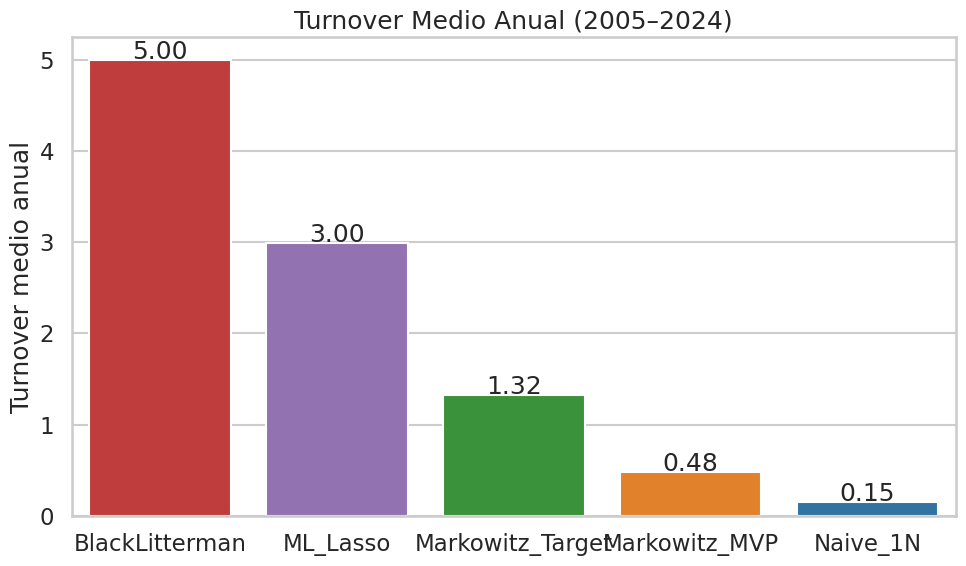

In [ ]:
# ===========================================================
# 5.8) Turnover por cartera (2005–2024)
#     - Turnover mensual con drift:
#       TO_t = 0.5 * sum_i | w_t(i) – w_pre_t(i) |
#       con w_pre_t(i) = [ w_{t-1}(i)*(1+r_i,t) ] / [ 1 + sum_j w_{t-1}(j)*r_j,t ]
#     - Agregado anual (suma mensual)
#     - Totales y estadísticas
#     - Excel + gráficos
#     - Incluye: Naive_1N, Markowitz_MVP, Markowitz_Target,
#                BlackLitterman y ML_Lasso
# ===========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

# ---------- 0) Paths / helpers ----------
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = "./outputs"

try:
    EXCEL_ENGINE
except NameError:
    EXCEL_ENGINE = "xlsxwriter"

try:
    _ON_COLAB
except NameError:
    _ON_COLAB = False

YEARS = ("2005-01-01", "2024-12-31")

# ---------- 1) Reconstruir RETORNOS MENSUALES por ETF (log) ----------
# Preferencias: returns (log de ETFs) -> monthly_data_combined (precios mensuales) -> daily_close_df (resample mensual)
ret_m_df = None

if "returns" in globals() and isinstance(returns, pd.DataFrame) and not returns.empty:
    # ya tienes log-returns mensuales por ETF del backtest
    ret_m_df = returns.copy().sort_index()
elif "monthly_data_combined" in globals() and isinstance(monthly_data_combined, pd.DataFrame) and not monthly_data_combined.empty:
    px = monthly_data_combined.copy().sort_index()
    ret_m_df = np.log(px / px.shift(1)).dropna()
elif "daily_close_df" in globals() and isinstance(daily_close_df, pd.DataFrame) and not daily_close_df.empty:
    pxm = daily_close_df.resample("M").last().sort_index()
    ret_m_df = np.log(pxm / pxm.shift(1)).dropna()
else:
    raise ValueError("No encuentro datos para construir retornos mensuales por ETF (ret_m_df).")

# Convertir a retornos simples para el drift
rets_simple_assets = np.exp(ret_m_df) - 1.0

# Recorte temporal
rets_simple_assets = rets_simple_assets.loc[YEARS[0]:YEARS[1]]

# ---------- 2) Pesos por cartera (del backtest) ----------
# Asegúrate de tener estos DataFrames creados (incluyendo ML)
weights_dict = {
    "Naive_1N":          all_weights_1N_df,
    "Markowitz_MVP":     all_weights_markowitz_mvp_df,
    "Markowitz_Target":  all_weights_markowitz_target_df,
    "BlackLitterman":    all_weights_black_litterman_df,  # nombre ya normalizado arriba
}

# Intentamos sumar la cartera ML_Lasso si está disponible
if "pesos_ml" in globals():
    weights_dict["ML_Lasso"] = pesos_ml
elif "weights_ml" in globals():
    weights_dict["ML_Lasso"] = weights_ml
elif "weights_ml_lasso_df" in globals():
    weights_dict["ML_Lasso"] = weights_ml_lasso_df
# Si no existe ninguna de esas variables, simplemente no se agrega ML_Lasso

# Normalizo fechas y columnas, y recorto periodo
for k, v in list(weights_dict.items()):
    if v is None or len(v) == 0:
        del weights_dict[k]
        continue
    w = v.copy()
    if isinstance(w.columns, pd.MultiIndex):
        w.columns = w.columns.get_level_values(-1)
    w.index = pd.to_datetime(w.index)
    w = w.sort_index().loc[YEARS[0]:YEARS[1]]
    w = w.fillna(0.0)
    rowsum = w.sum(axis=1).replace(0, np.nan)
    w = (w.T / rowsum).T.fillna(0.0).clip(lower=0)
    weights_dict[k] = w

if not weights_dict:
    raise ValueError("No hay DataFrames de pesos disponibles en weights_dict.")

# ---------- 3) Universo de columnas común ----------
all_cols = sorted(list(set().union(*[set(df.columns) for df in weights_dict.values()])))
rets_simple_assets = rets_simple_assets.reindex(columns=all_cols).fillna(0.0)
for k in weights_dict:
    weights_dict[k] = weights_dict[k].reindex(columns=all_cols).fillna(0.0)

# ---------- 4) Función de Turnover mensual con drift ----------
def monthly_turnover_with_drift(w_df: pd.DataFrame, r_df: pd.DataFrame) -> pd.Series:
    """
    Retorna Serie de Turnover mensual (index = fechas):
      TO_t = 0.5 * sum | w_t - w_pre_t |
    donde w_pre_t son los pesos tras drift de retornos del mes t
    aplicados a los pesos del mes t-1.
    """
    idx = w_df.index.intersection(r_df.index)
    w = w_df.loc[idx].copy()
    r = r_df.loc[idx].copy()

    w = w.clip(lower=0)
    w = (w.T / w.sum(axis=1).replace(0, np.nan)).T.fillna(0.0)

    to_vals, to_dates = [], []

    for t in range(1, len(idx)):
        date_t   = idx[t]
        date_t_1 = idx[t-1]

        w_prev = w.loc[date_t_1].values
        w_tgt  = w.loc[date_t].values
        r_t    = r.loc[date_t].values

        port_ret_t = float(np.dot(w_prev, r_t))
        denom = (1.0 + port_ret_t) if abs(1.0 + port_ret_t) > 1e-12 else 1.0
        w_pre = (w_prev * (1.0 + r_t)) / denom

        to_t = 0.5 * np.nansum(np.abs(w_tgt - w_pre))
        to_vals.append(to_t); to_dates.append(date_t)

    return pd.Series(to_vals, index=pd.Index(to_dates, name="Date"), name="Turnover")

# ---------- 5) Calcular Turnover mensual y anual ----------
turnover_mensual = {}
turnover_anual   = {}

for name, wdf in weights_dict.items():
    to_m = monthly_turnover_with_drift(wdf, rets_simple_assets)
    turnover_mensual[name] = to_m
    turnover_anual[name] = to_m.groupby(to_m.index.year).sum()

turnover_mensual_df = pd.DataFrame(turnover_mensual)
turnover_anual_df   = pd.DataFrame(turnover_anual)

# ---------- 6) Totales / medias 2005–2024 ----------
turnover_total = pd.DataFrame({
    "TO_media_anual_2005_2024": turnover_anual_df.mean(axis=0),
    "TO_total_acum_2005_2024":  turnover_anual_df.sum(axis=0),
})

# ---------- 7) Estadísticas descriptivas (anual) ----------
stats = turnover_anual_df.describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).T
stats["skewness"] = turnover_anual_df.skew()
stats["kurtosis"] = turnover_anual_df.kurtosis()
stats["%_años_TO>25%"] = ((turnover_anual_df > 0.25).sum() / turnover_anual_df.notna().sum() * 100).round(1)
stats["%_años_TO>50%"] = ((turnover_anual_df > 0.50).sum() / turnover_anual_df.notna().sum() * 100).round(1)

display(turnover_total.round(3))
display(stats.round(3))

# ---------- 8) Excel ----------
excel_out = f"{OUTPUT_DIR}/4_8_turnover_carteras.xlsx"
with pd.ExcelWriter(excel_out, engine=EXCEL_ENGINE) as writer:
    turnover_mensual_df.to_excel(writer, sheet_name="TO_Mensual")
    turnover_anual_df.to_excel(writer, sheet_name="TO_Anual")
    turnover_total.round(6).to_excel(writer, sheet_name="Resumen_Total")
    stats.round(6).to_excel(writer, sheet_name="Estadisticas_Anuales")

print(f"✅ Excel guardado en: {excel_out}")
if _ON_COLAB:
    from google.colab import files
    try:
        files.download(excel_out)
    except Exception as e:
        print("Descarga automática no disponible:", e)

# ---------- 9) Gráficos ----------
# G1) Barras por año
plt.figure(figsize=(18,7))
turnover_anual_df.plot(kind="bar", ax=plt.gca())
plt.title("Turnover Anual por Cartera (suma mensual, 2005–2024)")
plt.xlabel("Año"); plt.ylabel("Turnover anual")
plt.legend(title="Cartera", loc="upper right")
plt.tight_layout(); plt.show()

# G2) Evolución temporal (líneas)
plt.figure(figsize=(18,6))
for col in turnover_anual_df.columns:
    plt.plot(turnover_anual_df.index, turnover_anual_df[col], marker="o", label=col)
plt.title("Evolución del Turnover Anual (2005–2024)")
plt.xlabel("Año"); plt.ylabel("Turnover anual")
plt.legend(); plt.tight_layout(); plt.show()

# G3) Boxplot comparativo (anual)
plt.figure(figsize=(12,6))
sns.boxplot(data=turnover_anual_df, orient="h")
plt.title("Distribución del Turnover Anual por Cartera (2005–2024)")
plt.xlabel("Turnover anual"); plt.ylabel("Cartera")
plt.tight_layout(); plt.show()

# G4) Heatmap (anual) – con anotaciones legibles
plt.figure(figsize=(18,7))
vals = turnover_anual_df.T.values
vmax = vals.max()
vmin = vals.min()

ax = sns.heatmap(
    turnover_anual_df.T,
    cmap="YlOrRd",
    annot=True, fmt=".2f",
    linewidths=0.5,
    cbar_kws={"label":"Turnover anual"},
    annot_kws={"size":10, "weight":"bold"}
)

for text, val in zip(ax.texts, vals.flatten()):
    norm_val = (val - vmin) / (vmax - vmin + 1e-9)
    text.set_color("white" if norm_val > 0.5 else "black")

plt.title("Matriz de Turnover Anual por Cartera (2005–2024)", fontsize=16, pad=15)
plt.xlabel("Año", fontsize=12); plt.ylabel("Cartera", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# G5) Barras – Turnover medio anual (ranking)
order_total = turnover_total["TO_media_anual_2005_2024"].sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=order_total.index, y=order_total.values)
for i, v in enumerate(order_total.values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")
plt.title("Turnover Medio Anual (2005–2024)")
plt.ylabel("Turnover medio anual"); plt.xlabel("")
plt.tight_layout(); plt.show()

#====================================================================
# Paleta de colores por defecto de matplotlib (tab10) para ranking
colors = plt.get_cmap("tab10").colors
color_map = {
    "Naive_1N":         colors[0],
    "Markowitz_MVP":    colors[1],
    "Markowitz_Target": colors[2],
    "BlackLitterman":   colors[3],
    "ML_Lasso":         colors[4],
}

order_total = turnover_total["TO_media_anual_2005_2024"].sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x=order_total.index,
    y=order_total.values,
    palette=[color_map.get(name, colors[0]) for name in order_total.index]
)

for i, v in enumerate(order_total.values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")

plt.title("Turnover Medio Anual (2005–2024)")
plt.ylabel("Turnover medio anual")
plt.xlabel("")
plt.tight_layout()
plt.show()


✅ Excel guardado en: ./outputs/4_10_sortino_2005_2024.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

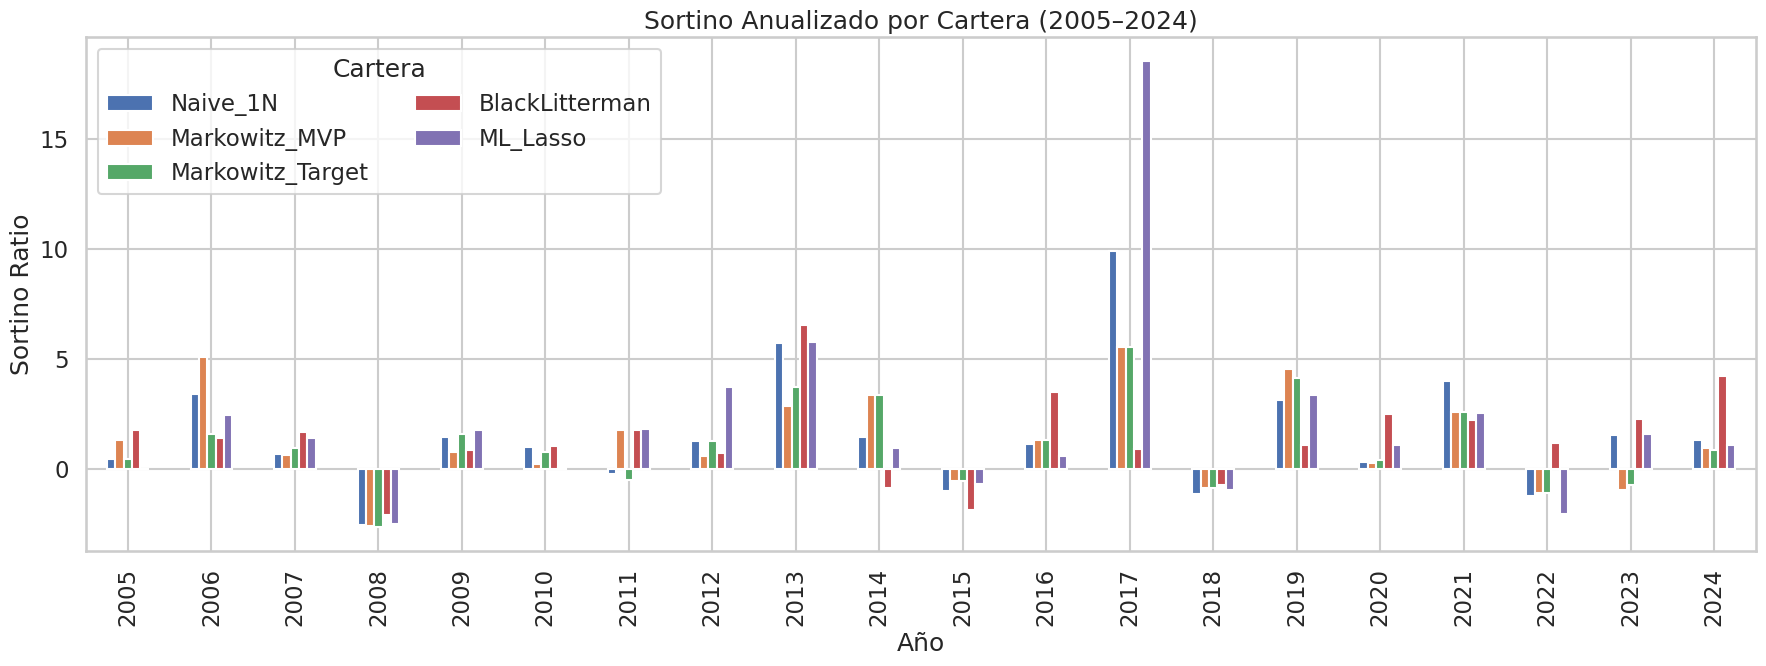

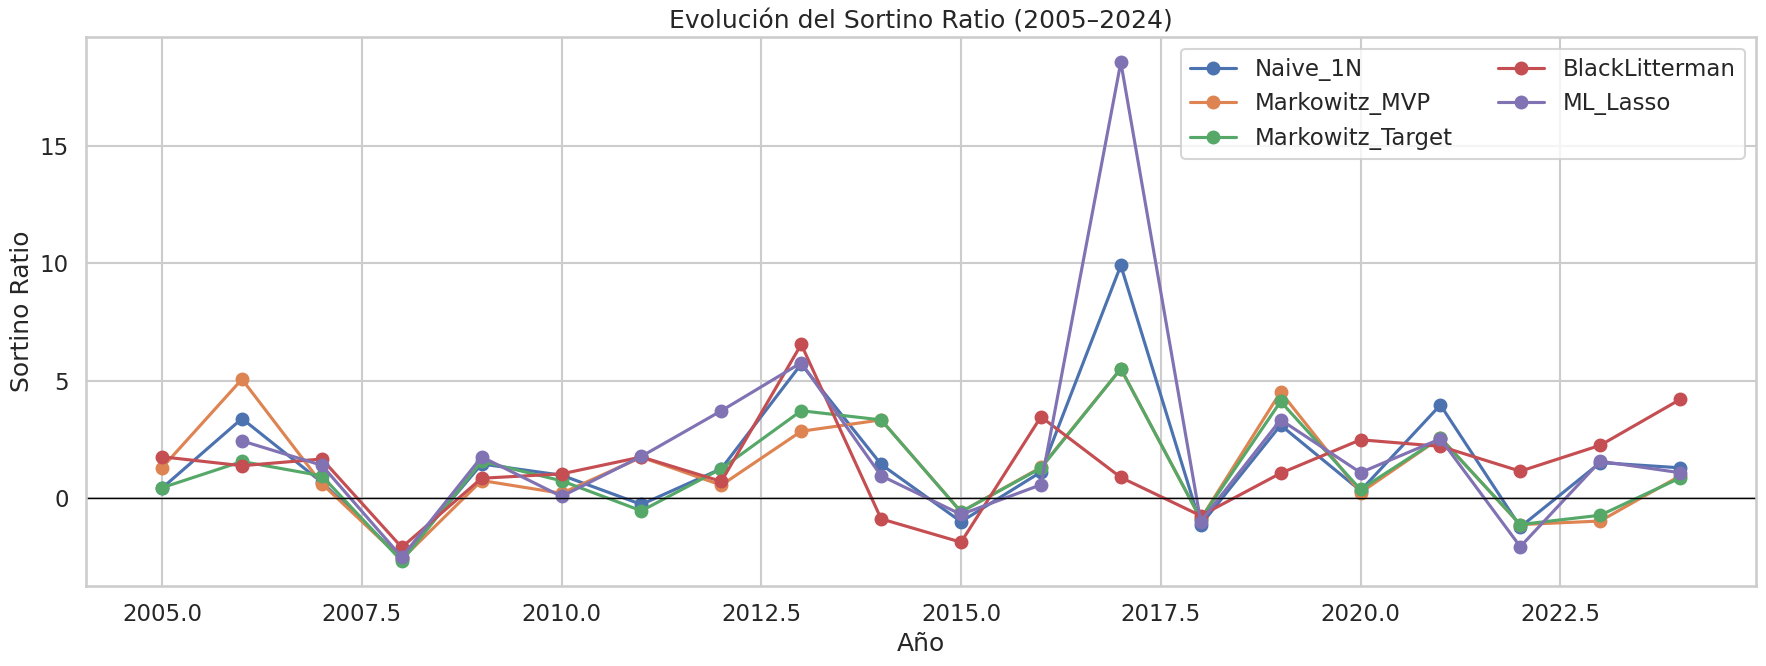

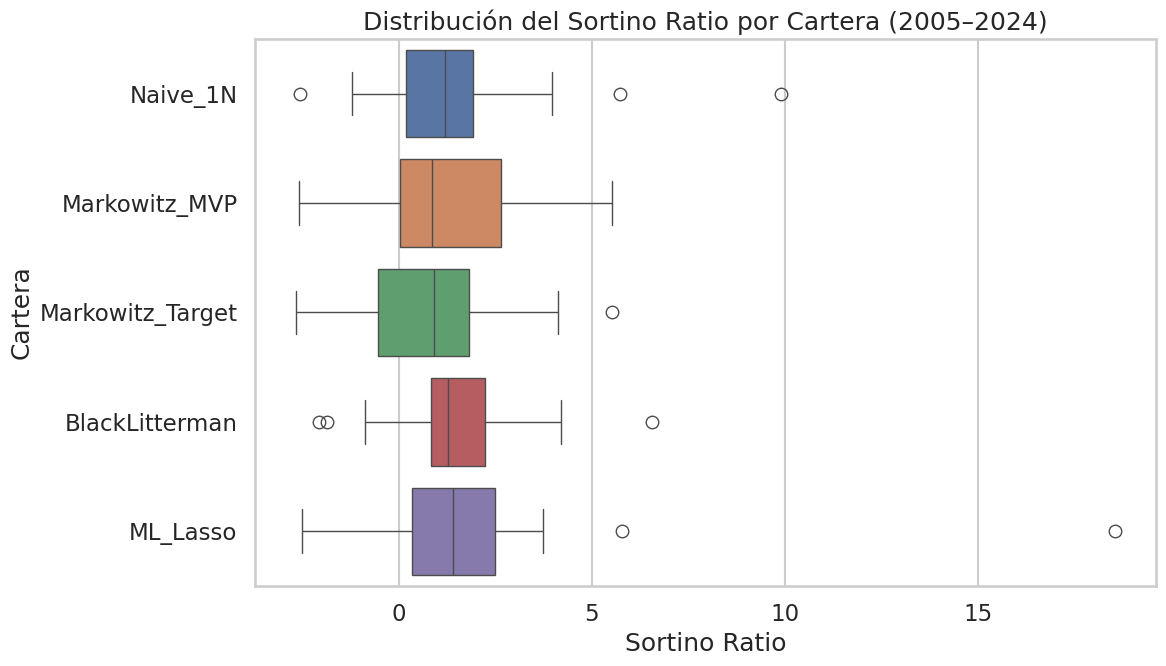

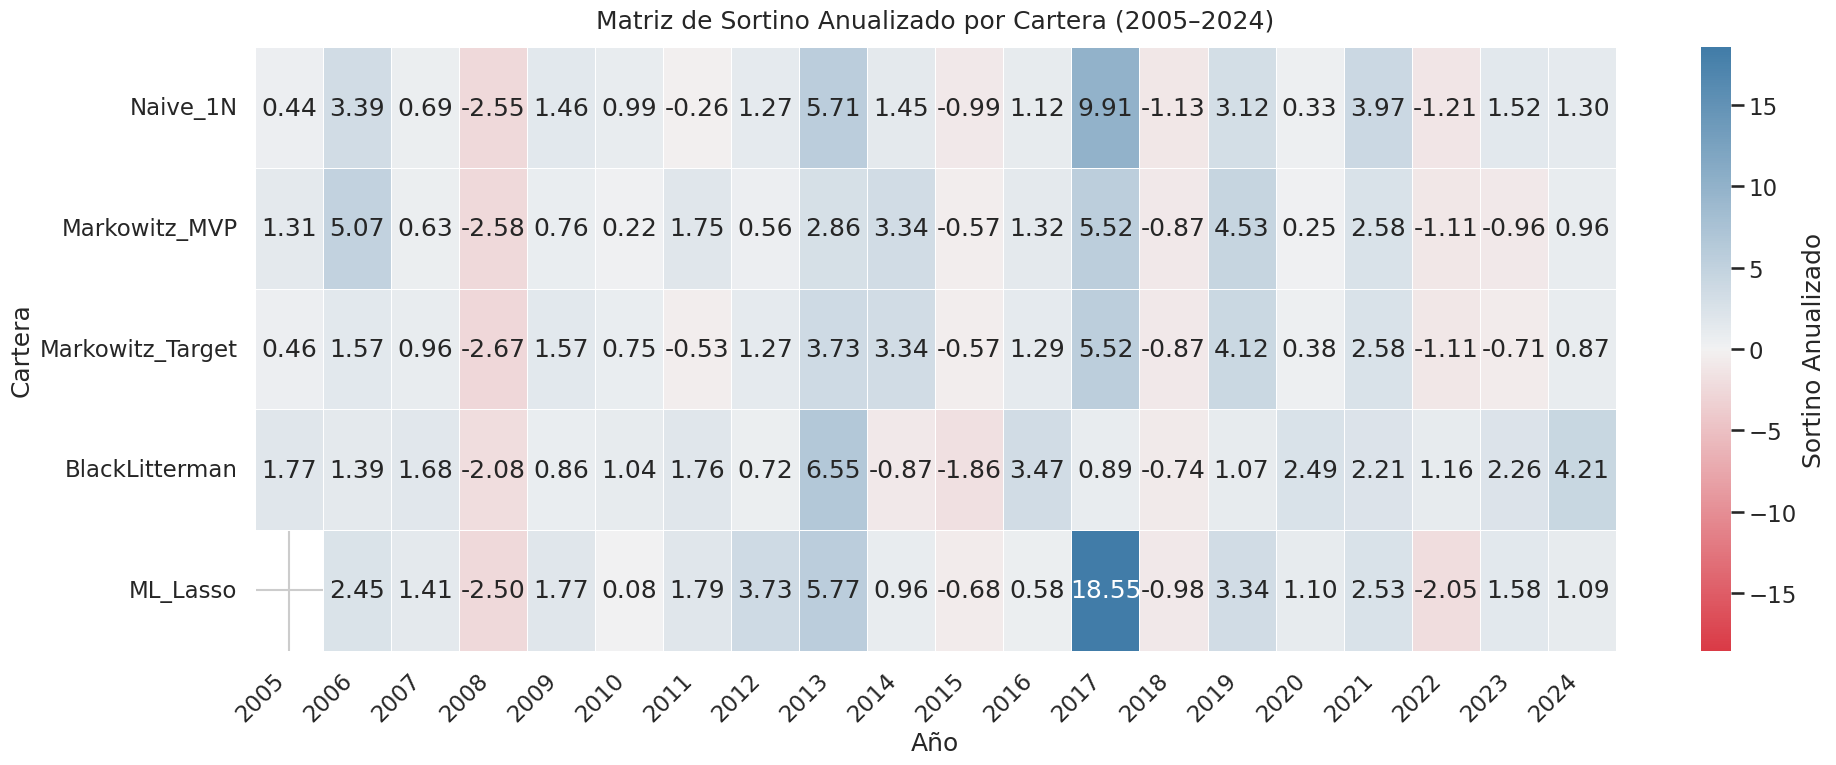


=== Sortino Total 2005–2024 ===


Sortino_Total_2005_2024
Naive_1N                         0.382000
Markowitz_MVP                    0.358000
Markowitz_Target                 0.400000
BlackLitterman                   0.731000
ML_Lasso                         0.452000


=== Estadísticas descriptivas de Sortino anual ===


count     mean      std       min        5%       25%      50%      75%      95%       max  skewness  kurtosis  %_años>0  %_años>1
Naive_1N         20.000000 1.527000 2.757000 -2.553000 -1.280000  0.182000 1.194000 1.921000 5.924000  9.907000  1.548000  3.631000 75.000000 55.000000
Markowitz_MVP    20.000000 1.276000 2.161000 -2.580000 -1.186000  0.019000 0.860000 2.647000 5.090000  5.516000  0.455000 -0.280000 75.000000 45.000000
Markowitz_Target 20.000000 1.097000 2.001000 -2.667000 -1.187000 -0.539000 0.915000 1.824000 4.191000  5.516000  0.436000  0.104000 70.000000 45.000000
BlackLitterman   20.000000 1.400000 1.992000 -2.080000 -1.873000  0.824000 1.274000 2.226000 4.325000  6.550000  0.527000  1.479000 80.000000 65.000000
ML_Lasso         19.000000 2.132000 4.439000 -2.499000 -2.097000  0.333000 1.409000 2.490000 7.046000 18.545000  3.006000 11.161000 78.900000 63.200000

In [ ]:
# ===========================================================
# 5.9) Ratio de Sortino (2005–2024) – Versión robusta
#      Incluye: Naive_1N, Markowitz_MVP, Markowitz_Target,
#               BlackLitterman y ML_Lasso
# ===========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

# ---------- Parámetros ----------
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = "./outputs"

try:
    EXCEL_ENGINE
except NameError:
    EXCEL_ENGINE = "xlsxwriter"

# Tasa libre de riesgo (anual y mensual)
RF_ANUAL = 0.02
RF_MENSUAL = (1 + RF_ANUAL)**(1/12) - 1

START, END = "2005-01-01", "2024-12-31"

# ---------- 1) Retornos mensuales de CARTERAS (log) ----------
# Usamos directamente returns_all_log, que ya incluye ML_Lasso
assert "returns_all_log" in globals(), "Falta 'returns_all_log'. Ejecutá antes el paso 5.1 (export de retornos)."

rets_log = returns_all_log.copy()

# Nos quedamos solo con las carteras relevantes
expected_cols = ["Naive_1N", "Markowitz_MVP", "Markowitz_Target",
                 "BlackLitterman", "ML_Lasso"]
cols_present = [c for c in expected_cols if c in rets_log.columns]
rets_log = rets_log[cols_present]

# Índice y recorte temporal
rets_log.index = pd.to_datetime(rets_log.index)
rets_log = rets_log.sort_index()
rets_log = rets_log.loc[START:END]

# Quitar columnas completamente vacías (por seguridad)
rets_log = rets_log.dropna(axis=1, how="all")

if rets_log.shape[1] == 0:
    raise ValueError("Tras el filtro 2005–2024, no quedó ninguna cartera con datos.")

# Convertir log-returns a simples y calcular excesos sobre RF mensual
rets_simple = np.exp(rets_log) - 1
excess = rets_simple - RF_MENSUAL

# ---------- 2) Función Sortino ----------
def sortino_ratio(r, rf=0.0, target=0.0):
    """
    r: retornos simples mensuales (Serie)
    rf: tasa libre de riesgo mensual
    target: objetivo adicional (0 por defecto → penaliza solo retornos < rf)
    """
    excess_ret = r - rf
    downside = np.std(np.minimum(0, excess_ret - target), ddof=1)
    if downside == 0 or np.isnan(downside):
        return np.nan
    return np.sqrt(12) * excess_ret.mean() / downside

# ---------- 3) Sortino anualizado por año ----------
sortino_anual = excess.groupby(excess.index.year).apply(
    lambda g: pd.Series({col: sortino_ratio(g[col], rf=RF_MENSUAL) for col in g.columns})
)
sortino_anual.index.name = "Año"

# ---------- 4) Sortino total (2005–2024) ----------
sortino_total = excess.apply(lambda r: sortino_ratio(r, rf=RF_MENSUAL))
sortino_total.name = "Sortino_Total_2005_2024"
sortino_total_df = sortino_total.to_frame()

# ---------- 5) Estadísticas descriptivas ----------
if sortino_anual.shape[1] == 0:
    raise ValueError("sortino_anual no tiene columnas; revisá que haya carteras con datos en 2005–2024.")

stats_sortino = sortino_anual.describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).T
stats_sortino["skewness"] = sortino_anual.skew()
stats_sortino["kurtosis"] = sortino_anual.kurtosis()
stats_sortino["%_años>0"] = ((sortino_anual > 0).sum() / sortino_anual.notna().sum() * 100).round(1)
stats_sortino["%_años>1"] = ((sortino_anual > 1).sum() / sortino_anual.notna().sum() * 100).round(1)

# ---------- 6) Excel ----------
excel_out = f"{OUTPUT_DIR}/4_10_sortino_2005_2024.xlsx"
with pd.ExcelWriter(excel_out, engine=EXCEL_ENGINE) as writer:
    sortino_anual.to_excel(writer, sheet_name="Sortino_Anual")
    sortino_total_df.to_excel(writer, sheet_name="Sortino_Total")
    stats_sortino.round(4).to_excel(writer, sheet_name="Estadisticas")

print(f"✅ Excel guardado en: {excel_out}")
if '_ON_COLAB' in globals() and _ON_COLAB:
    from google.colab import files
    files.download(excel_out)

# ---------- 7) Gráficos ----------
# G1) Barras por año
plt.figure(figsize=(18,7))
sortino_anual.plot(kind="bar", ax=plt.gca())
plt.title("Sortino Anualizado por Cartera (2005–2024)")
plt.xlabel("Año"); plt.ylabel("Sortino Ratio")
plt.legend(title="Cartera", loc="upper left", ncol=2)
plt.tight_layout(); plt.show()

# G2) Evolución temporal
plt.figure(figsize=(18,7))
for col in sortino_anual.columns:
    plt.plot(sortino_anual.index, sortino_anual[col], marker="o", label=col)
plt.axhline(0, color="black", linewidth=1)
plt.title("Evolución del Sortino Ratio (2005–2024)")
plt.xlabel("Año"); plt.ylabel("Sortino Ratio")
plt.legend(ncol=2); plt.tight_layout(); plt.show()

# G3) Boxplot comparativo
plt.figure(figsize=(12,7))
sns.boxplot(data=sortino_anual, orient="h")
plt.title("Distribución del Sortino Ratio por Cartera (2005–2024)")
plt.xlabel("Sortino Ratio"); plt.ylabel("Cartera")
plt.tight_layout(); plt.show()

# G4) Heatmap mejorado (contraste)
M = sortino_anual.T.copy()
vmax = np.nanmax(np.abs(M.values))
vmin = -vmax
cmap = sns.diverging_palette(10, 240, as_cmap=True)

plt.figure(figsize=(20,8))
ax = sns.heatmap(
    M, cmap=cmap, vmin=vmin, vmax=vmax, center=0,
    annot=True, fmt=".2f", linewidths=0.6, linecolor="white",
    cbar_kws={"label": "Sortino Anualizado"}
)
ax.set_title("Matriz de Sortino Anualizado por Cartera (2005–2024)", pad=14)
ax.set_xlabel("Año"); ax.set_ylabel("Cartera")
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

# ---------- 8) Resumen en pantalla ----------
print("\n=== Sortino Total 2005–2024 ===")
display(sortino_total_df.round(3))

print("\n=== Estadísticas descriptivas de Sortino anual ===")
display(stats_sortino.round(3))


✅ Excel guardado en: ./outputs/4_11_omega_ratio_2005_2024.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

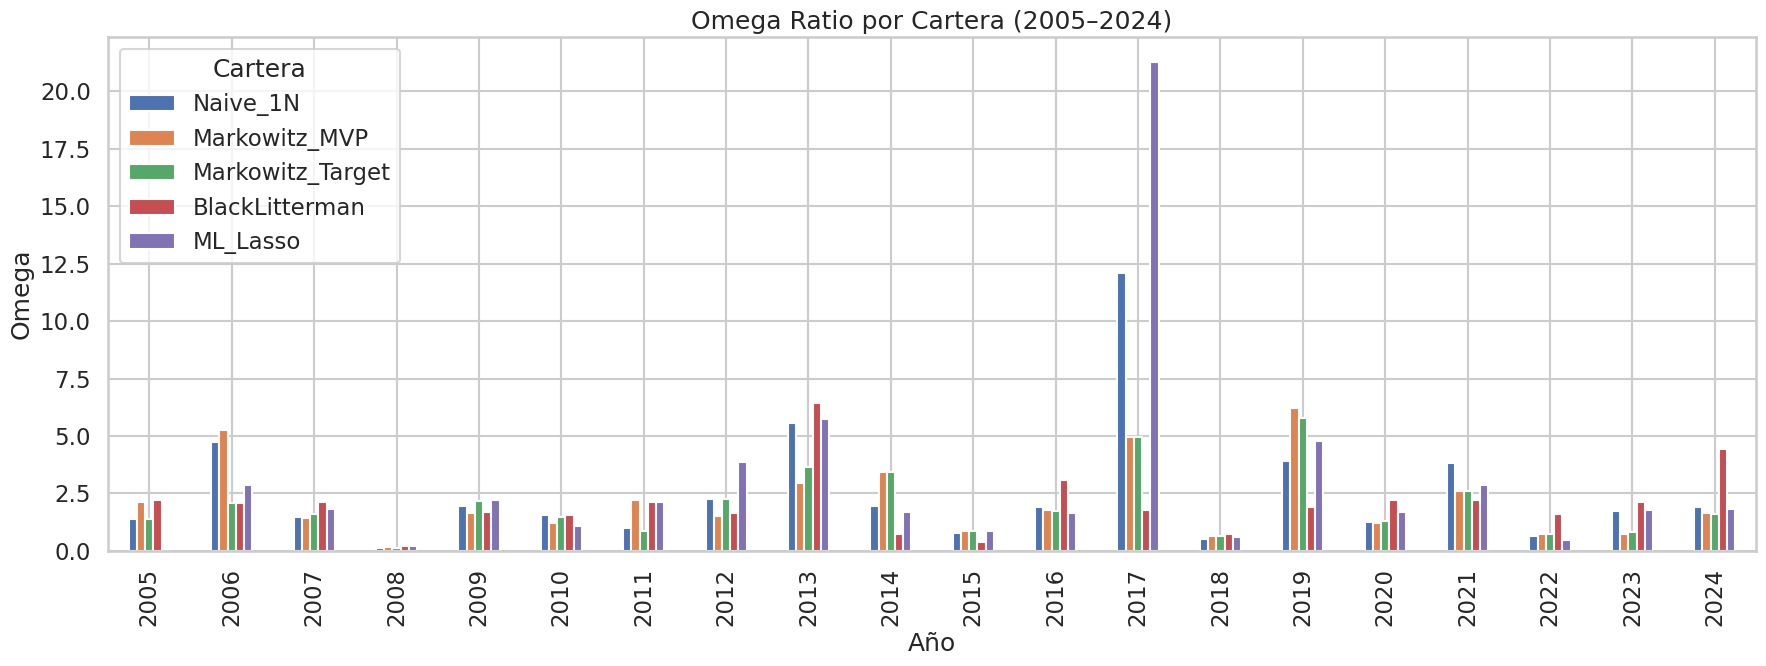

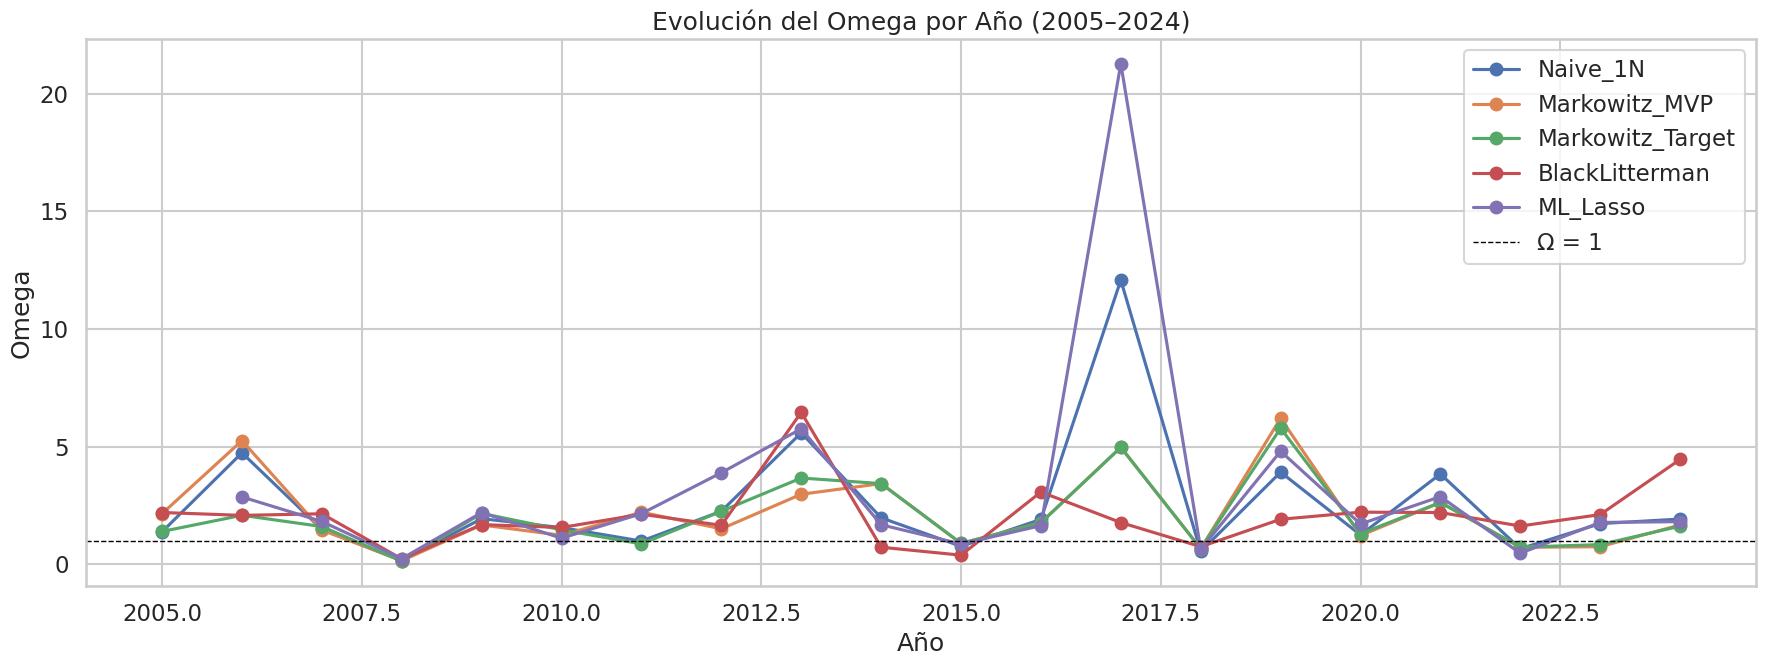

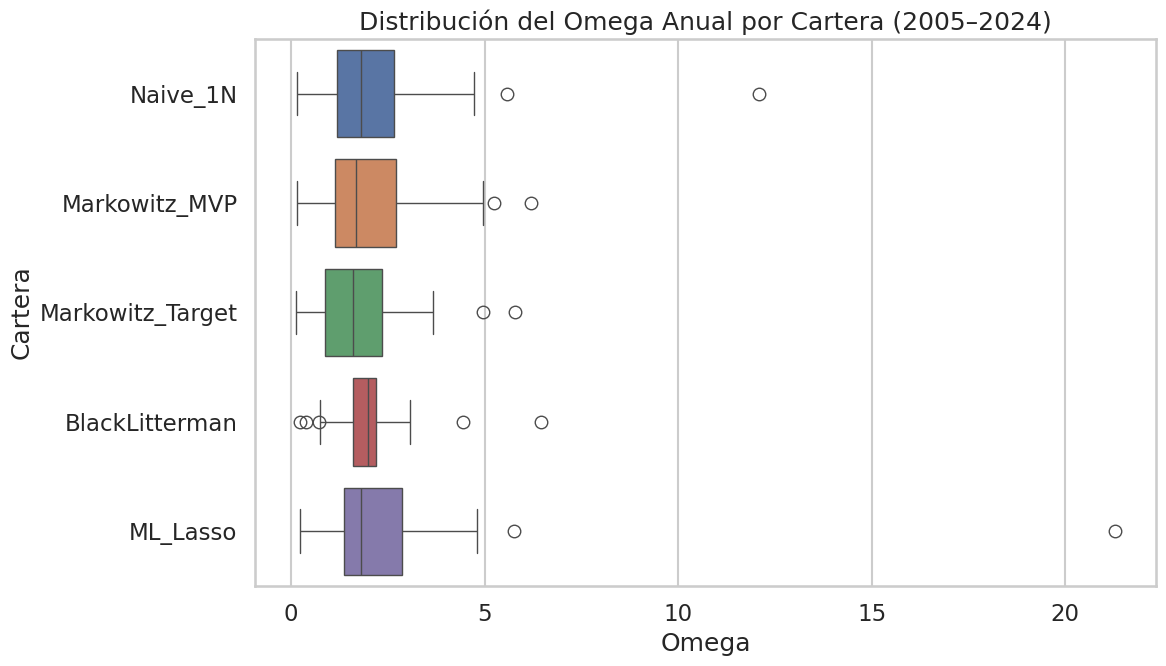

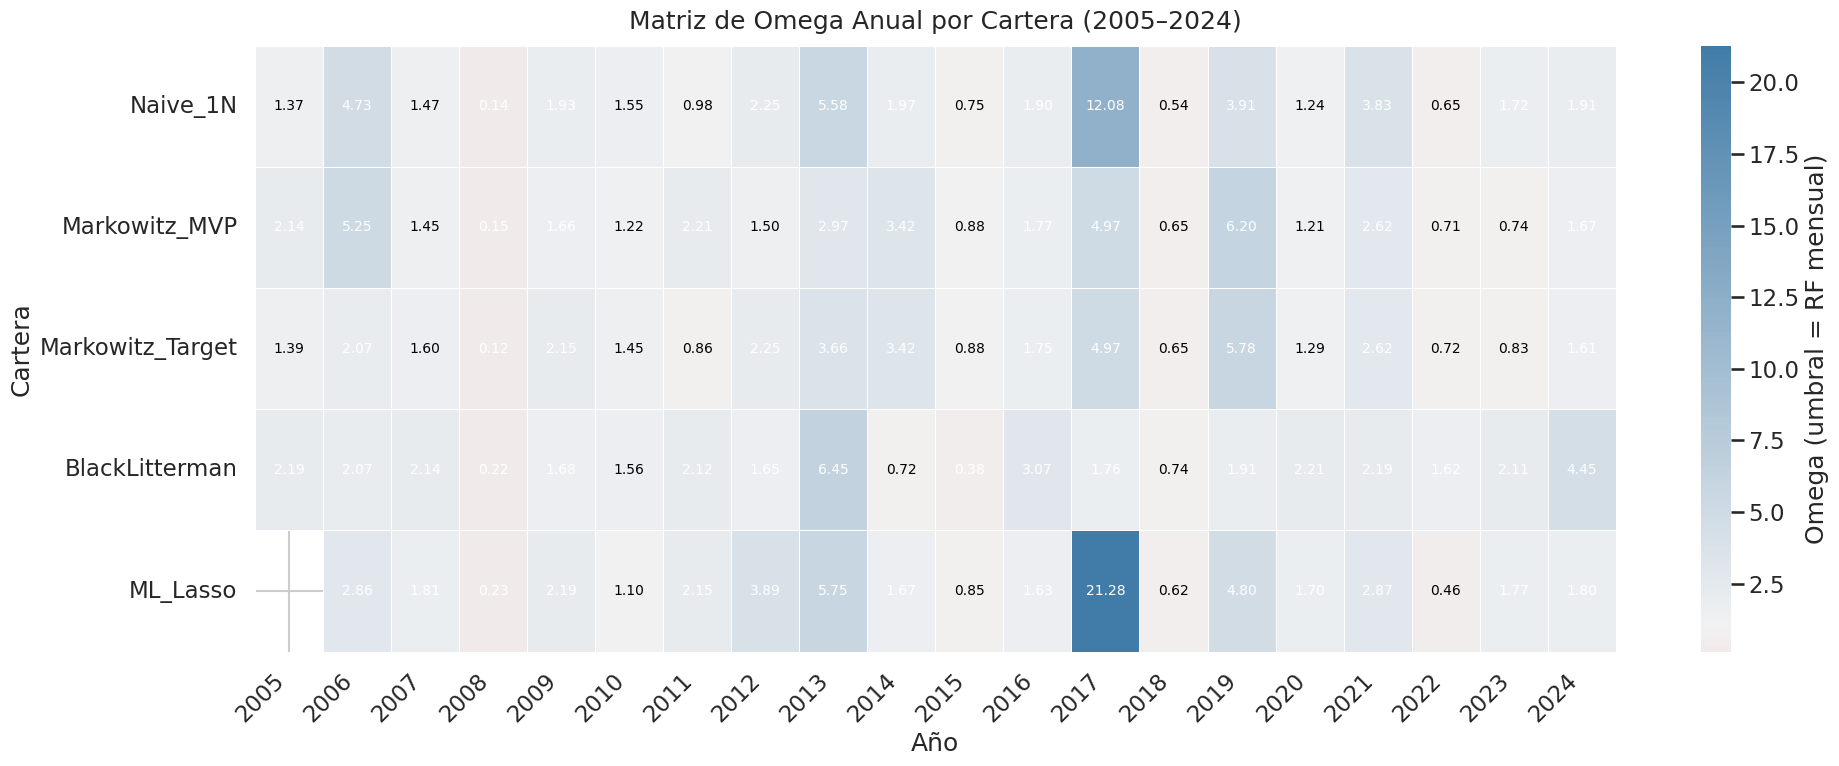


=== Omega Total 2005–2024 ===


Omega_Total_2005_2024
Naive_1N                       1.338000
Markowitz_MVP                  1.344000
Markowitz_Target               1.342000
BlackLitterman                 1.522000
ML_Lasso                       1.373000


=== Estadísticas descriptivas del Omega anual ===


count     mean      std      min       5%      25%      50%      75%      95%       max  skewness  kurtosis  %_años_Omega>1  \
Naive_1N         20.000000 2.526000 2.665000 0.142000 0.517000 1.172000 1.810000 2.644000 5.908000 12.079000  2.692000  8.670000       75.000000   
Markowitz_MVP    20.000000 2.169000 1.649000 0.146000 0.629000 1.130000 1.664000 2.707000 5.298000  6.201000  1.259000  0.897000       75.000000   
Markowitz_Target 20.000000 2.004000 1.466000 0.121000 0.628000 0.874000 1.604000 2.340000 5.008000  5.778000  1.314000  1.414000       70.000000   
BlackLitterman   20.000000 2.061000 1.391000 0.217000 0.370000 1.602000 1.988000 2.192000 4.550000  6.452000  1.810000  4.800000       80.000000   
ML_Lasso         19.000000 3.129000 4.623000 0.230000 0.436000 1.367000 1.803000 2.862000 7.308000 21.284000  3.714000 14.937000       78.900000   

                  %_años_Omega>1.5  
Naive_1N                 60.000000  
Markowitz_MVP            55.000000  
Markowitz_Target         55.000000  
BlackLitterman           80.000000  
ML_Lasso                 73.700000

In [ ]:
# ============================================
# 5.10) Ratio de Omega por cartera (2005–2024)
#  - Cálculo anual por cartera
#  - Cálculo total 2005–2024
#  - Excel con resultados y estadísticas
#  - Gráficos: barras, líneas, boxplot, heatmap
#  - Incluye: Naive_1N, Markowitz_MVP, Markowitz_Target,
#             BlackLitterman y ML_Lasso
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Parámetros generales ----------
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = "./outputs"

try:
    EXCEL_ENGINE
except NameError:
    EXCEL_ENGINE = "xlsxwriter"

# Detección simple de Colab (para descarga)
try:
    import google.colab  # noqa
    _ON_COLAB = True
except Exception:
    _ON_COLAB = False

# Umbral del Omega:
#   - Usa la t. libre de riesgo mensual (por defecto 2% anual) -> consistente con Sharpe/Sortino previos
#   - Si prefieres umbral 0, cambia RF_ANUAL = 0.00
RF_ANUAL = 0.02
RF_MENSUAL = (1 + RF_ANUAL)**(1/12) - 1
UMBRAL = RF_MENSUAL  # o 0.0 si quieres omega vs 0

START, END = "2005-01-01", "2024-12-31"

# ---------- 1) Retornos mensuales de carteras (log) ----------
# Usamos returns_all_log, que ya contiene todas las carteras
assert "returns_all_log" in globals(), "Falta 'returns_all_log'. Ejecutá antes el paso 5.1."

rets_log = returns_all_log.copy()

# Asegurar nombres esperados (5 carteras)
expected_cols = ["Naive_1N", "Markowitz_MVP", "Markowitz_Target",
                 "BlackLitterman", "ML_Lasso"]
cols_present = [c for c in expected_cols if c in rets_log.columns]
rets_log = rets_log[cols_present].copy()

rets_log.index = pd.to_datetime(rets_log.index)
rets_log = rets_log.sort_index()
mask = (rets_log.index >= START) & (rets_log.index <= END)
rets_log = rets_log.loc[mask].dropna(how="all")

if rets_log.shape[1] == 0:
    raise ValueError("No quedaron carteras con datos en 2005–2024 para calcular Omega.")

# Convertir log-returns a simples
rets_simple = np.exp(rets_log) - 1.0

# ---------- 2) Función Ratio Omega ----------
def omega_ratio_from_simple(simple_returns: pd.Series, threshold: float = 0.0) -> float:
    """
    Omega = sum(max(r - τ, 0)) / sum(max(τ - r, 0))
    Devuelve NaN si no hay datos suficientes o denominador=0.
    simple_returns: retornos simples mensuales
    threshold: umbral τ (usamos RF_MENSUAL por defecto)
    """
    s = (simple_returns - threshold).dropna()
    if s.empty:
        return np.nan
    pos = s.clip(lower=0).sum()
    neg = (-s.clip(upper=0)).sum()
    if neg <= 0:
        return np.nan
    return float(pos / neg)

# ---------- 3) Omega anual y Omega total ----------
# Por año (usando solo los meses de ese año)
omega_anual_df = rets_simple.groupby(rets_simple.index.year).apply(
    lambda g: pd.Series({col: omega_ratio_from_simple(g[col], threshold=UMBRAL)
                         for col in g.columns})
)
omega_anual_df.index.name = "Año"
omega_anual_df = omega_anual_df.loc[2005:2024]

# Total 2005–2024 (usando todos los meses del periodo)
omega_total = pd.Series(
    {col: omega_ratio_from_simple(rets_simple[col], threshold=UMBRAL)
     for col in rets_simple.columns},
    name="Omega_Total_2005_2024"
).to_frame()

# ---------- 4) Estadísticas descriptivas ----------
stats_omega = omega_anual_df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T
stats_omega["skewness"] = omega_anual_df.skew()
stats_omega["kurtosis"] = omega_anual_df.kurtosis()
stats_omega["%_años_Omega>1"]   = ((omega_anual_df > 1.0).sum() / omega_anual_df.notna().sum() * 100).round(1)
stats_omega["%_años_Omega>1.5"] = ((omega_anual_df > 1.5).sum() / omega_anual_df.notna().sum() * 100).round(1)

# ---------- 5) Guardar a Excel ----------
excel_out = f"{OUTPUT_DIR}/4_11_omega_ratio_2005_2024.xlsx"
with pd.ExcelWriter(excel_out, engine=EXCEL_ENGINE) as writer:
    omega_anual_df.to_excel(writer, sheet_name="Omega_Anual")
    omega_total.to_excel(writer, sheet_name="Omega_Total")
    stats_omega.round(4).to_excel(writer, sheet_name="Estadisticas")
    pd.DataFrame(
        {"Parametro": ["RF_ANUAL", "RF_MENSUAL", "UMBRAL"],
         "Valor":    [RF_ANUAL, RF_MENSUAL, UMBRAL]}
    ).to_excel(writer, sheet_name="Parametros", index=False)

print(f"✅ Excel guardado en: {excel_out}")
if _ON_COLAB:
    from google.colab import files
    files.download(excel_out)

# ---------- 6) Gráficos ----------
sns.set_style("whitegrid")
sns.set_context("talk")

# G1) Barras por año
plt.figure(figsize=(18,7))
omega_anual_df.plot(kind="bar", ax=plt.gca())
plt.title("Omega Ratio por Cartera (2005–2024)")
plt.xlabel("Año"); plt.ylabel("Omega")
plt.legend(title="Cartera", loc="upper left")
plt.tight_layout(); plt.show()

# G2) Evolución temporal (líneas)
plt.figure(figsize=(18,7))
for col in omega_anual_df.columns:
    plt.plot(omega_anual_df.index, omega_anual_df[col], marker="o", label=col)
plt.axhline(1.0, color="black", linewidth=1, linestyle="--", label="Ω = 1")
plt.title("Evolución del Omega por Año (2005–2024)")
plt.xlabel("Año"); plt.ylabel("Omega")
plt.legend(); plt.tight_layout(); plt.show()

# G3) Boxplot comparativo
plt.figure(figsize=(12,7))
sns.boxplot(data=omega_anual_df, orient="h")
plt.title("Distribución del Omega Anual por Cartera (2005–2024)")
plt.xlabel("Omega"); plt.ylabel("Cartera")
plt.tight_layout(); plt.show()

# G4) Heatmap mejorado (centrado en Ω=1)
M = omega_anual_df.T.copy()
cmap = sns.diverging_palette(10, 240, as_cmap=True)
vmax = np.nanmax(M.values)
vmin = np.nanmin(M.values)

plt.figure(figsize=(20,8))
ax = sns.heatmap(
    M, cmap=cmap, center=1.0, vmin=vmin, vmax=vmax,
    annot=False, linewidths=0.6, linecolor="white",
    cbar_kws={"label": "Omega (umbral = RF mensual)"}
)
# Anotaciones legibles
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        val = M.iat[i, j]
        if pd.isna(val):
            continue
        color = "white" if abs(val - 1.0) > 0.6 else "black"
        ax.text(j+0.5, i+0.5, f"{val:.2f}", ha="center", va="center",
                color=color, fontsize=10)

ax.set_title("Matriz de Omega Anual por Cartera (2005–2024)", pad=12)
ax.set_xlabel("Año"); ax.set_ylabel("Cartera")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.tight_layout(); plt.show()

# ---------- 7) Resumen en pantalla ----------
print("\n=== Omega Total 2005–2024 ===")
display(omega_total.round(3))

print("\n=== Estadísticas descriptivas del Omega anual ===")
display(stats_omega.round(3))
